# read data, setup directories, transform 

In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline 


from sklearn.preprocessing import MaxAbsScaler
from darts.dataprocessing.transformers import Scaler
from ray import tune

from datetime import datetime
import random
import os
from tqdm import tqdm
from darts.utils.utils import series2seq
from darts.dataprocessing.pipeline import Pipeline
from darts.metrics import mse, mae, smape, rmse, mape, mase
import torch
from pytorch_lightning.callbacks import Callback, EarlyStopping
from darts import TimeSeries
import numpy as np
import pickle
import json
import ray
from ray import tune, air
from ray.tune.search.optuna import OptunaSearch
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler
from ray.air import session
import matplotlib.pyplot as plt
import optuna
from csv import DictWriter
from darts.utils import missing_values

# data and models
from darts.datasets import ETTh1Dataset, ElectricityDataset
from darts.models import TCNModel, DLinearModel, NLinearModel, NHiTSModel
from darts.experiments.builders import MODEL_BUILDERS


In [2]:
def generate_params_NHITS(trial):
    # set input_chunk_length, between 5 and 14 days
    in_len = trial.suggest_int("in_len", 5*DAY_DURATION, 14*DAY_DURATION) 

    # set out_len, between 1 and 13 days (it has to be strictly shorter than in_len).
    out_len = trial.suggest_int("out_len", 1, in_len - DAY_DURATION)

    # Other hyperparameters
    num_stacks = trial.suggest_int("num_stacks", 2,5)
    num_blocks = trial.suggest_int("num_blocks", 1,3)
    num_layers = trial.suggest_int("num_layers", 2,5)
    activation = trial.suggest_categorical("activation", 
                                          ['ReLU','RReLU', 'PReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'Sigmoid'])

    MaxPool1d = trial.suggest_categorical("MaxPool1d", [False, True])
    dropout = trial.suggest_float("dropout", 0.0, 0.4)

    
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    add_encoders = trial.suggest_categorical("add_encoders", [False, True])
    
    constants = {"layer_widths": 512, "pooling_kernel_sizes": None,
                "n_freq_downsample" : None, }

    return constants

def generate_params_NLINEAR(trial):
    # set input_chunk_length, between 5 and 14 days
    in_len = trial.suggest_int("in_len", 5*DAY_DURATION, 14*DAY_DURATION) 

    # set out_len, between 1 and 13 days (it has to be strictly shorter than in_len).
    out_len = trial.suggest_int("out_len", 1, in_len - DAY_DURATION)

    # Other hyperparameters
    shared_weights = trial.suggest_categorical("shared_weights", [False, True])
    const_init = trial.suggest_categorical("const_init", [False, True])
    normalize = trial.suggest_categorical("normalize", [False, True])
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    add_encoders = trial.suggest_categorical("add_encoders", [False, True])

    return None

def generate_params_DLINEAR(trial):
    # set input_chunk_length, between 5 and 14 days
    in_len = trial.suggest_int("in_len", 5*DAY_DURATION, 14*DAY_DURATION) 

    # set out_len, between 1 and 13 days (it has to be strictly shorter than in_len).
    out_len = trial.suggest_int("out_len", 1, in_len - DAY_DURATION)

    # Other hyperparameters
    kernel_size = trial.suggest_int("kernel_size", 5, 25)
    shared_weights = trial.suggest_categorical("shared_weights", [False, True])
    const_init = trial.suggest_categorical("const_init", [False, True])
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    add_encoders = trial.suggest_categorical("add_encoders", [False, True])

    return None


def generate_params_TCNMODEL(trial):
    # set input_chunk_length, between 5 and 14 days
    in_len = trial.suggest_int("in_len", 5*DAY_DURATION, 14*DAY_DURATION) 

    # set out_len, between 1 and 13 days (it has to be strictly shorter than in_len).
    out_len = trial.suggest_int("out_len", 1, in_len - DAY_DURATION)

    # Other hyperparameters
    kernel_size = trial.suggest_int("kernel_size", 5, 25)
    num_filters = trial.suggest_int("num_filters", 5, 25)
    weight_norm = trial.suggest_categorical("weight_norm", [False, True])
    dilation_base = trial.suggest_int("dilation_base", 2, 4)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    add_encoders = trial.suggest_categorical("add_encoders", [False, True])

    return None


params_generators = {
    TCNModel.__name__: generate_params_TCNMODEL,
    DLinearModel.__name__:generate_params_DLINEAR,
    NLinearModel.__name__:generate_params_NLINEAR,
    NHiTSModel.__name__:generate_params_NHITS
}


## configure experiment

In [3]:
dataset = ETTh1Dataset
model_cl = NHiTSModel#NLinearModel#DLinearModel#TCNModel
random_seed = 42 

# data
DAY_DURATION = 24 
subset_size = 80 * DAY_DURATION
split = 0.7
load_as_multivariate = False 
encoders = {"datetime_attribute": {"past": ["month", "week", "hour","dayofweek"]},
        "cyclic": {"past": ["month", "week", "hour", "dayofweek"]}} 

# model training
fixed_params={
    "BATCH_SIZE" : 1024,
    "MAX_N_EPOCHS": 100,
    "NR_EPOCHS_VAL_PERIOD": 1,
    "MAX_SAMPLES_PER_TS": 1000, 
    "RANDOM_STATE": random_seed
}

train_with_metric = True # whether optimize models based on a metric or based on val_loss
eval_metric = smape
time_budget = 300 # in seconds


## setup logging directory

In [4]:
#Fix random states
#https://pytorch.org/docs/stable/notes/randomness.html
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.use_deterministic_algorithms(True)

exp_start_time = datetime.now()
exp_name = f"{model_cl.__name__}_{exp_start_time.strftime('%Y-%m-%d')}_pid{os.getpid()}_seed{random_seed}"

# create directories 
experiment_root = os.path.join(os.getcwd(), f"benchmark_experiments/{dataset.__name__}")
experiment_dir = os.path.join(os.getcwd(), f"{experiment_root}/{exp_name}")
print(experiment_dir)
os.makedirs(experiment_dir, exist_ok=True)

/Users/elianemaalouf/PycharmProjects/darts_original/examples/benchmark_experiments/ETTh1Dataset/NHiTSModel_2023-01-27_pid49292_seed42


In [5]:
fields_names = ['experiment name','model', 'metric', 'metric on test-mean', 'metric on test-std', 'model training time', 'model inference time', 'seed']

logging_file = f"{experiment_root}/logs.csv"

if not os.path.exists(logging_file):
    with open(logging_file, 'a') as f:
        writer = DictWriter(f, fieldnames=fields_names)
        writer.writeheader()
        f.close()
        
print(logging_file)

/Users/elianemaalouf/PycharmProjects/darts_original/examples/benchmark_experiments/ETTh1Dataset/logs.csv


## read data and split

In [6]:

#read data 
if "multivariate" in dataset.__init__.__code__.co_varnames:
    data = dataset(multivariate=load_as_multivariate).load()
else:
    data = dataset().load()

data = series2seq(data)

data = [
    s[-subset_size:].astype(np.float32) for s in tqdm(data)
]


# split : train, validation , test (validation and test have same length)
all_splits = [list(s.split_after(split)) for s in data]
train_original = [split[0] for split in all_splits]
vals = [split[1] for split in all_splits]
vals = [list(s.split_after(0.5)) for s in vals]
val_original = [s[0] for s in vals]
test_original = [s[1] for s in vals]


train_len = len(train_original[0])
val_len = len(val_original[0])
test_len = len(test_original[0])
num_series = len(train_original)
n_components = train_original[0].n_components

print("number of series:", num_series)
print("number of components:", n_components)
print("training series length:", train_len)
print("validation series length:", val_len)
print("test series length:", test_len)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 96.70it/s]

number of series: 1
number of components: 7
training series length: 1344
validation series length: 288
test series length: 288


## Check missing values and transform data

In [7]:
# check if missing values and fill
for i in range(num_series):
    missing_ratio = missing_values.missing_values_ratio(train_original[i])
    print(f"missing values ratio in training series {i} = {missing_ratio}")
    print("filling training missing values by interpolation")
    if missing_ratio > 0.0:
        missing_values.fill_missing_values(train_original[i])
    
    missing_ratio = missing_values.missing_values_ratio(val_original[i])
    print(f"missing values ratio in validation series {i} = {missing_ratio}")
    print("filling validation missing values by interpolation")
    if missing_ratio > 0.0:
        missing_values.fill_missing_values(val_original[i])
    
    missing_ratio = missing_values.missing_values_ratio(test_original[i])
    print(f"missing values ratio in test series {i} = {missing_ratio}")
    print("filling test missing values by interpolation")
    if missing_ratio > 0.0:
        missing_values.fill_missing_values(test_original[i])
    

missing values ratio in training series 0 = 0.0
filling training missing values by interpolation
missing values ratio in validation series 0 = 0.0
filling validation missing values by interpolation
missing values ratio in test series 0 = 0.0
filling test missing values by interpolation


In [8]:
scaler = Scaler(scaler=MaxAbsScaler())
train = scaler.fit_transform(train_original)
val = scaler.transform(val_original)
test = scaler.transform(test_original)

## plot some data and checks

all components: ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']


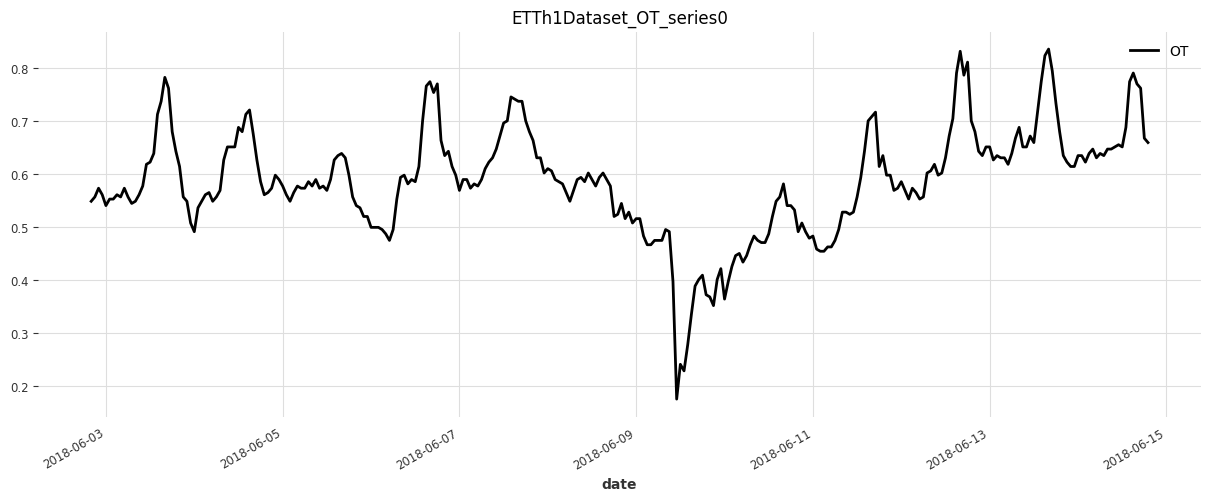

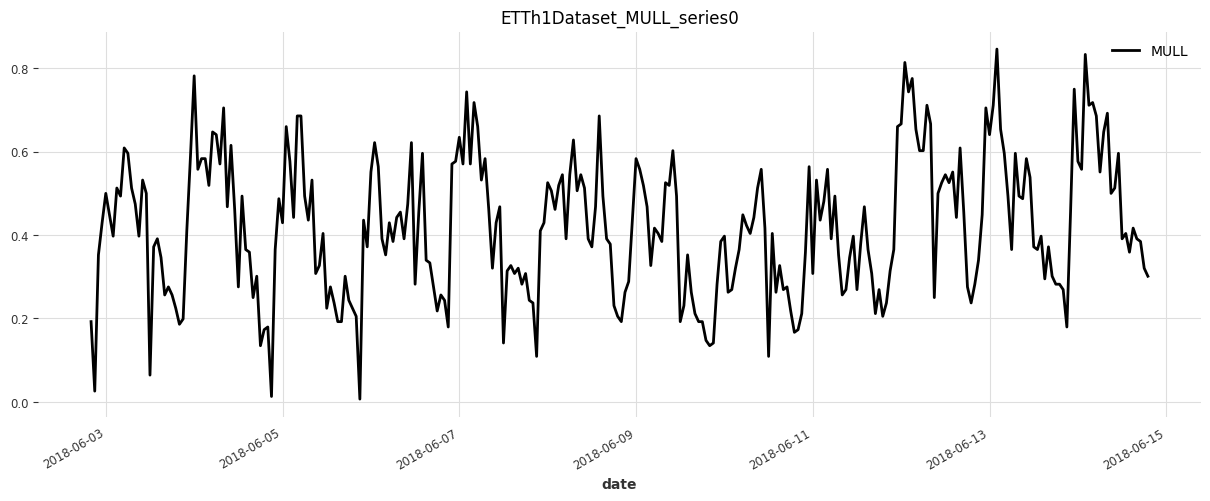

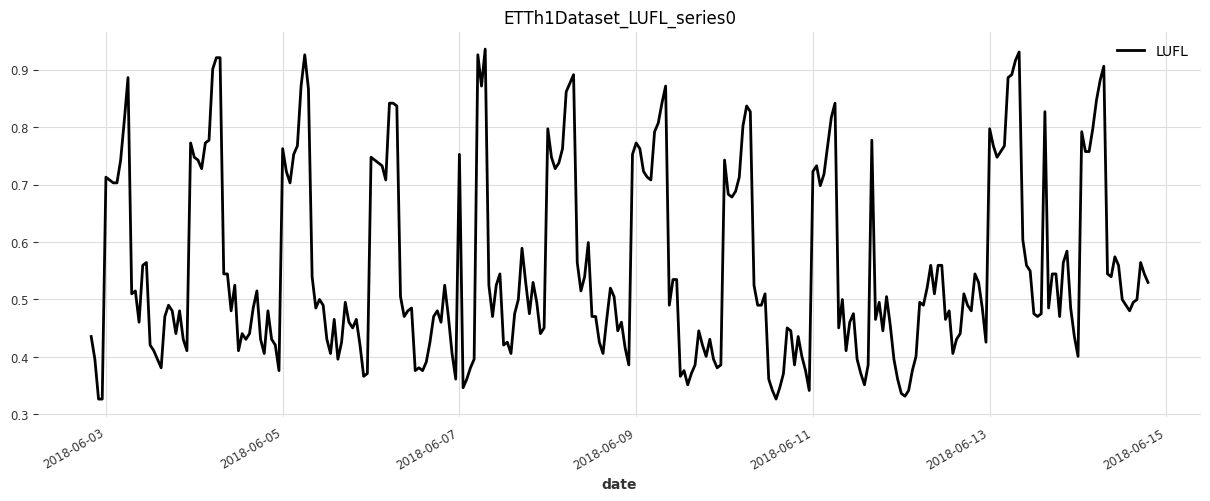

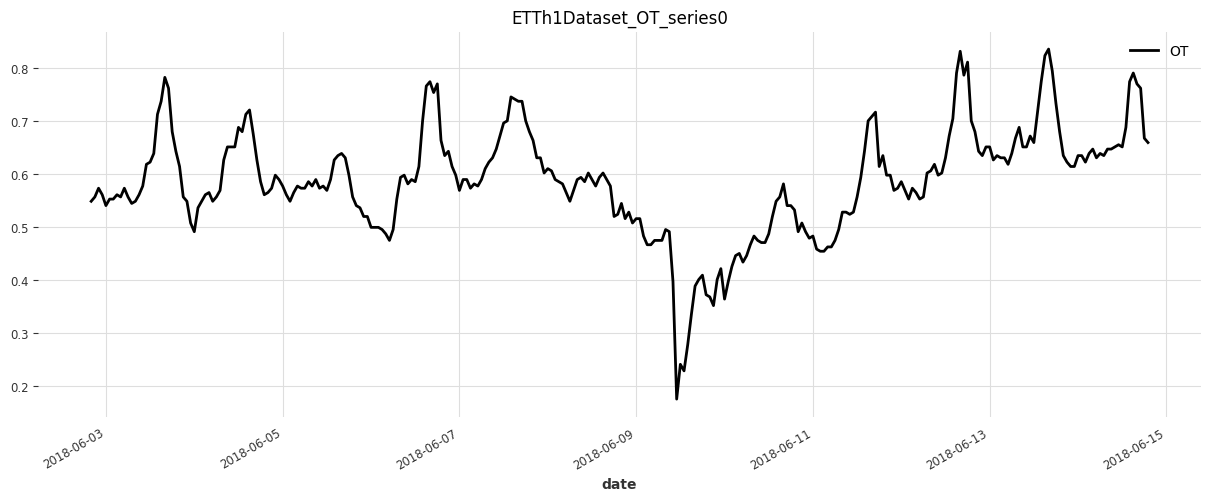

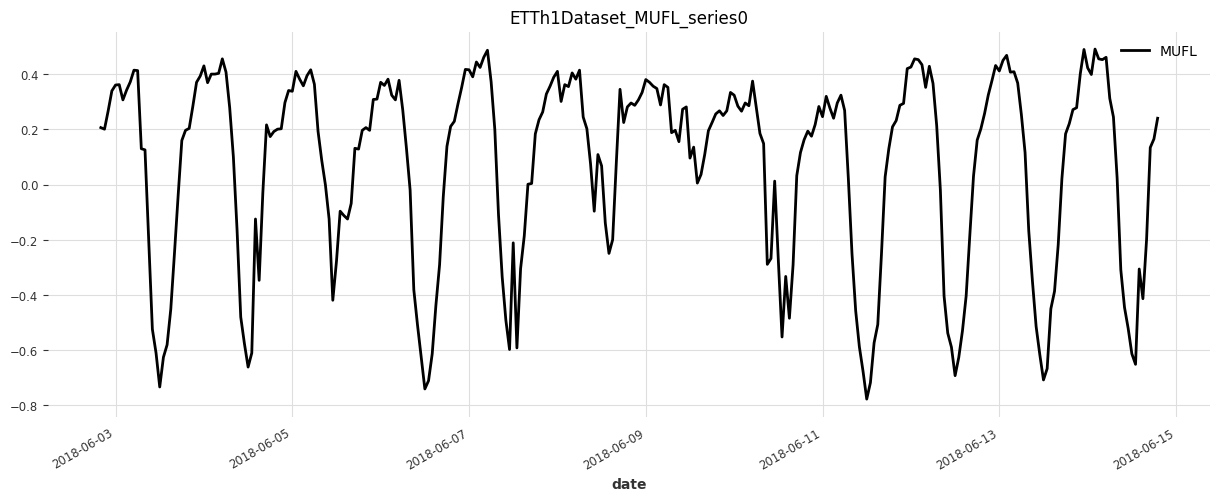

In [9]:
# pick series and components at random to plot 
max_series_to_plot = 5
max_comps_to_plot = 5


if n_components < max_comps_to_plot:
    max_comps_to_plot = n_components

comps_vec = np.random.randint(0, n_components, max_series_to_plot)
comp_names = train[0].columns.to_list()

if num_series < max_series_to_plot:
    max_series_to_plot = num_series

print("all components:", comp_names)
series_vec = np.random.randint(0, num_series, max_series_to_plot)

for idx in series_vec:
    for comp_id in comps_vec:
        comp_id = comp_names[comp_id]
        plt.figure(figsize=(15, 5))
        val[idx][comp_id].plot()
        plt.title(f"{dataset.__name__}_{comp_id}_series{idx}")
        plt.show()
        plt.close()


# setup optimiztation function and tuner

In [10]:
# objective function 

def objective_val_loss(config, model_cl, encoders, fixed_params, train=train, val=val):

    metrics = {"val_loss":"val_loss"}

    callbacks = [TuneReportCallback(metrics, on="validation_end")]

    model = MODEL_BUILDERS[model_cl.__name__](**config, encoders = encoders, callbacks=callbacks)

    # train the model
    model.fit(
        series=train,
        val_series=val,
        max_samples_per_ts=fixed_params["MAX_SAMPLES_PER_TS"]
    )

def objective_metric(config, model_cl, metric, encoders, fixed_params, train=train, val=val):
    model = MODEL_BUILDERS[model_cl.__name__](**config, encoders = encoders, fixed_params=fixed_params)

    # train the model
    model.fit(
        series=train,
        val_series=val,
        max_samples_per_ts=fixed_params["MAX_SAMPLES_PER_TS"]
    )

    # use best model for subsequent evaluation
    model = model_cl.load_from_checkpoint(model_cl.__name__, work_dir = os.getcwd(), best = True)

    preds = model.predict(series=train, n=val_len)

    
    if metric.__name__ == "mase":
        metric_evals = metric(val, preds, train, n_jobs=-1, verbose=True)
    else:
        metric_evals = metric(val, preds, n_jobs=-1, verbose=True)

    metric_evals_reduced = np.mean(metric_evals) if metric_evals != np.nan else float("inf")

    session.report({"metric":metric_evals_reduced})


objective_metric_with_params = tune.with_parameters(objective_metric, model_cl=model_cl, metric = eval_metric, 
                                            encoders = encoders, fixed_params=fixed_params, train=train, val=val)

objective_val_loss_with_params = tune.with_parameters(objective_val_loss, model_cl=model_cl, 
                                            encoders = encoders, fixed_params=fixed_params, train=train, val=val)

search_alg = OptunaSearch(
    space = params_generators[model_cl.__name__],
    metric= "metric",
    mode= "min",
)

tuner =  tune.Tuner(
            trainable=objective_metric_with_params if train_with_metric else objective_val_loss_with_params,
            tune_config = tune.TuneConfig(
                search_alg = search_alg,
                num_samples = -1,
                time_budget_s = time_budget,
            ),
            run_config = air.RunConfig(
                                       local_dir = experiment_dir,
                                       name = f"{model_cl.__name__}_tuner_{eval_metric.__name__}"),
            #param_space = params_space[model_cl.__name__],
        )

    

[I 2023-01-27 18:43:24,128] A new study created in memory with name: optuna


# run hyperparameters tuner

In [11]:
# run optimizer
tuner_results = tuner.fit()

2023-01-27 18:43:29,435	INFO worker.py:1538 -- Started a local Ray instance.


(objective_metric pid=49750) GPU available: False, used: False
(objective_metric pid=49750) TPU available: False, using: 0 TPU cores
(objective_metric pid=49750) IPU available: False, using: 0 IPUs
(objective_metric pid=49750) HPU available: False, using: 0 HPUs
(objective_metric pid=49750) 
(objective_metric pid=49750)   | Name          | Type             | Params
(objective_metric pid=49750) ---------------------------------------------------
(objective_metric pid=49750) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=49750) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=49750) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=49750) 3 | stacks        | ModuleList       | 4.3 M 
(objective_metric pid=49750) ---------------------------------------------------
(objective_metric pid=49750) 3.6 M     Trainable params
(objective_metric pid=49750) 649 K     Non-trainable params
(objective_metric pid=49750) 4.3 M     Total params
(o

Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.22it/s, loss=0.243, train_loss=0.243]
Validation: 0it [00:00, ?it/s]750) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49750) Metric val_loss improved. New best score: 0.224


(objective_metric pid=49750) 
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  1.29it/s, loss=0.208, train_loss=0.173, val_loss=0.224]
Validation: 0it [00:00, ?it/s]750) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49750) Metric val_loss improved by 0.064 >= min_delta = 0.001. New best score: 0.160


(objective_metric pid=49750) 
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  1.23it/s, loss=0.18, train_loss=0.124, val_loss=0.160] 
Validation: 0it [00:00, ?it/s]750) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49750) Metric val_loss improved by 0.034 >= min_delta = 0.001. New best score: 0.126


(objective_metric pid=49750) 
Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.18, train_loss=0.124, val_loss=0.126]        
Sanity Checking: 0it [00:00, ?it/s]4) 


(objective_metric pid=49784) GPU available: False, used: False
(objective_metric pid=49784) TPU available: False, using: 0 TPU cores
(objective_metric pid=49784) IPU available: False, using: 0 IPUs
(objective_metric pid=49784) HPU available: False, using: 0 HPUs
(objective_metric pid=49784) 
(objective_metric pid=49784)   | Name          | Type             | Params
(objective_metric pid=49784) ---------------------------------------------------
(objective_metric pid=49784) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=49784) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=49784) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=49784) 3 | stacks        | ModuleList       | 18.1 M
(objective_metric pid=49784) ---------------------------------------------------
(objective_metric pid=49784) 17.2 M    Trainable params
(objective_metric pid=49784) 922 K     Non-trainable params
(objective_metric pid=49784) 18.1 M    Total params
(o

Trial name,date,experiment_id,hostname,node_ip,pid,timestamp,trial_id
objective_metric_066a441f,2023-01-27_18-46-58,2d812fd746534f9281fd637f0d7f4bda,eliane.maalouf,127.0.0.1,51250,1674841618,066a441f
objective_metric_068f4812,2023-01-27_18-45-37,8f63e0cf0e6c47028d7ae4facc777f0b,eliane.maalouf,127.0.0.1,50322,1674841537,068f4812
objective_metric_0a000ada,2023-01-27_18-43-51,acbe3bedf6b24f76879c075820bad9b6,eliane.maalouf,127.0.0.1,49920,1674841431,0a000ada
objective_metric_0a95d07a,2023-01-27_18-48-06,793a5fc52a68433daa17c47c684b54be,eliane.maalouf,127.0.0.1,51795,1674841686,0a95d07a
objective_metric_0b85efdb,2023-01-27_18-43-38,b93e7040e1e54fe58b22ec4d5d34f1c7,eliane.maalouf,127.0.0.1,49783,1674841418,0b85efdb
objective_metric_0f3d9469,2023-01-27_18-43-51,535e5c123c50450e8b5073c8219e4b93,eliane.maalouf,127.0.0.1,49925,1674841431,0f3d9469
objective_metric_0f67d6c9,2023-01-27_18-47-07,02ac5a5560a544719eaa82f66f1c2e14,eliane.maalouf,127.0.0.1,51323,1674841627,0f67d6c9
objective_metric_11f69a7e,2023-01-27_18-45-37,8f63e0cf0e6c47028d7ae4facc777f0b,eliane.maalouf,127.0.0.1,50322,1674841537,11f69a7e
objective_metric_16cb0e69,2023-01-27_18-43-44,9c1594b43ec9473fb4831cb25131f2a5,eliane.maalouf,127.0.0.1,49857,1674841424,16cb0e69
objective_metric_1840838f,2023-01-27_18-46-49,9a18ed020a9c4a12a8a1bbce1f882abc,eliane.maalouf,127.0.0.1,51176,1674841609,1840838f


Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=49784) ValueError: The dataset contains some time series that are too short to contain `max(self.input_chunk_length, self.shift + self.output_chunk_length)` (0-th series)
(objective_metric pid=49783) ValueError: The dataset contains some time series that are too short to contain `max(self.input_chunk_length, self.shift + self.output_chunk_length)` (0-th series)
(objective_metric pid=49790) GPU available: False, used: False
2023-01-27 18:43:38,805	ERROR trial_runner.py:1088 -- Trial objective_metric_6e527949: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=49784, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/fu

Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  1.05it/s, loss=0.16, train_loss=0.0995, val_loss=0.126]

(objective_metric pid=49786) GPU available: False, used: False
(objective_metric pid=49786) TPU available: False, using: 0 TPU cores
(objective_metric pid=49786) IPU available: False, using: 0 IPUs
(objective_metric pid=49786) HPU available: False, using: 0 HPUs
(objective_metric pid=49786) 
(objective_metric pid=49786)   | Name          | Type             | Params
(objective_metric pid=49786) ---------------------------------------------------
(objective_metric pid=49786) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=49786) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=49786) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=49786) 3 | stacks        | ModuleList       | 20.5 M
(objective_metric pid=49786) ---------------------------------------------------
(objective_metric pid=49786) 17.7 M    Trainable params
(objective_metric pid=49786) 2.8 M     Non-trainable params
(objective_metric pid=49786) 20.5 M    Total params
(o


Validation: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49784) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=49784)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=49786) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=49786)   warnings.warn('resource_tracker: There appear to be %d '
2023-01-27 18:43:38,994	ERROR trial_runner.py:1088 -- Trial objective_metric_69b35a68: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=49785, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packa

(objective_metric pid=49750) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49785) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=49785)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=49750) Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.120


(objective_metric pid=49750) 
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  1.31it/s, loss=0.147, train_loss=0.0948, val_loss=0.120]
Validation: 0it [00:00, ?it/s]750) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             


(objective_metric pid=49750) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.116


(objective_metric pid=49750) 
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  1.27it/s, loss=0.138, train_loss=0.0926, val_loss=0.116]
Validation: 0it [00:00, ?it/s]750) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49750) Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.107


(objective_metric pid=49750) 
Epoch 0:  50%|█████     | 1/2 [00:02<00:02,  2.36s/it, loss=0.27, train_loss=0.270]
Validation: 0it [00:00, ?it/s]790) 
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  1.20it/s, loss=0.13, train_loss=0.0856, val_loss=0.107] 
Validation: 0it [00:00, ?it/s]750) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49790) 
Epoch 0: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it, loss=0.27, train_loss=0.270, val_loss=0.243]
(objective_metric pid=49750) 
Epoch 6: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s, loss=0.13, train_loss=0.0856, val_loss=0.0967]


(objective_metric pid=49790) Metric val_loss improved. New best score: 0.243
(objective_metric pid=49750) Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.097


Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  1.13it/s, loss=0.124, train_loss=0.0779, val_loss=0.0967]
Validation: 0it [00:00, ?it/s]750) 
(objective_metric pid=49750) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49750) Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.090


(objective_metric pid=49750) 
Epoch 0:  50%|█████     | 1/2 [00:04<00:04,  4.42s/it, loss=1.35, train_loss=1.350]
Validation: 0it [00:00, ?it/s]789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]8) 
Sanity Checking: 0it [00:00, ?it/s]5) 


(objective_metric pid=49855) GPU available: False, used: False
(objective_metric pid=49855) TPU available: False, using: 0 TPU cores
(objective_metric pid=49855) IPU available: False, using: 0 IPUs
(objective_metric pid=49855) HPU available: False, using: 0 HPUs
(objective_metric pid=49855) 
(objective_metric pid=49855)   | Name          | Type             | Params
(objective_metric pid=49855) ---------------------------------------------------
(objective_metric pid=49855) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=49855) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=49855) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=49855) 3 | stacks        | ModuleList       | 4.4 M 
(objective_metric pid=49855) ---------------------------------------------------
(objective_metric pid=49855) 3.5 M     Trainable params
(objective_metric pid=49855) 926 K     Non-trainable params
(objective_metric pid=49855) 4.4 M     Total params
(o

(objective_metric pid=49856) ValueError: The dataset contains some time series that are too short to contain `max(self.input_chunk_length, self.shift + self.output_chunk_length)` (0-th series)
2023-01-27 18:43:45,086	ERROR trial_runner.py:1088 -- Trial objective_metric_9c434350: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=49856, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49855) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=49855)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=49856) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=49856)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=49857) GPU available: False, used: False
(objective_metric pid=49857) TPU available: False, using: 0 TPU cores
(objective_metric pid=49857) IPU available: False, using: 0 IPUs
(objective_metric pid=49857) HPU available: False, using: 0 HPUs
(objective_metric pid=49857) 
(objective_metric pid=49857)   

Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  1.18it/s, loss=0.118, train_loss=0.0717, val_loss=0.0901]
Validation: 0it [00:00, ?it/s]750) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]7) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             


(objective_metric pid=49857) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=49857)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=49750) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.087


(objective_metric pid=49750) 
Epoch 1:  50%|█████     | 1/2 [00:02<00:02,  2.47s/it, loss=0.24, train_loss=0.211, val_loss=0.243]
Validation: 0it [00:00, ?it/s]790) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 0: 100%|██████████| 2/2 [00:05<00:00,  2.90s/it, loss=1.35, train_loss=1.350, val_loss=1.010]


(objective_metric pid=49789) Metric val_loss improved. New best score: 1.010


Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=1.35, train_loss=1.350, val_loss=1.010]        
(objective_metric pid=49750) 
Validation: 0it [00:00, ?it/s]750) 
(objective_metric pid=49750) 
Epoch 0:  50%|█████     | 1/2 [00:05<00:05,  5.71s/it, loss=1.47, train_loss=1.470]
Validation: 0it [00:00, ?it/s]787) 
(objective_metric pid=49787) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49790) 
Epoch 1: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it, loss=0.24, train_loss=0.211, val_loss=0.189]
(objective_metric pid=49750) 
Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.28s/it, loss=1.34, train_loss=1.340]
Validation: 0it [00:00, ?it/s]858) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49790) Metric val_loss improved by 0.054 >= min_delta = 0.001. New best score: 0.189
(objective_metric pid=49750) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.085


Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.24, train_loss=0.211, val_loss=0.189]        
(objective_metric pid=49858) 
Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=1.34, train_loss=1.340, val_loss=0.656]        


(objective_metric pid=49858) Metric val_loss improved. New best score: 0.656


Epoch 10:  50%|█████     | 1/2 [00:00<00:00,  1.24it/s, loss=0.109, train_loss=0.065, val_loss=0.0854] 
Validation: 0it [00:00, ?it/s]
(objective_metric pid=49750) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49750) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.084


(objective_metric pid=49750) 
Epoch 11:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.109, train_loss=0.065, val_loss=0.0843]        
(objective_metric pid=49787) 
Epoch 0: 100%|██████████| 2/2 [00:07<00:00,  3.92s/it, loss=1.47, train_loss=1.470, val_loss=2.270]


(objective_metric pid=49787) Metric val_loss improved. New best score: 2.270


Epoch 1:  50%|█████     | 1/2 [00:01<00:01,  1.38s/it, loss=1.02, train_loss=0.704, val_loss=0.656]
Validation: 0it [00:00, ?it/s]
Epoch 11:  50%|█████     | 1/2 [00:00<00:00,  1.23it/s, loss=0.105, train_loss=0.0626, val_loss=0.0843]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49750) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.082


(objective_metric pid=49750) 
Epoch 11: 100%|██████████| 2/2 [00:01<00:00,  1.68it/s, loss=0.105, train_loss=0.0626, val_loss=0.0824]
(objective_metric pid=49858) 
Epoch 2:  50%|█████     | 1/2 [00:02<00:02,  2.56s/it, loss=0.215, train_loss=0.165, val_loss=0.189]
(objective_metric pid=49790) 
Validation: 0it [00:00, ?it/s]790) 
Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=1.47, train_loss=1.470, val_loss=2.270]        
(objective_metric pid=49790) 
Epoch 12:  50%|█████     | 1/2 [00:00<00:00,  1.21it/s, loss=0.101, train_loss=0.0601, val_loss=0.0824]
Validation: 0it [00:00, ?it/s]750) 
(objective_metric pid=49790) 
Epoch 2: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.215, train_loss=0.165, val_loss=0.144]
(objective_metric pid=49750) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49790) Metric val_loss improved by 0.045 >= min_delta = 0.001. New best score: 0.144


Epoch 1:  50%|█████     | 1/2 [00:04<00:04,  4.15s/it, loss=1.18, train_loss=1.010, val_loss=1.010]
(objective_metric pid=49789) 
Validation: 0it [00:00, ?it/s]
(objective_metric pid=49789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49750) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.079


(objective_metric pid=49750) 
Epoch 2:  50%|█████     | 1/2 [00:01<00:01,  1.56s/it, loss=0.921, train_loss=0.715, val_loss=0.670]
Validation: 0it [00:00, ?it/s]858) 
(objective_metric pid=49858) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 13:  50%|█████     | 1/2 [00:00<00:00,  1.13it/s, loss=0.0982, train_loss=0.0578, val_loss=0.0794]
Validation: 0it [00:00, ?it/s]750) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49858) Metric val_loss improved by 0.128 >= min_delta = 0.001. New best score: 0.528


Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.921, train_loss=0.715, val_loss=0.528]


(objective_metric pid=49921) GPU available: False, used: False
(objective_metric pid=49921) TPU available: False, using: 0 TPU cores
(objective_metric pid=49921) IPU available: False, using: 0 IPUs
(objective_metric pid=49921) HPU available: False, using: 0 HPUs
(objective_metric pid=49921) 
(objective_metric pid=49921)   | Name          | Type             | Params
(objective_metric pid=49921) ---------------------------------------------------
(objective_metric pid=49921) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=49921) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=49921) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=49921) 3 | stacks        | ModuleList       | 5.9 M 
(objective_metric pid=49921) ---------------------------------------------------
(objective_metric pid=49921) 3.6 M     Trainable params
(objective_metric pid=49921) 2.3 M     Non-trainable params
(objective_metric pid=49921) 5.9 M     Total params
(o

(objective_metric pid=49750) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.076
(objective_metric pid=49921) ValueError: The dataset contains some time series that are too short to contain `max(self.input_chunk_length, self.shift + self.output_chunk_length)` (0-th series)
(objective_metric pid=49921) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=49921)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=49920) TPU available: False, using: 0 TPU cores
(objective_metric pid=49920) IPU available: False, using: 0 IPUs
(objective_metric pid=49920) HPU available: False, using: 0 HPUs
(objective_metric pid=49920) 
(objective_metric pid=49920)   | Name          | Type             | Params
(objective_metric pid=49920) ----------------------------

(objective_metric pid=49750) 
Epoch 13: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s, loss=0.0982, train_loss=0.0578, val_loss=0.0757]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=49789) Metric val_loss improved by 0.124 >= min_delta = 0.001. New best score: 0.886
(objective_metric pid=49920) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=49920)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=49925) ValueError: The dataset contains some time series that are too short to contain `max(self.input_chunk_length, self.shift + self.output_chunk_length)` (0-th series)
(objective_metric pid=49925) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=49925)   warnings.warn('resource_tracker: There appear to be %d '


(objective_metric pid=49789) 
Epoch 14:  50%|█████     | 1/2 [00:00<00:00,  1.39it/s, loss=0.0953, train_loss=0.0552, val_loss=0.0757]
Validation: 0it [00:00, ?it/s]750) 
(objective_metric pid=49750) 
Epoch 3:  50%|█████     | 1/2 [00:02<00:02,  2.44s/it, loss=0.193, train_loss=0.127, val_loss=0.144]
Validation: 0it [00:00, ?it/s]790) 
Epoch 3:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, loss=0.827, train_loss=0.545, val_loss=0.528]
Validation: 0it [00:00, ?it/s]858) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49750) 
Epoch 14: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s, loss=0.0953, train_loss=0.0552, val_loss=0.0717]


(objective_metric pid=49750) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.072


Epoch 15:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0953, train_loss=0.0552, val_loss=0.0717]        
(objective_metric pid=49858) 
Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.827, train_loss=0.545, val_loss=0.448]        


(objective_metric pid=49858) Metric val_loss improved by 0.080 >= min_delta = 0.001. New best score: 0.448


(objective_metric pid=49790) 
Epoch 3: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it, loss=0.193, train_loss=0.127, val_loss=0.110]


(objective_metric pid=49790) Metric val_loss improved by 0.034 >= min_delta = 0.001. New best score: 0.110


Epoch 15:  50%|█████     | 1/2 [00:00<00:00,  1.22it/s, loss=0.0927, train_loss=0.0531, val_loss=0.0717]
Validation: 0it [00:00, ?it/s]
Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.193, train_loss=0.127, val_loss=0.110]


(objective_metric pid=49750) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.068


(objective_metric pid=49750) 
Epoch 1:  50%|█████     | 1/2 [00:05<00:05,  5.57s/it, loss=1.91, train_loss=2.350, val_loss=2.270]
Validation: 0it [00:00, ?it/s]787) 
(objective_metric pid=49787) 
Epoch 4:  50%|█████     | 1/2 [00:01<00:01,  1.35s/it, loss=0.748, train_loss=0.433, val_loss=0.448]
Validation: 0it [00:00, ?it/s]858) 
(objective_metric pid=49858) 
Epoch 16:  50%|█████     | 1/2 [00:00<00:00,  1.14it/s, loss=0.0903, train_loss=0.0515, val_loss=0.0679]
Validation: 0it [00:00, ?it/s]750) 
(objective_metric pid=49750) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 4: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s, loss=0.748, train_loss=0.433, val_loss=0.461]
(objective_metric pid=49750) 
Epoch 5:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.748, train_loss=0.433, val_loss=0.461]        


(objective_metric pid=49750) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.064


Epoch 2:  50%|█████     | 1/2 [00:03<00:03,  3.81s/it, loss=1.09, train_loss=0.901, val_loss=0.886]
Validation: 0it [00:00, ?it/s]789) 
Epoch 4:  50%|█████     | 1/2 [00:02<00:02,  2.41s/it, loss=0.175, train_loss=0.102, val_loss=0.110]
Validation: 0it [00:00, ?it/s]790) 
Epoch 17:  50%|█████     | 1/2 [00:00<00:00,  1.21it/s, loss=0.0881, train_loss=0.0503, val_loss=0.0643]
Validation: 0it [00:00, ?it/s]750) 
(objective_metric pid=49750) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49787) 
Epoch 1: 100%|██████████| 2/2 [00:07<00:00,  3.76s/it, loss=1.91, train_loss=2.350, val_loss=0.716]


(objective_metric pid=49787) Metric val_loss improved by 1.554 >= min_delta = 0.001. New best score: 0.716
(objective_metric pid=49750) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.061


(objective_metric pid=49750) 
Epoch 5:  50%|█████     | 1/2 [00:01<00:01,  1.36s/it, loss=0.695, train_loss=0.430, val_loss=0.461]
Validation: 0it [00:00, ?it/s]858) 
(objective_metric pid=49858) 
Epoch 18:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0881, train_loss=0.0503, val_loss=0.0614]        
(objective_metric pid=49790) 
Epoch 4: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it, loss=0.175, train_loss=0.102, val_loss=0.0954]
(objective_metric pid=49858) 
Epoch 5: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it, loss=0.695, train_loss=0.430, val_loss=0.484]


(objective_metric pid=49790) Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.095


Epoch 6:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.695, train_loss=0.430, val_loss=0.484]
(objective_metric pid=49789) 
Epoch 2: 100%|██████████| 2/2 [00:05<00:00,  2.71s/it, loss=1.09, train_loss=0.901, val_loss=0.760]


(objective_metric pid=49789) Metric val_loss improved by 0.126 >= min_delta = 0.001. New best score: 0.760


Epoch 18:  50%|█████     | 1/2 [00:00<00:00,  1.09it/s, loss=0.086, train_loss=0.0492, val_loss=0.0614] 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49750) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.059


(objective_metric pid=49750) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49987) GPU available: False, used: False
(objective_metric pid=49987) TPU available: False, using: 0 TPU cores
(objective_metric pid=49987) IPU available: False, using: 0 IPUs
(objective_metric pid=49987) HPU available: False, using: 0 HPUs
(objective_metric pid=49987) 
(objective_metric pid=49987)   | Name          | Type             | Params
(objective_metric pid=49987) ---------------------------------------------------
(objective_metric pid=49987) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=49987) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=49987) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=49987) 3 | stacks        | ModuleList       | 3.4 M 
(objective_metric pid=49987) ---------------------------------------------------
(objective_metric pid=49987) 2.9 M     Trainable params
(objective_metric pid=49987) 513 K     Non-trainable params
(objective_metric pid=49987) 3.4 M     Total params
(o

Sanity Checking: 0it [00:00, ?it/s]
Epoch 19:  50%|█████     | 1/2 [00:00<00:00,  1.11it/s, loss=0.0841, train_loss=0.0479, val_loss=0.0593]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 1/2 [00:01<00:01,  1.64s/it, loss=0.66, train_loss=0.452, val_loss=0.484] 
Validation: 0it [00:00, ?it/s]
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s] 
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=49994) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=49994)   warnings.warn('resource_tracker: There appear to be %d '


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49750) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.058


(objective_metric pid=49750) 
Epoch 20:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0841, train_loss=0.0479, val_loss=0.0579]        
(objective_metric pid=49858) 
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.35it/s, loss=0.246, train_loss=0.246]
Validation: 0it [00:00, ?it/s]987) 
Epoch 6: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, loss=0.66, train_loss=0.452, val_loss=0.469]


(objective_metric pid=49858) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.448. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.23it/s]
(objective_metric pid=49987) 
Epoch 0: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s, loss=0.246, train_loss=0.246, val_loss=0.260]


(objective_metric pid=49858) GPU available: False, used: False
(objective_metric pid=49858) TPU available: False, using: 0 TPU cores
(objective_metric pid=49858) IPU available: False, using: 0 IPUs
(objective_metric pid=49858) HPU available: False, using: 0 HPUs
  0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49987) Metric val_loss improved. New best score: 0.260
100%|██████████| 1/1 [00:00<00:00, 20.68it/s]


Epoch 20:  50%|█████     | 1/2 [00:01<00:01,  1.01s/it, loss=0.0743, train_loss=0.0468, val_loss=0.0579]
Validation: 0it [00:00, ?it/s]750) 
(objective_metric pid=49790) 
Validation: 0it [00:00, ?it/s]790) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             
(objective_metric pid=49750) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49750) 
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  1.19it/s, loss=0.235, train_loss=0.223, val_loss=0.260]
Validation: 0it [00:00, ?it/s]987) 
Epoch 21:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0743, train_loss=0.0468, val_loss=0.0571]        
(objective_metric pid=49987) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49987) Metric val_loss improved by 0.036 >= min_delta = 0.001. New best score: 0.223


(objective_metric pid=49987) 
Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.235, train_loss=0.223, val_loss=0.223]        
(objective_metric pid=49790) 
Epoch 21:  50%|█████     | 1/2 [00:01<00:01,  1.39s/it, loss=0.0679, train_loss=0.0453, val_loss=0.0571]
Validation: 0it [00:00, ?it/s]750) 
Epoch 2:  50%|█████     | 1/2 [00:01<00:01,  1.13s/it, loss=0.221, train_loss=0.194, val_loss=0.223]
(objective_metric pid=49987) 
Validation: 0it [00:00, ?it/s]987) 
(objective_metric pid=49987) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49750) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.057
(objective_metric pid=49987) Metric val_loss improved by 0.054 >= min_delta = 0.001. New best score: 0.169


(objective_metric pid=49750) 
Epoch 21: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s, loss=0.0679, train_loss=0.0453, val_loss=0.0567]
(objective_metric pid=49987) 
Epoch 2:  50%|█████     | 1/2 [00:06<00:06,  6.48s/it, loss=1.52, train_loss=0.736, val_loss=0.716]
Validation: 0it [00:00, ?it/s]787) 
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  1.36it/s, loss=0.204, train_loss=0.152, val_loss=0.169]
Validation: 0it [00:00, ?it/s]987) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Validation: 0it [00:00, ?it/s]789) 
(objective_metric pid=49787) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 22:  50%|█████     | 1/2 [00:00<00:00,  1.04it/s, loss=0.064, train_loss=0.0445, val_loss=0.0567] 
Validation: 0it [00:00, ?it/s]750) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49987) 
Epoch 3: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s, loss=0.204, train_los

(objective_metric pid=49987) Metric val_loss improved by 0.046 >= min_delta = 0.001. New best score: 0.123


Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.204, train_loss=0.152, val_loss=0.123]        
(objective_metric pid=49750) 
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.185, train_loss=0.113, val_loss=0.123]
Validation: 0it [00:00, ?it/s]987) 
Epoch 0:  50%|█████     | 1/2 [00:04<00:04,  4.60s/it, loss=0.445, train_loss=0.445]
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=49987) 
Epoch 4: 100%|██████████| 2/2 [00:00<00:00,  2.20it/s, loss=0.185, train_loss=0.113, val_loss=0.163]
(objective_metric pid=49991) 
Epoch 6:  50%|█████     | 1/2 [00:03<00:03,  3.36s/it, loss=0.154, train_loss=0.105, val_loss=0.100] 
Validation: 0it [00:00, ?it/s]790) 
Epoch 5:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.185, train_loss=0.113, val_loss=0.163]        
(objective_metric pid=49790) 
Epoch 23:  50%|█████     | 1/2 [00:00<00:00,  1.17it/s, loss=0.0612, train_loss=0.0436, val_loss=0.0567]
Validation: 0it [00:00, ?it/s]750) 
Validation DataLoader 0:   0%|          

(objective_metric pid=49789) Metric val_loss improved by 0.069 >= min_delta = 0.001. New best score: 0.691


(objective_metric pid=49750) 
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  1.42it/s, loss=0.177, train_loss=0.133, val_loss=0.163]
Validation: 0it [00:00, ?it/s]987) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49787) 
Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s, loss=1, train_loss=0.755, val_loss=0.691]        
(objective_metric pid=49987) 
Epoch 5: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s, loss=0.177, train_loss=0.133, val_loss=0.113]


(objective_metric pid=49787) Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.709
(objective_metric pid=49987) Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.113


(objective_metric pid=49790) 
Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.154, train_loss=0.105, val_loss=0.102]        
(objective_metric pid=49991) 
Epoch 0: 100%|██████████| 2/2 [00:06<00:00,  3.03s/it, loss=0.445, train_loss=0.445, val_loss=0.240]


(objective_metric pid=49991) Metric val_loss improved. New best score: 0.240


Epoch 24:  50%|█████     | 1/2 [00:00<00:00,  1.14it/s, loss=0.0586, train_loss=0.043, val_loss=0.0568] 
Validation: 0it [00:00, ?it/s]
(objective_metric pid=49750) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49750) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.057. Signaling Trainer to stop.
(objective_metric pid=49750) GPU available: False, used: False
(objective_metric pid=49750) TPU available: False, using: 0 TPU cores
(objective_metric pid=49750) IPU available: False, using: 0 IPUs
(objective_metric pid=49750) HPU available: False, using: 0 HPUs


(objective_metric pid=49750) 
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  1.35it/s, loss=0.166, train_loss=0.0988, val_loss=0.113]
Validation: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 37.68it/s]
(objective_metric pid=49987) Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 0.092


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.47it/s]
(objective_metric pid=49987) 
Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.166, train_loss=0.0988, val_loss=0.0924]


(objective_metric pid=50063) GPU available: False, used: False
(objective_metric pid=50063) TPU available: False, using: 0 TPU cores
(objective_metric pid=50063) IPU available: False, using: 0 IPUs
(objective_metric pid=50063) HPU available: False, using: 0 HPUs
(objective_metric pid=50063) 
(objective_metric pid=50063)   | Name          | Type             | Params
(objective_metric pid=50063) ---------------------------------------------------
(objective_metric pid=50063) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=50063) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=50063) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=50063) 3 | stacks        | ModuleList       | 31.7 M
(objective_metric pid=50063) ---------------------------------------------------
(objective_metric pid=50063) 29.1 M    Trainable params
(objective_metric pid=50063) 2.6 M     Non-trainable params
(objective_metric pid=50063) 31.7 M    Total params
(o

Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=50063) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=50063)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=49858) GPU available: False, used: False
(objective_metric pid=49858) TPU available: False, using: 0 TPU cores
(objective_metric pid=49858) IPU available: False, using: 0 IPUs
(objective_metric pid=49858) HPU available: False, using: 0 HPUs
(objective_metric pid=49858) 
(objective_metric pid=49858)   | Name          | Type             | Params
(objective_metric pid=49858) ---------------------------------------------------
(objective_metric pid=49858) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=49858) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=49858) 2 | val_metrics   | MetricCollecti

Sanity Checking: 0it [00:00, ?it/s]8) 
Epoch 7:  50%|█████     | 1/2 [00:01<00:01,  1.16s/it, loss=0.156, train_loss=0.0862, val_loss=0.0924]
Validation: 0it [00:00, ?it/s]987) 
(objective_metric pid=49987) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49987) 
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  1.21it/s, loss=0.148, train_loss=0.0881, val_loss=0.0939]
Validation: 0it [00:00, ?it/s]987) 
(objective_metric pid=49987) 
Epoch 7:  50%|█████     | 1/2 [00:03<00:03,  3.69s/it, loss=0.148, train_loss=0.108, val_loss=0.102]
Validation: 0it [00:00, ?it/s]790) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             
(objective_metric pid=49987) 
Epoch 8: 100%|██████████| 2/2 [00:01<00:00,  1.70it/s, loss=0.148, train_loss=0.0881, val_loss=0.0964]
(objective_metric pid=49790) 
Epoch 9:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.142, train_loss=0.0894, val_loss=0.0964]
Validation: 0it [00:00, ?it/s]987) 
Validation Data

(objective_metric pid=49790) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.095. Signaling Trainer to stop.
(objective_metric pid=49987) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.092. Signaling Trainer to stop.
(objective_metric pid=49987) GPU available: False, used: False
(objective_metric pid=49987) TPU available: False, using: 0 TPU cores
(objective_metric pid=49987) IPU available: False, using: 0 IPUs
(objective_metric pid=49987) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 34.09it/s]


Epoch 1:  50%|█████     | 1/2 [00:04<00:04,  4.91s/it, loss=0.327, train_loss=0.209, val_loss=0.240]
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=49991) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49790) GPU available: False, used: False
(objective_metric pid=49790) TPU available: False, using: 0 TPU cores
(objective_metric pid=49790) IPU available: False, using: 0 IPUs
(objective_metric pid=49790) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


Epoch 4:  50%|█████     | 1/2 [00:06<00:06,  6.39s/it, loss=0.942, train_loss=0.694, val_loss=0.691]
Validation: 0it [00:00, ?it/s]789) 
(objective_metric pid=49789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49991) 
Epoch 1: 100%|██████████| 2/2 [00:06<00:00,  3.37s/it, loss=0.327, train_loss=0.209, val_loss=0.142]


(objective_metric pid=49991) Metric val_loss improved by 0.099 >= min_delta = 0.001. New best score: 0.142


Epoch 3:  50%|█████     | 1/2 [00:07<00:07,  7.11s/it, loss=1.3, train_loss=0.642, val_loss=0.709] 
(objective_metric pid=49787) 
Validation: 0it [00:00, ?it/s]787) 
(objective_metric pid=49787) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.327, train_loss=0.209, val_loss=0.142]        


(objective_metric pid=49789) Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.678


Epoch 0:  50%|█████     | 1/2 [00:05<00:05,  5.78s/it, loss=0.473, train_loss=0.473]
Validation: 0it [00:00, ?it/s]858) 
(objective_metric pid=49858) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49787) 
Epoch 3: 100%|██████████| 2/2 [00:09<00:00,  4.78s/it, loss=1.3, train_loss=0.642, val_loss=0.951]


(objective_metric pid=50128) GPU available: False, used: False
(objective_metric pid=50128) TPU available: False, using: 0 TPU cores
(objective_metric pid=50128) IPU available: False, using: 0 IPUs
(objective_metric pid=50128) HPU available: False, using: 0 HPUs
(objective_metric pid=50128) 
(objective_metric pid=50128)   | Name          | Type             | Params
(objective_metric pid=50128) ---------------------------------------------------
(objective_metric pid=50128) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=50128) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=50128) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=50128) 3 | stacks        | ModuleList       | 11.1 M
(objective_metric pid=50128) ---------------------------------------------------
(objective_metric pid=50128) 10.3 M    Trainable params
(objective_metric pid=50128) 804 K     Non-trainable params
(objective_metric pid=50128) 11.1 M    Total params
(o

Sanity Checking: 0it [00:00, ?it/s]8) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49987) GPU available: False, used: False
(objective_metric pid=49987) TPU available: False, using: 0 TPU cores
(objective_metric pid=49987) IPU available: False, using: 0 IPUs
(objective_metric pid=49987) HPU available: False, using: 0 HPUs
(objective_metric pid=49987) 
(objective_metric pid=49987)   | Name          | Type             | Params
(objective_metric pid=49987) ---------------------------------------------------
(objective_metric pid=49987) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=49987) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=49987) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=49987) 3 | stacks        | ModuleList       | 10.7 M
(objective_metric pid=49987) ---------------------------------------------------
(objective_metric pid=49987) 9.5 M     Trainable params
(objective_metric pid=49987) 1.2 M     Non-trainable params
(objective_metric pid=49987) 10.7 M    Total params
(o

Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s, loss=1.3, train_loss=0.642, val_loss=0.951]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=49750) GPU available: False, used: False
(objective_metric pid=49750) TPU available: False, using: 0 TPU cores
(objective_metric pid=49750) IPU available: False, using: 0 IPUs
(objective_metric pid=49750) HPU available: False, using: 0 HPUs
(objective_metric pid=49750) 
(objective_metric pid=49750)   | Name          | Type             | Params
(objective_metric pid=49750) ---------------------------------------------------
(objective_metric pid=49750) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=49750) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=49750) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=49750) 3 | stacks        | ModuleList       | 9.3 M 
(objective_metric pid=49750) ---------------------------------------------------
(objective_metric pid=49750) 7.2 M     Trainable params
(objective_metric pid=49750) 2.1 M     Non-trainable params
(objective_metric pid=49750) 9.3 M     Total params
(o

Sanity Checking: 0it [00:00, ?it/s]
(objective_metric pid=49858) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49790) GPU available: False, used: False
(objective_metric pid=49790) TPU available: False, using: 0 TPU cores
(objective_metric pid=49790) IPU available: False, using: 0 IPUs
(objective_metric pid=49790) HPU available: False, using: 0 HPUs
(objective_metric pid=49790) 
(objective_metric pid=49790)   | Name          | Type             | Params
(objective_metric pid=49790) ---------------------------------------------------
(objective_metric pid=49790) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=49790) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=49790) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=49790) 3 | stacks        | ModuleList       | 8.6 M 
(objective_metric pid=49790) ---------------------------------------------------
(objective_metric pid=49790) 7.8 M     Trainable params
(objective_metric pid=49790) 797 K     Non-trainable params
(objective_metric pid=49790) 8.6 M     Total params
(o

Sanity Checking: 0it [00:00, ?it/s]0) 
Epoch 2:  50%|█████     | 1/2 [00:04<00:04,  4.59s/it, loss=0.262, train_loss=0.131, val_loss=0.142]
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=49991) 
Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.86s/it, loss=0.275, train_loss=0.275]
Validation: 0it [00:00, ?it/s]750) 
(objective_metric pid=49750) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49991) 
Epoch 0:  50%|█████     | 1/2 [00:02<00:02,  2.74s/it, loss=0.26, train_loss=0.260]
Validation: 0it [00:00, ?it/s]128) 


(objective_metric pid=49991) Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.124


(objective_metric pid=50128) 
Epoch 5:  50%|█████     | 1/2 [00:05<00:05,  5.57s/it, loss=0.899, train_loss=0.681, val_loss=0.678]
Validation: 0it [00:00, ?it/s]789) 
(objective_metric pid=49789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49750) 
Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.262, train_loss=0.131, val_loss=0.124]        


(objective_metric pid=49750) Monitored metric val_loss did not improve in the last 4 records. Best score: 0.057. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it, loss=0.275, train_loss=0.275, val_loss=0.137]


(objective_metric pid=49750) GPU available: False, used: False
(objective_metric pid=49750) TPU available: False, using: 0 TPU cores
(objective_metric pid=49750) IPU available: False, using: 0 IPUs
(objective_metric pid=49750) HPU available: False, using: 0 HPUs
(objective_metric pid=50128) Metric val_loss improved. New best score: 0.153
100%|██████████| 1/1 [00:00<00:00, 748.98it/s]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50128) 
Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.26, train_loss=0.260, val_loss=0.153]        
(objective_metric pid=49789) 
Epoch 5: 100%|██████████| 2/2 [00:07<00:00,  3.53s/it, loss=0.899, train_loss=0.681, val_loss=0.638]


(objective_metric pid=49789) Metric val_loss improved by 0.041 >= min_delta = 0.001. New best score: 0.638


Epoch 1:  50%|█████     | 1/2 [00:04<00:04,  4.63s/it, loss=0.426, train_loss=0.378, val_loss=0.426]
Validation: 0it [00:00, ?it/s]858) 
Epoch 4:  50%|█████     | 1/2 [00:06<00:06,  6.14s/it, loss=1.21, train_loss=0.840, val_loss=0.951]
Validation: 0it [00:00, ?it/s]787) 
(objective_metric pid=49787) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 1: 100%|██████████| 2/2 [00:06<00:00,  3.06s/it, loss=0.426, train_loss=0.378, val_loss=0.226]


(objective_metric pid=49858) Metric val_loss improved by 0.200 >= min_delta = 0.001. New best score: 0.226


Epoch 1:  50%|█████     | 1/2 [00:02<00:02,  2.82s/it, loss=0.188, train_loss=0.117, val_loss=0.153]
(objective_metric pid=50128) 
Validation: 0it [00:00, ?it/s]128) 
Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.426, train_loss=0.378, val_loss=0.226]        
Sanity Checking: 0it [00:00, ?it/s]0) 


(objective_metric pid=50210) GPU available: False, used: False
(objective_metric pid=50210) TPU available: False, using: 0 TPU cores
(objective_metric pid=50210) IPU available: False, using: 0 IPUs
(objective_metric pid=50210) HPU available: False, using: 0 HPUs
(objective_metric pid=50210) 
(objective_metric pid=50210)   | Name          | Type             | Params
(objective_metric pid=50210) ---------------------------------------------------
(objective_metric pid=50210) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=50210) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=50210) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=50210) 3 | stacks        | ModuleList       | 14.8 M
(objective_metric pid=50210) ---------------------------------------------------
(objective_metric pid=50210) 13.7 M    Trainable params
(objective_metric pid=50210) 1.2 M     Non-trainable params
(objective_metric pid=50210) 14.8 M    Total params
(o

Epoch 3:  50%|█████     | 1/2 [00:04<00:04,  4.32s/it, loss=0.225, train_loss=0.116, val_loss=0.124]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=49787) 
Epoch 4: 100%|██████████| 2/2 [00:08<00:00,  4.20s/it, loss=1.21, train_loss=0.840, val_loss=0.811]
(objective_metric pid=49991) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=50210) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=50210)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=50211) GPU available: False, used: False
(objective_metric pid=50211) TPU available: False, using: 0 TPU cores
(objective_metric pid=50211) IPU available: False, using: 0 IPUs
(objective_metric pid=50211) HPU available: False, using: 0 HPUs
(objective_metric pid=50211) 
(objective_metric pid=50211)   | Name          | Type             | Params
(objective_metric pid=50211) ---------------------------------------------------
(objective_metric pid=50211) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=50211) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=50211) 2 | val_metrics   | MetricCollecti

(objective_metric pid=49750) GPU available: False, used: False
(objective_metric pid=49750) TPU available: False, using: 0 TPU cores
(objective_metric pid=49750) IPU available: False, using: 0 IPUs
(objective_metric pid=49750) HPU available: False, using: 0 HPUs
(objective_metric pid=49750) 
(objective_metric pid=49750)   | Name          | Type             | Params
(objective_metric pid=49750) ---------------------------------------------------
(objective_metric pid=49750) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=49750) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=49750) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=49750) 3 | stacks        | ModuleList       | 25.0 M
(objective_metric pid=49750) ---------------------------------------------------
(objective_metric pid=49750) 22.3 M    Trainable params
(objective_metric pid=49750) 2.7 M     Non-trainable params
(objective_metric pid=49750) 25.0 M    Total params
(o

Sanity Checking: 0it [00:00, ?it/s]0) 
(objective_metric pid=50128) 
Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.188, train_loss=0.117, val_loss=0.131]        
(objective_metric pid=49991) 
Epoch 3: 100%|██████████| 2/2 [00:05<00:00,  2.80s/it, loss=0.225, train_loss=0.116, val_loss=0.123]


(objective_metric pid=49991) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.123


Epoch 6:  50%|█████     | 1/2 [00:04<00:04,  4.96s/it, loss=0.862, train_loss=0.646, val_loss=0.638]
Validation: 0it [00:00, ?it/s]789) 
(objective_metric pid=49789) 
Epoch 2:  50%|█████     | 1/2 [00:02<00:02,  2.21s/it, loss=0.163, train_loss=0.114, val_loss=0.131]
Validation: 0it [00:00, ?it/s]128) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50128) Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.123


(objective_metric pid=50128) 
Epoch 2:  50%|█████     | 1/2 [00:04<00:04,  4.26s/it, loss=0.353, train_loss=0.206, val_loss=0.226]
Validation: 0it [00:00, ?it/s]858) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.163, train_loss=0.114, val_loss=0.123]        


(objective_metric pid=49789) Metric val_loss improved by 0.045 >= min_delta = 0.001. New best score: 0.593


Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.862, train_loss=0.646, val_loss=0.593]        
(objective_metric pid=49858) 
Epoch 4:  50%|█████     | 1/2 [00:03<00:03,  3.48s/it, loss=0.203, train_loss=0.113, val_loss=0.123]
Validation: 0it [00:00, ?it/s]991) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49858) Metric val_loss improved by 0.046 >= min_delta = 0.001. New best score: 0.180


Epoch 5:  50%|█████     | 1/2 [00:05<00:05,  5.82s/it, loss=1.12, train_loss=0.700, val_loss=0.811]
Validation: 0it [00:00, ?it/s]787) 
(objective_metric pid=49787) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49991) 
Epoch 3:  50%|█████     | 1/2 [00:02<00:02,  2.53s/it, loss=0.15, train_loss=0.109, val_loss=0.123] 
Validation: 0it [00:00, ?it/s]128) 
(objective_metric pid=50128) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49991) Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.115
(objective_metric pid=50267) GPU available: False, used: False
(objective_metric pid=50267) TPU available: False, using: 0 TPU cores
(objective_metric pid=50267) IPU available: False, using: 0 IPUs
(objective_metric pid=50267) HPU available: False, using: 0 HPUs
(objective_metric pid=50267) 
(objective_metric pid=50267)   | Name          | Type             | Params
(objective_metric pid=50267) ---------------------------------------------------
(objective_metric pid=50267) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=50267) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=50267) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=50267) 3 | stacks        | ModuleList       | 13.0 M
(objective_metric pid=50267) ---------------------------------------------------
(objective_metric pid=50267) 11.0 M    Trainable params
(object

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=50266) ValueError: The dataset contains some time series that are too short to contain `max(self.input_chunk_length, self.shift + self.output_chunk_length)` (0-th series)


Sanity Checking: 0it [00:00, ?it/s]
Epoch 5:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.203, train_loss=0.113, val_loss=0.115]


(objective_metric pid=50266) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=50266)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=50128) Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 0.101


(objective_metric pid=50128) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             
(objective_metric pid=49787) 
Epoch 5: 100%|██████████| 2/2 [00:07<00:00,  3.99s/it, loss=1.12, train_loss=0.700, val_loss=0.556]


(objective_metric pid=49787) Metric val_loss improved by 0.152 >= min_delta = 0.001. New best score: 0.556


Epoch 7:  50%|█████     | 1/2 [00:05<00:05,  5.18s/it, loss=0.829, train_loss=0.598, val_loss=0.593]
Validation: 0it [00:00, ?it/s]789) 
(objective_metric pid=49789) 
Epoch 3:  50%|█████     | 1/2 [00:04<00:04,  4.97s/it, loss=0.309, train_loss=0.178, val_loss=0.180]
Validation: 0it [00:00, ?it/s]858) 
Epoch 4:  50%|█████     | 1/2 [00:03<00:03,  3.03s/it, loss=0.137, train_loss=0.086, val_loss=0.101]
Validation: 0it [00:00, ?it/s]128) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 0:  50%|█████     | 1/2 [00:03<00:03,  3.16s/it, loss=0.246, train_loss=0.246]
Validation: 0it [00:00, ?it/s]267) 
(objective_metric pid=50267) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 5:  50%|█████     | 1/2 [00:04<00:04,  4.41s/it, loss=0.187, train_loss=0.105, val_loss=0.115]
Validation: 0it [00:00, ?it/s]991) 


(objective_metric pid=49789) Metric val_loss improved by 0.041 >= min_delta = 0.001. New best score: 0.551


(objective_metric pid=49991) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50128) Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.088


(objective_metric pid=50128) 
Epoch 5:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.137, train_loss=0.086, val_loss=0.0882]        
(objective_metric pid=50267) 
Epoch 0: 100%|██████████| 2/2 [00:04<00:00,  2.23s/it, loss=0.246, train_loss=0.246, val_loss=0.225]


(objective_metric pid=50267) Metric val_loss improved. New best score: 0.225


(objective_metric pid=49858) 
Epoch 0:  50%|█████     | 1/2 [00:04<00:04,  4.43s/it, loss=0.226, train_loss=0.226]
Validation: 0it [00:00, ?it/s]268) 
Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.246, train_loss=0.246, val_loss=0.225]        
(objective_metric pid=50268) 
Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.309, train_loss=0.178, val_loss=0.189]        
(objective_metric pid=49991) 
Epoch 5: 100%|██████████| 2/2 [00:06<00:00,  3.03s/it, loss=0.187, train_loss=0.105, val_loss=0.102]


(objective_metric pid=49991) Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.102


Epoch 6:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.187, train_loss=0.105, val_loss=0.102]


(objective_metric pid=50268) Metric val_loss improved. New best score: 0.258


(objective_metric pid=50268) 
Epoch 5:  50%|█████     | 1/2 [00:03<00:03,  3.17s/it, loss=0.126, train_loss=0.0707, val_loss=0.0882]
Validation: 0it [00:00, ?it/s]128) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50322) GPU available: False, used: False
(objective_metric pid=50322) TPU available: False, using: 0 TPU cores
(objective_metric pid=50322) IPU available: False, using: 0 IPUs
(objective_metric pid=50322) HPU available: False, using: 0 HPUs
(objective_metric pid=50322) 
(objective_metric pid=50322)   | Name          | Type             | Params
(objective_metric pid=50322) ---------------------------------------------------
(objective_metric pid=50322) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=50322) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=50322) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=50322) 3 | stacks        | ModuleList       | 5.5 M 
(objective_metric pid=50322) ---------------------------------------------------
(objective_metric pid=50322) 4.8 M     Trainable params
(objective_metric pid=50322) 736 K     Non-trainable params
(objective_metric pid=50322) 5.5 M     Total params
(o

Epoch 1:  50%|█████     | 1/2 [00:03<00:03,  3.42s/it, loss=0.203, train_loss=0.161, val_loss=0.225]
Validation: 0it [00:00, ?it/s]267) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             
(objective_metric pid=50267) 
Epoch 6:  50%|█████     | 1/2 [00:07<00:07,  7.06s/it, loss=1.03, train_loss=0.477, val_loss=0.556]
Validation: 0it [00:00, ?it/s]787) 
(objective_metric pid=50128) 
Epoch 5: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.126, train_loss=0.0707, val_loss=0.0866]


(objective_metric pid=50128) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.087


(objective_metric pid=49787) 
Epoch 6:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.126, train_loss=0.0707, val_loss=0.0866]        


(objective_metric pid=50267) Metric val_loss improved by 0.080 >= min_delta = 0.001. New best score: 0.145


(objective_metric pid=50267) 
Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.47s/it, loss=0.251, train_loss=0.251]
Validation: 0it [00:00, ?it/s]322) 
Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.203, train_loss=0.161, val_loss=0.145]        
(objective_metric pid=50322) 
Epoch 0: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s, loss=0.251, train_loss=0.251, val_loss=0.315]


(objective_metric pid=50322) Metric val_loss improved. New best score: 0.315


Epoch 8:  50%|█████     | 1/2 [00:06<00:06,  6.18s/it, loss=0.8, train_loss=0.561, val_loss=0.551]  
Validation: 0it [00:00, ?it/s]789) 
(objective_metric pid=49789) 
Epoch 4:  50%|█████     | 1/2 [00:05<00:05,  5.83s/it, loss=0.285, train_loss=0.187, val_loss=0.189]
Validation: 0it [00:00, ?it/s]858) 
(objective_metric pid=49991) 
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=49858) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49991) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49787) 
Epoch 6: 100%|██████████| 2/2 [00:09<00:00,  4.75s/it, loss=1.03, train_loss=0.477, val_loss=0.418]


(objective_metric pid=49787) Metric val_loss improved by 0.139 >= min_delta = 0.001. New best score: 0.418


Epoch 1:  50%|█████     | 1/2 [00:01<00:01,  1.50s/it, loss=0.237, train_loss=0.224, val_loss=0.315]
(objective_metric pid=50322) 
Validation: 0it [00:00, ?it/s]322) 
(objective_metric pid=50322) 
Epoch 1:  50%|█████     | 1/2 [00:05<00:05,  5.08s/it, loss=0.203, train_loss=0.181, val_loss=0.258]
(objective_metric pid=50268) 
Validation: 0it [00:00, ?it/s]268) 
Epoch 6:  50%|█████     | 1/2 [00:03<00:03,  3.14s/it, loss=0.117, train_loss=0.0659, val_loss=0.0866]
Validation: 0it [00:00, ?it/s]128) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50322) 
Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=1.03, train_loss=0.477, val_loss=0.418]        


(objective_metric pid=50322) Metric val_loss improved by 0.031 >= min_delta = 0.001. New best score: 0.284


(objective_metric pid=49789) 
Epoch 8: 100%|██████████| 2/2 [00:08<00:00,  4.01s/it, loss=0.8, train_loss=0.561, val_loss=0.524]
(objective_metric pid=49991) 
Epoch 6: 100%|██████████| 2/2 [00:06<00:00,  3.29s/it, loss=0.173, train_loss=0.094, val_loss=0.0915]


(objective_metric pid=49789) Metric val_loss improved by 0.027 >= min_delta = 0.001. New best score: 0.524
(objective_metric pid=49991) Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.091


Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.237, train_loss=0.224, val_loss=0.284]        
(objective_metric pid=49858) 
Epoch 4: 100%|██████████| 2/2 [00:07<00:00,  3.91s/it, loss=0.285, train_loss=0.187, val_loss=0.162]


(objective_metric pid=49858) Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 0.162


Epoch 9:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.8, train_loss=0.561, val_loss=0.524]        
(objective_metric pid=50128) 
Epoch 2:  50%|█████     | 1/2 [00:03<00:03,  3.43s/it, loss=0.172, train_loss=0.108, val_loss=0.145]
Validation: 0it [00:00, ?it/s]267) 
Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.117, train_loss=0.0659, val_loss=0.0884]        
(objective_metric pid=50267) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50268) Metric val_loss improved by 0.056 >= min_delta = 0.001. New best score: 0.202


(objective_metric pid=50268) 
Epoch 2:  50%|█████     | 1/2 [00:01<00:01,  1.40s/it, loss=0.225, train_loss=0.200, val_loss=0.284]
Validation: 0it [00:00, ?it/s]322) 
Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.203, train_loss=0.181, val_loss=0.202]        
(objective_metric pid=50322) 
Epoch 2: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s, loss=0.225, train_loss=0.200, val_loss=0.255]


(objective_metric pid=50322) Metric val_loss improved by 0.029 >= min_delta = 0.001. New best score: 0.255
(objective_metric pid=50267) Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.133


(objective_metric pid=50267) 
Epoch 3:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, loss=0.213, train_loss=0.178, val_loss=0.255]
Validation: 0it [00:00, ?it/s]322) 
(objective_metric pid=50322) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50322) 
Epoch 3: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s, loss=0.213, train_loss=0.178, val_loss=0.229]
                                                                      
Epoch 3: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s, loss=0.213, train_loss=0.178, val_loss=0.229]


(objective_metric pid=50322) Metric val_loss improved by 0.026 >= min_delta = 0.001. New best score: 0.229


Epoch 7:  50%|█████     | 1/2 [00:03<00:03,  3.03s/it, loss=0.111, train_loss=0.0649, val_loss=0.0884]
Validation: 0it [00:00, ?it/s]128) 
(objective_metric pid=50128) 
Epoch 7:  50%|█████     | 1/2 [00:04<00:04,  4.47s/it, loss=0.162, train_loss=0.0843, val_loss=0.0915]
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=49991) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50128) 
Epoch 3:  50%|█████     | 1/2 [00:02<00:02,  2.94s/it, loss=0.155, train_loss=0.104, val_loss=0.133]
Validation: 0it [00:00, ?it/s]267) 
(objective_metric pid=50267) 
Epoch 4:  50%|█████     | 1/2 [00:01<00:01,  1.47s/it, loss=0.202, train_loss=0.160, val_loss=0.229]
Validation: 0it [00:00, ?it/s]322) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50322) Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 0.205


(objective_metric pid=50322) 
Epoch 5:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.202, train_loss=0.160, val_loss=0.205]        


(objective_metric pid=50267) Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 0.110


(objective_metric pid=50267) 
Epoch 2:  50%|█████     | 1/2 [00:04<00:04,  4.81s/it, loss=0.182, train_loss=0.140, val_loss=0.202]
Validation: 0it [00:00, ?it/s]268) 
Epoch 5:  50%|█████     | 1/2 [00:05<00:05,  5.83s/it, loss=0.264, train_loss=0.158, val_loss=0.162]
(objective_metric pid=50268) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Validation: 0it [00:00, ?it/s]858) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49991) 
Epoch 7: 100%|██████████| 2/2 [00:06<00:00,  3.20s/it, loss=0.162, train_loss=0.0843, val_loss=0.0837]
                                                                      
Epoch 7:  50%|█████     | 1/2 [00:07<00:07,  7.06s/it, loss=0.949, train_loss=0.374, val_loss=0.418]


(objective_metric pid=49991) Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.084


(objective_metric pid=49787) 
Validation: 0it [00:00, ?it/s]787) 
Epoch 9:  50%|█████     | 1/2 [00:06<00:06,  6.36s/it, loss=0.773, train_loss=0.532, val_loss=0.524]
Validation: 0it [00:00, ?it/s]789) 
Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.155, train_loss=0.104, val_loss=0.110]        
(objective_metric pid=49787) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 5:  50%|█████     | 1/2 [00:01<00:01,  1.50s/it, loss=0.192, train_loss=0.143, val_loss=0.205]
Validation: 0it [00:00, ?it/s]322) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50268) 
Epoch 2: 100%|██████████| 2/2 [00:06<00:00,  3.28s/it, loss=0.182, train_loss=0.140, val_loss=0.146]
(objective_metric pid=50322) 
Epoch 5: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s, loss=0.192, train_loss=0.143, val_loss=0.184]


(objective_metric pid=50268) Metric val_loss improved by 0.056 >= min_delta = 0.001. New best score: 0.146
(objective_metric pid=50322) Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 0.184


Epoch 6:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.192, train_loss=0.143, val_loss=0.184]
(objective_metric pid=49858) 
Epoch 8:  50%|█████     | 1/2 [00:03<00:03,  3.14s/it, loss=0.106, train_loss=0.0631, val_loss=0.0868]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49858) Metric val_loss improved by 0.025 >= min_delta = 0.001. New best score: 0.137


(objective_metric pid=49789) 
Epoch 9: 100%|██████████| 2/2 [00:08<00:00,  4.15s/it, loss=0.773, train_loss=0.532, val_loss=0.510]
                                                                      
Epoch 9: 100%|██████████| 2/2 [00:08<00:00,  4.15s/it, loss=0.773, train_loss=0.532, val_loss=0.510]


(objective_metric pid=49789) Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.510


Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.182, train_loss=0.140, val_loss=0.146]
(objective_metric pid=49787) 
Epoch 7: 100%|██████████| 2/2 [00:09<00:00,  4.72s/it, loss=0.949, train_loss=0.374, val_loss=0.381]


(objective_metric pid=49787) Metric val_loss improved by 0.037 >= min_delta = 0.001. New best score: 0.381


Epoch 6:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.264, train_loss=0.158, val_loss=0.137]
(objective_metric pid=50128) 
Epoch 8: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it, loss=0.106, train_loss=0.0631, val_loss=0.0818]
                                                                      
Epoch 8: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.106, train_loss=0.0631, val_loss=0.0818]


(objective_metric pid=50128) Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.082


Epoch 4:  50%|█████     | 1/2 [00:02<00:02,  2.94s/it, loss=0.141, train_loss=0.0842, val_loss=0.110]
(objective_metric pid=50267) 
Validation: 0it [00:00, ?it/s]267) 
Epoch 6:  50%|█████     | 1/2 [00:01<00:01,  1.66s/it, loss=0.184, train_loss=0.130, val_loss=0.184]
Validation: 0it [00:00, ?it/s]322) 
Epoch 9:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.106, train_loss=0.0631, val_loss=0.0818]        
(objective_metric pid=50322) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50322) Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 0.166


(objective_metric pid=50322) 
Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.184, train_loss=0.130, val_loss=0.166]        
(objective_metric pid=50267) 
Epoch 4: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it, loss=0.141, train_loss=0.0842, val_loss=0.108]


(objective_metric pid=50267) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.108


Epoch 7:  50%|█████     | 1/2 [00:01<00:01,  1.48s/it, loss=0.175, train_loss=0.119, val_loss=0.166]
Validation: 0it [00:00, ?it/s]322) 
(objective_metric pid=50322) 
Epoch 8:  50%|█████     | 1/2 [00:05<00:05,  5.28s/it, loss=0.153, train_loss=0.0775, val_loss=0.0837]
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=50322) 
Epoch 7: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s, loss=0.175, train_loss=0.119, val_loss=0.152]
(objective_metric pid=49991) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50322) Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.152


Epoch 9:  50%|█████     | 1/2 [00:03<00:03,  3.19s/it, loss=0.101, train_loss=0.0602, val_loss=0.0818]
Validation: 0it [00:00, ?it/s]128) 
(objective_metric pid=50128) 
Epoch 3:  50%|█████     | 1/2 [00:05<00:05,  5.01s/it, loss=0.163, train_loss=0.103, val_loss=0.146]
Validation: 0it [00:00, ?it/s]268) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49991) 
Epoch 5:  50%|█████     | 1/2 [00:02<00:02,  2.92s/it, loss=0.13, train_loss=0.079, val_loss=0.108]  
Validation: 0it [00:00, ?it/s]267) 


(objective_metric pid=49991) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.079
(objective_metric pid=50128) Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.074


(objective_metric pid=50128) 
Epoch 9: 100%|██████████| 2/2 [00:04<00:00,  2.11s/it, loss=0.101, train_loss=0.0602, val_loss=0.0744]
(objective_metric pid=50267) 
Epoch 8:  50%|█████     | 1/2 [00:01<00:01,  1.47s/it, loss=0.168, train_loss=0.112, val_loss=0.152]
Validation: 0it [00:00, ?it/s]322) 
Epoch 9:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.153, train_loss=0.0775, val_loss=0.0792]        
(objective_metric pid=50322) 
Epoch 8: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it, loss=0.168, train_loss=0.112, val_loss=0.140]


(objective_metric pid=50322) Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.140


Epoch 6:  50%|█████     | 1/2 [00:05<00:05,  5.85s/it, loss=0.245, train_loss=0.135, val_loss=0.137]
Validation: 0it [00:00, ?it/s]858) 
(objective_metric pid=50267) 
Epoch 5: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it, loss=0.13, train_loss=0.079, val_loss=0.110]
(objective_metric pid=49858) 
Epoch 6:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.13, train_loss=0.079, val_loss=0.110]        


(objective_metric pid=50268) Metric val_loss improved by 0.039 >= min_delta = 0.001. New best score: 0.107


(objective_metric pid=50268) 
Epoch 10:  50%|█████     | 1/2 [00:06<00:06,  6.16s/it, loss=0.749, train_loss=0.514, val_loss=0.510]
Validation: 0it [00:00, ?it/s]789) 
Epoch 9:  50%|█████     | 1/2 [00:01<00:01,  1.36s/it, loss=0.162, train_loss=0.106, val_loss=0.140]
Validation: 0it [00:00, ?it/s]322) 
Epoch 8:  50%|█████     | 1/2 [00:06<00:06,  6.68s/it, loss=0.884, train_loss=0.371, val_loss=0.381]
Validation: 0it [00:00, ?it/s]787) 
(objective_metric pid=49787) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50322) 
Epoch 9: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s, loss=0.162, train_loss=0.106, val_loss=0.132]


(objective_metric pid=50322) Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.132
(objective_metric pid=49858) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.133


(objective_metric pid=49858) 
Epoch 10:  50%|█████     | 1/2 [00:03<00:03,  3.10s/it, loss=0.0969, train_loss=0.0565, val_loss=0.0744]
(objective_metric pid=49789) 
Epoch 10: 100%|██████████| 2/2 [00:08<00:00,  4.04s/it, loss=0.749, train_loss=0.514, val_loss=0.510]
(objective_metric pid=50128) 
Validation: 0it [00:00, ?it/s]128) 
Epoch 10: 100%|██████████| 2/2 [00:08<00:00,  4.04s/it, loss=0.749, train_loss=0.514, val_loss=0.492]
(objective_metric pid=50128) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49789) Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 0.492


Epoch 6:  50%|█████     | 1/2 [00:03<00:03,  3.07s/it, loss=0.123, train_loss=0.0796, val_loss=0.110]
Validation: 0it [00:00, ?it/s]267) 
(objective_metric pid=50267) 
Epoch 10:  50%|█████     | 1/2 [00:01<00:01,  1.56s/it, loss=0.157, train_loss=0.104, val_loss=0.132]
(objective_metric pid=50322) 
Validation: 0it [00:00, ?it/s]322) 
(objective_metric pid=50322) 
Epoch 11:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.749, train_loss=0.514, val_loss=0.492]        
(objective_metric pid=49787) 
Epoch 8: 100%|██████████| 2/2 [00:09<00:00,  4.51s/it, loss=0.884, train_loss=0.371, val_loss=0.368]
(objective_metric pid=50128) 
Epoch 10: 100%|██████████| 2/2 [00:04<00:00,  2.19s/it, loss=0.0969, train_loss=0.0565, val_loss=0.067]
(objective_metric pid=50322) 
Epoch 10: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it, loss=0.157, train_loss=0.104, val_loss=0.127]


(objective_metric pid=49787) Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.368
(objective_metric pid=50128) Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.067
(objective_metric pid=50322) Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.127


Epoch 11:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0969, train_loss=0.0565, val_loss=0.067]
(objective_metric pid=50267) 
Epoch 6: 100%|██████████| 2/2 [00:04<00:00,  2.09s/it, loss=0.123, train_loss=0.0796, val_loss=0.103]


(objective_metric pid=50267) Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.103


Epoch 9:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.884, train_loss=0.371, val_loss=0.368]        
(objective_metric pid=49991) 
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=49991) 
Epoch 11:  50%|█████     | 1/2 [00:01<00:01,  1.54s/it, loss=0.152, train_loss=0.103, val_loss=0.127]
Validation: 0it [00:00, ?it/s]322) 
(objective_metric pid=50322) 
Epoch 4:  50%|█████     | 1/2 [00:05<00:05,  5.14s/it, loss=0.147, train_loss=0.0852, val_loss=0.107]
Validation: 0it [00:00, ?it/s]268) 
(objective_metric pid=50268) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50322) 
Epoch 11: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it, loss=0.152, train_loss=0.103, val_loss=0.123]


(objective_metric pid=50322) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.123


(objective_metric pid=49991) 
Epoch 12:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.152, train_loss=0.103, val_loss=0.123]


(objective_metric pid=49991) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.077


Epoch 7:  50%|█████     | 1/2 [00:02<00:02,  2.63s/it, loss=0.117, train_loss=0.0753, val_loss=0.103]
Validation: 0it [00:00, ?it/s]267) 
(objective_metric pid=50267) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50268) 
Epoch 11:  50%|█████     | 1/2 [00:03<00:03,  3.66s/it, loss=0.0933, train_loss=0.0536, val_loss=0.067]
Validation: 0it [00:00, ?it/s]128) 
(objective_metric pid=50128) 
Epoch 12:  50%|█████     | 1/2 [00:01<00:01,  1.67s/it, loss=0.149, train_loss=0.103, val_loss=0.123]
Validation: 0it [00:00, ?it/s]322) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50267) Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.095
(objective_metric pid=50322) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.120


(objective_metric pid=50267) 
Epoch 7: 100%|██████████| 2/2 [00:03<00:00,  1.91s/it, loss=0.117, train_loss=0.0753, val_loss=0.0948]
(objective_metric pid=50322) 
Epoch 8:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.117, train_loss=0.0753, val_loss=0.0948]        


(objective_metric pid=50128) Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.060


(objective_metric pid=50128) 
Epoch 7:  50%|█████     | 1/2 [00:06<00:06,  6.29s/it, loss=0.231, train_loss=0.133, val_loss=0.133]
Validation: 0it [00:00, ?it/s]858) 
(objective_metric pid=49858) 
Epoch 11:  50%|█████     | 1/2 [00:06<00:06,  6.60s/it, loss=0.728, train_loss=0.499, val_loss=0.492]
Validation: 0it [00:00, ?it/s]789) 
(objective_metric pid=49789) 
Epoch 13:  50%|█████     | 1/2 [00:01<00:01,  1.56s/it, loss=0.145, train_loss=0.102, val_loss=0.120]
Validation: 0it [00:00, ?it/s]322) 
(objective_metric pid=50322) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50322) 
Epoch 13: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it, loss=0.145, train_loss=0.102, val_loss=0.117]


(objective_metric pid=50322) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.117


Epoch 14:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.145, train_loss=0.102, val_loss=0.117]        
(objective_metric pid=49858) 
Epoch 8:  50%|█████     | 1/2 [00:03<00:03,  3.12s/it, loss=0.112, train_loss=0.0715, val_loss=0.0948]
Validation: 0it [00:00, ?it/s]267) 
Epoch 9:  50%|█████     | 1/2 [00:07<00:07,  7.36s/it, loss=0.834, train_loss=0.378, val_loss=0.368]
Validation: 0it [00:00, ?it/s]787) 
(objective_metric pid=49787) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 10:  50%|█████     | 1/2 [00:05<00:05,  5.32s/it, loss=0.138, train_loss=0.0704, val_loss=0.0767]
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=49991) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49789) Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.478


Epoch 14:  50%|█████     | 1/2 [00:01<00:01,  1.82s/it, loss=0.142, train_loss=0.102, val_loss=0.117]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=50322) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50267) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.091


(objective_metric pid=50267) 
Epoch 8: 100%|██████████| 2/2 [00:04<00:00,  2.12s/it, loss=0.112, train_loss=0.0715, val_loss=0.0915]


(objective_metric pid=50322) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.115


(objective_metric pid=50322) 
Epoch 12:  50%|█████     | 1/2 [00:04<00:04,  4.10s/it, loss=0.0901, train_loss=0.0509, val_loss=0.060]
Validation: 0it [00:00, ?it/s]128) 
Epoch 9:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.112, train_loss=0.0715, val_loss=0.0915]        
(objective_metric pid=50128) 
Epoch 5:  50%|█████     | 1/2 [00:05<00:05,  5.79s/it, loss=0.14, train_loss=0.104, val_loss=0.118]  
(objective_metric pid=50268) 
Validation: 0it [00:00, ?it/s]268) 
(objective_metric pid=50268) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49991) 
Epoch 10: 100%|██████████| 2/2 [00:07<00:00,  3.61s/it, loss=0.138, train_loss=0.0704, val_loss=0.075]


(objective_metric pid=49991) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.075


(objective_metric pid=49787) 
Epoch 12:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.728, train_loss=0.499, val_loss=0.478]
(objective_metric pid=50128) 
Epoch 12: 100%|██████████| 2/2 [00:05<00:00,  2.60s/it, loss=0.0901, train_loss=0.0509, val_loss=0.0555]


(objective_metric pid=49787) Metric val_loss improved by 0.031 >= min_delta = 0.001. New best score: 0.337
(objective_metric pid=50128) Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.055


Epoch 15:  50%|█████     | 1/2 [00:01<00:01,  1.76s/it, loss=0.14, train_loss=0.101, val_loss=0.115] 
Validation: 0it [00:00, ?it/s]322) 
(objective_metric pid=50268) 
Epoch 5: 100%|██████████| 2/2 [00:07<00:00,  3.74s/it, loss=0.14, train_loss=0.104, val_loss=0.102]
(objective_metric pid=50322) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50268) Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.102


Epoch 10:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.834, train_loss=0.378, val_loss=0.337]


(objective_metric pid=50322) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.113


(objective_metric pid=50322) 
Epoch 9:  50%|█████     | 1/2 [00:03<00:03,  3.09s/it, loss=0.108, train_loss=0.0707, val_loss=0.0915]
Validation: 0it [00:00, ?it/s]267) 
(objective_metric pid=50267) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50267) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.088


(objective_metric pid=50267) 
Epoch 16:  50%|█████     | 1/2 [00:01<00:01,  1.39s/it, loss=0.137, train_loss=0.0992, val_loss=0.113]
Validation: 0it [00:00, ?it/s]322) 
Epoch 10:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.108, train_loss=0.0707, val_loss=0.0881]       
(objective_metric pid=50322) 
Epoch 16: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s, loss=0.137, train_loss=0.0992, val_loss=0.111]


(objective_metric pid=50322) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.111


Epoch 8:  50%|█████     | 1/2 [00:06<00:06,  6.39s/it, loss=0.22, train_loss=0.134, val_loss=0.134] 
Validation: 0it [00:00, ?it/s]858) 
Epoch 13:  50%|█████     | 1/2 [00:03<00:03,  3.43s/it, loss=0.0872, train_loss=0.0501, val_loss=0.0555]
Validation: 0it [00:00, ?it/s]128) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50128) 
Epoch 17:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, loss=0.135, train_loss=0.0957, val_loss=0.111]
Validation: 0it [00:00, ?it/s]322) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50128) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.052


(objective_metric pid=49858) 
Epoch 8: 100%|██████████| 2/2 [00:08<00:00,  4.13s/it, loss=0.22, train_loss=0.134, val_loss=0.128]
(objective_metric pid=50322) 
Epoch 14:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0872, train_loss=0.0501, val_loss=0.0523]


(objective_metric pid=49858) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.128
(objective_metric pid=50322) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.110


Epoch 11:  50%|█████     | 1/2 [00:05<00:05,  5.46s/it, loss=0.132, train_loss=0.0684, val_loss=0.075]
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=49991) 
Epoch 12:  50%|█████     | 1/2 [00:06<00:06,  6.37s/it, loss=0.709, train_loss=0.481, val_loss=0.478]
Validation: 0it [00:00, ?it/s]789) 
Epoch 10:  50%|█████     | 1/2 [00:02<00:02,  2.93s/it, loss=0.104, train_loss=0.0682, val_loss=0.0881]
Validation: 0it [00:00, ?it/s]267) 
(objective_metric pid=49789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50267) 
Epoch 6:  50%|█████     | 1/2 [00:04<00:04,  4.97s/it, loss=0.133, train_loss=0.0877, val_loss=0.102]
Validation: 0it [00:00, ?it/s]268) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50267) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.085


(objective_metric pid=50267) 
Epoch 18:  50%|█████     | 1/2 [00:01<00:01,  1.49s/it, loss=0.133, train_loss=0.0937, val_loss=0.110]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=50322) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50268) Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.093
(objective_metric pid=49789) Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.462


(objective_metric pid=50268) 
Epoch 11:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.104, train_loss=0.0682, val_loss=0.0854]
(objective_metric pid=49789) 
Epoch 10:  50%|█████     | 1/2 [00:07<00:07,  7.19s/it, loss=0.79, train_loss=0.350, val_loss=0.337] 
(objective_metric pid=49787) 
Validation: 0it [00:00, ?it/s]787) 
(objective_metric pid=50322) 
Epoch 18: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it, loss=0.133, train_loss=0.0937, val_loss=0.110]
(objective_metric pid=49787) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49991) 
Epoch 11: 100%|██████████| 2/2 [00:08<00:00,  4.08s/it, loss=0.132, train_loss=0.0684, val_loss=0.0733]


(objective_metric pid=49991) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.073


Epoch 14:  50%|█████     | 1/2 [00:04<00:04,  4.29s/it, loss=0.0847, train_loss=0.050, val_loss=0.0523] 
Validation: 0it [00:00, ?it/s]128) 
(objective_metric pid=50128) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49787) 
Epoch 10: 100%|██████████| 2/2 [00:09<00:00,  4.96s/it, loss=0.79, train_loss=0.350, val_loss=0.297]


(objective_metric pid=49787) Metric val_loss improved by 0.040 >= min_delta = 0.001. New best score: 0.297


Epoch 11:  50%|█████     | 1/2 [00:03<00:03,  3.51s/it, loss=0.101, train_loss=0.0644, val_loss=0.0854]
Validation: 0it [00:00, ?it/s]267) 
(objective_metric pid=50267) 
Epoch 19:  50%|█████     | 1/2 [00:03<00:03,  3.14s/it, loss=0.131, train_loss=0.0906, val_loss=0.110]
Validation: 0it [00:00, ?it/s]322) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50128) 
Epoch 14: 100%|██████████| 2/2 [00:06<00:00,  3.28s/it, loss=0.0847, train_loss=0.050, val_loss=0.0506]


(objective_metric pid=50128) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.051


(objective_metric pid=50267) 
Epoch 11: 100%|██████████| 2/2 [00:04<00:00,  2.33s/it, loss=0.101, train_loss=0.0644, val_loss=0.0852]
(objective_metric pid=50322) 
Epoch 7:  50%|█████     | 1/2 [00:04<00:04,  4.66s/it, loss=0.125, train_loss=0.0738, val_loss=0.0928]
Validation: 0it [00:00, ?it/s]268) 
Epoch 13:  50%|█████     | 1/2 [00:05<00:05,  5.49s/it, loss=0.691, train_loss=0.456, val_loss=0.462]
Validation: 0it [00:00, ?it/s]789) 
Epoch 20:  50%|█████     | 1/2 [00:01<00:01,  1.73s/it, loss=0.123, train_loss=0.0893, val_loss=0.110]
Validation: 0it [00:00, ?it/s]322) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50268) 
Epoch 7: 100%|██████████| 2/2 [00:05<00:00,  2.93s/it, loss=0.125, train_loss=0.0738, val_loss=0.0962]
(objective_metric pid=50322) 
Epoch 20: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it, loss=0.123, train_loss=0.0893, val_loss=0.110]


(objective_metric pid=50322) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.110. Signaling Trainer to stop.


Epoch 9:  50%|█████     | 1/2 [00:09<00:09,  9.21s/it, loss=0.211, train_loss=0.128, val_loss=0.128]
Validation: 0it [00:00, ?it/s]858) 
Epoch 20: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it, loss=0.123, train_loss=0.0893, val_loss=0.110]
(objective_metric pid=49858) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.34it/s]


(objective_metric pid=50322) GPU available: False, used: False
(objective_metric pid=50322) TPU available: False, using: 0 TPU cores
(objective_metric pid=50322) IPU available: False, using: 0 IPUs
(objective_metric pid=50322) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 23.66it/s]


Epoch 12:  50%|█████     | 1/2 [00:03<00:03,  3.03s/it, loss=0.098, train_loss=0.0627, val_loss=0.0852]
Validation: 0it [00:00, ?it/s]267) 
(objective_metric pid=50267) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 13: 100%|██████████| 2/2 [00:07<00:00,  3.55s/it, loss=0.691, train_loss=0.456, val_loss=0.442]


(objective_metric pid=49789) Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.442


Epoch 12:  50%|█████     | 1/2 [00:07<00:07,  7.21s/it, loss=0.127, train_loss=0.0665, val_loss=0.0733]
Validation: 0it [00:00, ?it/s]991) 
Epoch 15:  50%|█████     | 1/2 [00:04<00:04,  4.01s/it, loss=0.0825, train_loss=0.0493, val_loss=0.0506]
(objective_metric pid=50128) 
Validation: 0it [00:00, ?it/s]128) 
Epoch 14:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.691, train_loss=0.456, val_loss=0.442]        
(objective_metric pid=49991) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50128) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50267) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.083


(objective_metric pid=50267) 
Epoch 13:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.098, train_loss=0.0627, val_loss=0.0832]        
(objective_metric pid=49858) 
Epoch 9: 100%|██████████| 2/2 [00:11<00:00,  5.98s/it, loss=0.211, train_loss=0.128, val_loss=0.116]


(objective_metric pid=49858) Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.116
(objective_metric pid=50128) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.049


(objective_metric pid=50128) 
Epoch 10:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.211, train_loss=0.128, val_loss=0.116]       
(objective_metric pid=49991) 
Epoch 12: 100%|██████████| 2/2 [00:09<00:00,  4.95s/it, loss=0.127, train_loss=0.0665, val_loss=0.0713]
                                                                      
Epoch 12: 100%|██████████| 2/2 [00:09<00:00,  4.95s/it, loss=0.127, train_loss=0.0665, val_loss=0.0713]


(objective_metric pid=49991) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.071


Epoch 11:  50%|█████     | 1/2 [00:07<00:07,  7.85s/it, loss=0.749, train_loss=0.296, val_loss=0.297]
Validation: 0it [00:00, ?it/s]787) 
(objective_metric pid=49787) 
Epoch 8:  50%|█████     | 1/2 [00:05<00:05,  5.14s/it, loss=0.119, train_loss=0.0703, val_loss=0.0962]
(objective_metric pid=50268) 
Validation: 0it [00:00, ?it/s]268) 
(objective_metric pid=50268) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50322) GPU available: False, used: False
(objective_metric pid=50322) TPU available: False, using: 0 TPU cores
(objective_metric pid=50322) IPU available: False, using: 0 IPUs
(objective_metric pid=50322) HPU available: False, using: 0 HPUs
(objective_metric pid=50322) 
(objective_metric pid=50322)   | Name          | Type             | Params
(objective_metric pid=50322) ---------------------------------------------------
(objective_metric pid=50322) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=50322) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=50322) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=50322) 3 | stacks        | ModuleList       | 11.1 M
(objective_metric pid=50322) ---------------------------------------------------
(objective_metric pid=50322) 10.0 M    Trainable params
(objective_metric pid=50322) 1.0 M     Non-trainable params
(objective_metric pid=50322) 11.1 M    Total params
(o

Sanity Checking: 0it [00:00, ?it/s]2) 
Epoch 13:  50%|█████     | 1/2 [00:03<00:03,  3.26s/it, loss=0.0954, train_loss=0.0605, val_loss=0.0832]
Validation: 0it [00:00, ?it/s]267) 
(objective_metric pid=50267) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50268) 
Epoch 8: 100%|██████████| 2/2 [00:06<00:00,  3.18s/it, loss=0.119, train_loss=0.0703, val_loss=0.103]


(objective_metric pid=50267) Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.078


(objective_metric pid=50267) 
Epoch 14:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0954, train_loss=0.0605, val_loss=0.0778]        
(objective_metric pid=49787) 
Epoch 11: 100%|██████████| 2/2 [00:10<00:00,  5.12s/it, loss=0.749, train_loss=0.296, val_loss=0.268]


(objective_metric pid=49787) Metric val_loss improved by 0.029 >= min_delta = 0.001. New best score: 0.268


Epoch 14:  50%|█████     | 1/2 [00:05<00:05,  5.54s/it, loss=0.675, train_loss=0.443, val_loss=0.442]
Validation: 0it [00:00, ?it/s]789) 
Epoch 16:  50%|█████     | 1/2 [00:03<00:03,  3.58s/it, loss=0.0805, train_loss=0.0476, val_loss=0.0495]
Validation: 0it [00:00, ?it/s]128) 
(objective_metric pid=50128) 
Epoch 12:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.749, train_loss=0.296, val_loss=0.268]        
(objective_metric pid=50128) 
Epoch 16: 100%|██████████| 2/2 [00:04<00:00,  2.46s/it, loss=0.0805, train_loss=0.0476, val_loss=0.0486]
(objective_metric pid=49789) 
Epoch 17:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0805, train_loss=0.0476, val_loss=0.0486]        


(objective_metric pid=49789) Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.425


Epoch 14:  50%|█████     | 1/2 [00:02<00:02,  2.75s/it, loss=0.0928, train_loss=0.0575, val_loss=0.0778]
Validation: 0it [00:00, ?it/s]267) 
Epoch 13:  50%|█████     | 1/2 [00:05<00:05,  5.19s/it, loss=0.123, train_loss=0.0642, val_loss=0.0713]
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=49991) 
Epoch 9:  50%|█████     | 1/2 [00:03<00:03,  3.81s/it, loss=0.114, train_loss=0.0713, val_loss=0.103]
Validation: 0it [00:00, ?it/s]268) 
Epoch 10:  50%|█████     | 1/2 [00:06<00:06,  6.48s/it, loss=0.202, train_loss=0.115, val_loss=0.116]
Validation: 0it [00:00, ?it/s]858) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50267) Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.072


(objective_metric pid=50267) 
Epoch 15:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0928, train_loss=0.0575, val_loss=0.0718]        
(objective_metric pid=50268) 
Epoch 9: 100%|██████████| 2/2 [00:05<00:00,  2.51s/it, loss=0.114, train_loss=0.0713, val_loss=0.108]
                                                                      
Epoch 9: 100%|██████████| 2/2 [00:05<00:00,  2.51s/it, loss=0.114, train_loss=0.0713, val_loss=0.108]


(objective_metric pid=50268) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.093. Signaling Trainer to stop.


(objective_metric pid=49991) 
Epoch 9: 100%|██████████| 2/2 [00:05<00:00,  2.64s/it, loss=0.114, train_loss=0.0713, val_loss=0.108]


(objective_metric pid=49991) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.069
(objective_metric pid=50268) GPU available: False, used: False
(objective_metric pid=50268) TPU available: False, using: 0 TPU cores
(objective_metric pid=50268) IPU available: False, using: 0 IPUs
(objective_metric pid=50268) HPU available: False, using: 0 HPUs
(objective_metric pid=49858) Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.110
100%|██████████| 1/1 [00:00<00:00, 29.22it/s]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 17:  50%|█████     | 1/2 [00:03<00:03,  3.34s/it, loss=0.0786, train_loss=0.0463, val_loss=0.0486]
Validation: 0it [00:00, ?it/s]128) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]
(objective_metric pid=50128) 
Epoch 11:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.202, train_loss=0.115, val_loss=0.110]        
(objective_metric pid=50128) 
Epoch 15:  50%|█████     | 1/2 [00:03<00:03,  3.04s/it, loss=0.0905, train_loss=0.0552, val_loss=0.0718]
Validation: 0it [00:00, ?it/s]267) 
(objective_metric pid=50267) 
Epoch 15:  50%|█████     | 1/2 [00:05<00:05,  5.44s/it, loss=0.659, train_loss=0.426, val_loss=0.425]
(objective_metric pid=49789) 
Validation: 0it [00:00, ?it/s]789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50267) 
Epoch 15: 100%|██████████| 2/2 [00:04<00:00,  2.23s/it, loss=0.0905, train_loss=0.0552, val_loss=0.06

(objective_metric pid=50267) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.067


Epoch 12:  50%|█████     | 1/2 [00:07<00:07,  7.81s/it, loss=0.71, train_loss=0.246, val_loss=0.268] 
(objective_metric pid=49787) 
Validation: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50707) GPU available: False, used: False
(objective_metric pid=50707) TPU available: False, using: 0 TPU cores
(objective_metric pid=50707) IPU available: False, using: 0 IPUs
(objective_metric pid=50707) HPU available: False, using: 0 HPUs
(objective_metric pid=50707) 
(objective_metric pid=50707)   | Name          | Type             | Params
(objective_metric pid=50707) ---------------------------------------------------
(objective_metric pid=50707) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=50707) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=50707) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=50707) 3 | stacks        | ModuleList       | 3.7 M 
(objective_metric pid=50707) ---------------------------------------------------
(objective_metric pid=50707) 3.2 M     Trainable params
(objective_metric pid=50707) 481 K     Non-trainable params
(objective_metric pid=50707) 3.7 M     Total params
(o

(objective_metric pid=49787) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             
(objective_metric pid=49789) 
Epoch 15: 100%|██████████| 2/2 [00:07<00:00,  3.58s/it, loss=0.659, train_loss=0.426, val_loss=0.418]


(objective_metric pid=49789) Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.418
2023-01-27 18:45:50,568	ERROR trial_runner.py:1088 -- Trial objective_metric_94a8ec03: Error processing event.
ray.exceptions.RayTaskError(ReferenceError): ray::ImplicitFunc.train() (pid=50268, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchm

Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.16s/it, loss=0.852, train_loss=0.852]
Validation: 0it [00:00, ?it/s]707) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50707) 
Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.852, train_loss=0.852, val_loss=0.266]        


(objective_metric pid=50707) Metric val_loss improved. New best score: 0.266


(objective_metric pid=49787) 
Epoch 14:  50%|█████     | 1/2 [00:05<00:05,  5.73s/it, loss=0.119, train_loss=0.062, val_loss=0.0692] 
Validation: 0it [00:00, ?it/s]
Epoch 18:  50%|█████     | 1/2 [00:03<00:03,  3.96s/it, loss=0.0768, train_loss=0.0447, val_loss=0.0486]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=49991) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50128) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49787) Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.257


Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  1.17it/s, loss=0.559, train_loss=0.266, val_loss=0.266]
Validation: 0it [00:00, ?it/s]707) 
(objective_metric pid=50707) 
Epoch 16:  50%|█████     | 1/2 [00:03<00:03,  3.12s/it, loss=0.0883, train_loss=0.0539, val_loss=0.0673]
Validation: 0it [00:00, ?it/s]267) 
Epoch 13:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.71, train_loss=0.246, val_loss=0.257]        
(objective_metric pid=50267) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50128) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.049. Signaling Trainer to stop.
(objective_metric pid=50707) Metric val_loss improved by 0.064 >= min_delta = 0.001. New best score: 0.202


(objective_metric pid=50128) 
Epoch 18: 100%|██████████| 2/2 [00:05<00:00,  2.51s/it, loss=0.0768, train_loss=0.0447, val_loss=0.0487]
(objective_metric pid=50707) 
Epoch 18: 100%|██████████| 2/2 [00:05<00:00,  2.61s/it, loss=0.0768, train_loss=0.0447, val_loss=0.0487]
(objective_metric pid=49991) 
Epoch 11:  50%|█████     | 1/2 [00:06<00:06,  6.70s/it, loss=0.195, train_loss=0.109, val_loss=0.110]
Validation: 0it [00:00, ?it/s]858) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


(objective_metric pid=49991) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.067
(objective_metric pid=50128) GPU available: False, used: False
(objective_metric pid=50128) TPU available: False, using: 0 TPU cores
(objective_metric pid=50128) IPU available: False, using: 0 IPUs
(objective_metric pid=50128) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 29.85it/s]


(objective_metric pid=49858) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50267) 
Epoch 16: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it, loss=0.0883, train_loss=0.0539, val_loss=0.0636]


(objective_metric pid=50267) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.064


Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  1.26it/s, loss=0.446, train_loss=0.219, val_loss=0.202]
Validation: 0it [00:00, ?it/s]707) 
Epoch 17:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0883, train_loss=0.0539, val_loss=0.0636]        
(objective_metric pid=50707) 
Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.446, train_loss=0.219, val_loss=0.264]        
(objective_metric pid=49858) 
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  1.14it/s, loss=0.403, train_loss=0.275, val_loss=0.264]
Validation: 0it [00:00, ?it/s]707) 
(objective_metric pid=50707) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49858) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.108


Epoch 16:  50%|█████     | 1/2 [00:04<00:04,  4.56s/it, loss=0.645, train_loss=0.419, val_loss=0.418]
Validation: 0it [00:00, ?it/s]789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50707) 
Epoch 17:  50%|█████     | 1/2 [00:02<00:02,  2.62s/it, loss=0.0863, train_loss=0.0517, val_loss=0.0636]
Validation: 0it [00:00, ?it/s]267) 
(objective_metric pid=50267) 
Epoch 4:  50%|█████     | 1/2 [00:01<00:01,  1.02s/it, loss=0.378, train_loss=0.277, val_loss=0.279]
Validation: 0it [00:00, ?it/s]707) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50707) 
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50707) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.202. Signaling Trainer to stop.
(objective_metric pid=50707) GPU available: False, used: False
(objective_metric pid=50707) TPU available: False, using: 0 TPU cores
(objective_metric pid=50707) IPU available: False, using: 0 IPUs
(objective_metric pid=50707) HPU available: False, using: 0 HPUs


(objective_metric pid=49789) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.69it/s]


(objective_metric pid=49789) Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.406
100%|██████████| 1/1 [00:00<00:00, 15.82it/s]
(objective_metric pid=50267) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.061


(objective_metric pid=50267) 
Epoch 15:  50%|█████     | 1/2 [00:04<00:04,  4.75s/it, loss=0.115, train_loss=0.0598, val_loss=0.0671]
(objective_metric pid=49991) 
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=49991) 
Epoch 13:  50%|█████     | 1/2 [00:06<00:06,  6.57s/it, loss=0.675, train_loss=0.218, val_loss=0.257]
Validation: 0it [00:00, ?it/s]787) 
(objective_metric pid=49787) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50808) GPU available: False, used: False2023-01-27 18:45:59,701	ERROR trial_runner.py:1088 -- Trial objective_metric_65454697: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=50808, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainab

Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=50808) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=50808)   warnings.warn('resource_tracker: There appear to be %d '


(objective_metric pid=49991) 
Epoch 15: 100%|██████████| 2/2 [00:06<00:00,  3.28s/it, loss=0.115, train_loss=0.0598, val_loss=0.0651]


(objective_metric pid=49991) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.065


Sanity Checking: 0it [00:00, ?it/s]
Epoch 18:  50%|█████     | 1/2 [00:02<00:02,  2.99s/it, loss=0.0844, train_loss=0.0501, val_loss=0.061]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=50128) GPU available: False, used: False
(objective_metric pid=50128) TPU available: False, using: 0 TPU cores
(objective_metric pid=50128) IPU available: False, using: 0 IPUs
(objective_metric pid=50128) HPU available: False, using: 0 HPUs
(objective_metric pid=50128) 
(objective_metric pid=50128)   | Name          | Type             | Params
(objective_metric pid=50128) ---------------------------------------------------
(objective_metric pid=50128) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=50128) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=50128) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=50128) 3 | stacks        | ModuleList       | 22.8 M
(objective_metric pid=50128) ---------------------------------------------------
(objective_metric pid=50128) 21.3 M    Trainable params
(objective_metric pid=50128) 1.5 M     Non-trainable params
(objective_metric pid=50128) 22.8 M    Total params
(o

(objective_metric pid=50267) 
Epoch 16:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.115, train_loss=0.0598, val_loss=0.0651]        
(objective_metric pid=49787) 
Epoch 13: 100%|██████████| 2/2 [00:09<00:00,  4.52s/it, loss=0.675, train_loss=0.218, val_loss=0.260]


(objective_metric pid=50707) GPU available: False, used: False
(objective_metric pid=50707) TPU available: False, using: 0 TPU cores
(objective_metric pid=50707) IPU available: False, using: 0 IPUs
(objective_metric pid=50707) HPU available: False, using: 0 HPUs
(objective_metric pid=50707) 
(objective_metric pid=50707)   | Name          | Type             | Params
(objective_metric pid=50707) ---------------------------------------------------
(objective_metric pid=50707) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=50707) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=50707) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=50707) 3 | stacks        | ModuleList       | 9.6 M 
(objective_metric pid=50707) ---------------------------------------------------
(objective_metric pid=50707) 7.6 M     Trainable params
(objective_metric pid=50707) 2.0 M     Non-trainable params
(objective_metric pid=50707) 9.6 M     Total params
(o

Sanity Checking: 0it [00:00, ?it/s]7) 
Epoch 14:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.675, train_loss=0.218, val_loss=0.260]        
(objective_metric pid=50267) 
Epoch 12:  50%|█████     | 1/2 [00:06<00:06,  6.75s/it, loss=0.188, train_loss=0.107, val_loss=0.108]
Validation: 0it [00:00, ?it/s]858) 
Epoch 17:  50%|█████     | 1/2 [00:05<00:05,  5.38s/it, loss=0.631, train_loss=0.397, val_loss=0.406]
Validation: 0it [00:00, ?it/s]789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 19:  50%|█████     | 1/2 [00:02<00:02,  2.65s/it, loss=0.0826, train_loss=0.0489, val_loss=0.060]
Validation: 0it [00:00, ?it/s]267) 
(objective_metric pid=49789) 
Epoch 17: 100%|██████████| 2/2 [00:06<00:00,  3.48s/it, loss=0.631, train_loss=0.397, val_loss=0.396]
(objective_metric pid=50267) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49789) Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.396


Epoch 16:  50%|█████     | 1/2 [00:04<00:04,  4.38s/it, loss=0.112, train_loss=0.058, val_loss=0.0651] 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50267) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.058


(objective_metric pid=50267) 
Epoch 20:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0826, train_loss=0.0489, val_loss=0.0581]        
(objective_metric pid=49991) 
Epoch 16: 100%|██████████| 2/2 [00:05<00:00,  2.90s/it, loss=0.112, train_loss=0.058, val_loss=0.0632]


(objective_metric pid=49991) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.063


Epoch 14:  50%|█████     | 1/2 [00:07<00:07,  7.02s/it, loss=0.644, train_loss=0.206, val_loss=0.260]
Sanity Checking: 0it [00:00, ?it/s]7) 
(objective_metric pid=49787) 
Validation: 0it [00:00, ?it/s]787) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50887) GPU available: False, used: False
(objective_metric pid=50887) TPU available: False, using: 0 TPU cores
(objective_metric pid=50887) IPU available: False, using: 0 IPUs
(objective_metric pid=50887) HPU available: False, using: 0 HPUs
(objective_metric pid=50887) 
(objective_metric pid=50887)   | Name          | Type             | Params
(objective_metric pid=50887) ---------------------------------------------------
(objective_metric pid=50887) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=50887) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=50887) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=50887) 3 | stacks        | ModuleList       | 6.9 M 
(objective_metric pid=50887) ---------------------------------------------------
(objective_metric pid=50887) 5.4 M     Trainable params
(objective_metric pid=50887) 1.5 M     Non-trainable params
(objective_metric pid=50887) 6.9 M     Total params
(o

Epoch 20:  50%|█████     | 1/2 [00:02<00:02,  2.98s/it, loss=0.0727, train_loss=0.048, val_loss=0.0581] 
Validation: 0it [00:00, ?it/s]
(objective_metric pid=50267) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50894) GPU available: False, used: False
(objective_metric pid=50894) TPU available: False, using: 0 TPU cores
(objective_metric pid=50894) IPU available: False, using: 0 IPUs
(objective_metric pid=50894) HPU available: False, using: 0 HPUs
(objective_metric pid=50894) 
(objective_metric pid=50894)   | Name          | Type             | Params
(objective_metric pid=50894) ---------------------------------------------------
(objective_metric pid=50894) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=50894) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=50894) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=50894) 3 | stacks        | ModuleList       | 5.7 M 
(objective_metric pid=50894) ---------------------------------------------------
(objective_metric pid=50894) 5.0 M     Trainable params
(objective_metric pid=50894) 664 K     Non-trainable params
(objective_metric pid=50894) 5.7 M     Total params
(o

Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s] 
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=50894) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=50894)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 0:  50%|█████     | 1/2 [00:07<00:07,  7.53s/it, loss=47.9, train_loss=47.90]
(objective_metric pid=50128) 
Validation: 0it [00:00, ?it/s]
(objective_metric pid=50267) 
Epoch 20: 100%|██████████| 2/2 [00:04<00:00,  2.07s/it, loss=0.0727, train_loss=0.048, val_loss=0.0556]


(objective_metric pid=50267) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.056


(objective_metric pid=50128) 
Epoch 18:  50%|█████     | 1/2 [00:05<00:05,  5.27s/it, loss=0.619, train_loss=0.391, val_loss=0.396]
Validation: 0it [00:00, ?it/s]789) 
Epoch 21:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0727, train_loss=0.048, val_loss=0.0556]        
(objective_metric pid=49789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49787) 
Epoch 13:  50%|█████     | 1/2 [00:06<00:06,  6.44s/it, loss=0.182, train_loss=0.107, val_loss=0.108]
Validation: 0it [00:00, ?it/s]858) 
(objective_metric pid=49858) 
Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.74s/it, loss=22.2, train_loss=22.20]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Epoch 17:  50%|█████     | 1/2 [00:04<00:04,  4.33s/it, loss=0.109, train_loss=0.0563, val_loss=0.0632]
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=50887) 
Epoch 0: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=22.2, train_loss=22.20, val_loss=18.40]
(objective_metric

(objective_metric pid=50887) Metric val_loss improved. New best score: 18.375


(objective_metric pid=49789) 
Epoch 18: 100%|██████████| 2/2 [00:06<00:00,  3.49s/it, loss=0.619, train_loss=0.391, val_loss=0.382]


(objective_metric pid=49789) Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.382
(objective_metric pid=50128) Monitored metric val_loss did not improve in the last 4 records. Best score: 0.049. Signaling Trainer to stop.
(objective_metric pid=49858) Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.102


(objective_metric pid=50128) 
Epoch 0: 100%|██████████| 2/2 [00:10<00:00,  5.05s/it, loss=47.9, train_loss=47.90, val_loss=46.30]
(objective_metric pid=49858) 
Epoch 19:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.619, train_loss=0.391, val_loss=0.382]        
(objective_metric pid=49991) 
Epoch 17: 100%|██████████| 2/2 [00:05<00:00,  2.86s/it, loss=0.109, train_loss=0.0563, val_loss=0.0616]


(objective_metric pid=49991) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.062


Epoch 1:  50%|█████     | 1/2 [00:01<00:01,  1.66s/it, loss=17.7, train_loss=13.20, val_loss=18.40]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Epoch 21:  50%|█████     | 1/2 [00:03<00:03,  3.31s/it, loss=0.067, train_loss=0.0465, val_loss=0.0556]
Validation: 0it [00:00, ?it/s]267) 
Epoch 0: 100%|██████████| 2/2 [00:11<00:00,  5.73s/it, loss=47.9, train_loss=47.90, val_loss=46.30]
(objective_metric pid=50267) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 1: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it, loss=17.7, train_loss=13.20, val_loss=14.50]


(objective_metric pid=50887) Metric val_loss improved by 3.868 >= min_delta = 0.001. New best score: 14.508


Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=17.7, train_loss=13.20, val_loss=14.50]


(objective_metric pid=50267) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.053


(objective_metric pid=50267) 
Epoch 21: 100%|██████████| 2/2 [00:04<00:00,  2.32s/it, loss=0.067, train_loss=0.0465, val_loss=0.0526]


(objective_metric pid=50128) GPU available: False, used: False
(objective_metric pid=50128) TPU available: False, using: 0 TPU cores
(objective_metric pid=50128) IPU available: False, using: 0 IPUs
(objective_metric pid=50128) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 1122.37it/s]


Epoch 2:  50%|█████     | 1/2 [00:01<00:01,  1.95s/it, loss=15.3, train_loss=10.60, val_loss=14.50]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 2: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it, loss=15.3, train_loss=10.60, val_loss=14.20]


(objective_metric pid=50887) Metric val_loss improved by 0.285 >= min_delta = 0.001. New best score: 14.223


Epoch 18:  50%|█████     | 1/2 [00:04<00:04,  4.85s/it, loss=0.106, train_loss=0.0551, val_loss=0.0616]
Validation: 0it [00:00, ?it/s]991) 
Epoch 3:  50%|█████     | 1/2 [00:01<00:01,  1.52s/it, loss=14.1, train_loss=10.60, val_loss=14.20]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=49991) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 22:  50%|█████     | 1/2 [00:03<00:03,  3.40s/it, loss=0.0639, train_loss=0.0454, val_loss=0.0526]
Validation: 0it [00:00, ?it/s]267) 
(objective_metric pid=50267) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 19:  50%|█████     | 1/2 [00:06<00:06,  6.34s/it, loss=0.606, train_loss=0.374, val_loss=0.382]
Validation: 0it [00:00, ?it/s]789) 
Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s, loss=14.1, train_loss=10.60, val_loss=14.40]        
(objective_metric pid=49789) 
Epoch 14:  50%|█████     | 1/2 [00:05<00:05,  5.96s/it, loss=0.177, t

(objective_metric pid=49991) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.060
(objective_metric pid=50267) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.051


Epoch 4:  50%|█████     | 1/2 [00:01<00:01,  1.49s/it, loss=13.4, train_loss=10.30, val_loss=14.40]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 19: 100%|██████████| 2/2 [00:07<00:00,  3.96s/it, loss=0.606, train_loss=0.374, val_loss=0.369]
(objective_metric pid=49858) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49789) Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.369
(objective_metric pid=50962) GPU available: False, used: False
(objective_metric pid=50962) TPU available: False, using: 0 TPU cores
(objective_metric pid=50962) IPU available: False, using: 0 IPUs
(objective_metric pid=50962) HPU available: False, using: 0 HPUs
(objective_metric pid=50962) 
(objective_metric pid=50962)   | Name          | Type             | Params
(objective_metric pid=50962) ---------------------------------------------------
(objective_metric pid=50962) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=50962) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=50962) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=50962) 3 | stacks        | ModuleList       | 3.6 M 
(objective_metric pid=50962) ---------------------------------------------------
(objective_metric pid=50962) 3.2 M     Trainable params
(object

(objective_metric pid=50887) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s] 


(objective_metric pid=50887) Metric val_loss improved by 1.182 >= min_delta = 0.001. New best score: 13.041


Epoch 15:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.177, train_loss=0.102, val_loss=0.0987]


(objective_metric pid=50128) GPU available: False, used: False
(objective_metric pid=50128) TPU available: False, using: 0 TPU cores
(objective_metric pid=50128) IPU available: False, using: 0 IPUs
(objective_metric pid=50128) HPU available: False, using: 0 HPUs
(objective_metric pid=50128) 
(objective_metric pid=50128)   | Name          | Type             | Params
(objective_metric pid=50128) ---------------------------------------------------
(objective_metric pid=50128) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=50128) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=50128) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=50128) 3 | stacks        | ModuleList       | 13.2 M
(objective_metric pid=50128) ---------------------------------------------------
(objective_metric pid=50128) 12.1 M    Trainable params
(objective_metric pid=50128) 1.1 M     Non-trainable params
(objective_metric pid=50128) 13.2 M    Total params
(o

Sanity Checking: 0it [00:00, ?it/s]8) 
(objective_metric pid=49787) 
Epoch 15: 100%|██████████| 2/2 [00:11<00:00,  5.56s/it, loss=0.616, train_loss=0.204, val_loss=0.250]


(objective_metric pid=49787) Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.250


Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.45s/it, loss=0.254, train_loss=0.254]
Validation: 0it [00:00, ?it/s]962) 
Epoch 5:  50%|█████     | 1/2 [00:01<00:01,  1.57s/it, loss=12.8, train_loss=9.740, val_loss=13.00]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 23:  50%|█████     | 1/2 [00:02<00:02,  2.94s/it, loss=0.0609, train_loss=0.0447, val_loss=0.0513]
Validation: 0it [00:00, ?it/s]267) 
(objective_metric pid=50962) 
Epoch 0: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s, loss=0.254, train_loss=0.254, val_loss=0.279]
(objective_metric pid=50267) 
Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.254, train_loss=0.254, val_loss=0.279]        


(objective_metric pid=50962) Metric val_loss improved. New best score: 0.279


(objective_metric pid=50887) 
Epoch 6:   0%|          | 0/2 [00:00<?, ?it/s, loss=12.8, train_loss=9.740, val_loss=11.80]


(objective_metric pid=50887) Metric val_loss improved by 1.209 >= min_delta = 0.001. New best score: 11.832


(objective_metric pid=50267) 
Epoch 19:  50%|█████     | 1/2 [00:03<00:03,  3.99s/it, loss=0.103, train_loss=0.0539, val_loss=0.0599]
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=49991) 
Epoch 1:  50%|█████     | 1/2 [00:01<00:01,  1.15s/it, loss=0.247, train_loss=0.240, val_loss=0.279]
Validation: 0it [00:00, ?it/s]962) 
Epoch 6:  50%|█████     | 1/2 [00:01<00:01,  1.28s/it, loss=12.2, train_loss=8.740, val_loss=11.80]
Validation: 0it [00:00, ?it/s]887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50962) 
Epoch 1: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s, loss=0.247, train_loss=0.240, val_loss=0.260]


(objective_metric pid=50962) Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 0.260


Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.247, train_loss=0.240, val_loss=0.260]        
(objective_metric pid=50887) 
Epoch 6: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s, loss=12.2, train_loss=8.740, val_loss=10.60]


(objective_metric pid=50887) Metric val_loss improved by 1.265 >= min_delta = 0.001. New best score: 10.567


Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=12.2, train_loss=8.740, val_loss=10.60]
(objective_metric pid=49991) 
Epoch 19: 100%|██████████| 2/2 [00:05<00:00,  2.68s/it, loss=0.103, train_loss=0.0539, val_loss=0.0583]


(objective_metric pid=49991) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.058


Epoch 15:  50%|█████     | 1/2 [00:04<00:04,  4.29s/it, loss=0.172, train_loss=0.097, val_loss=0.0987]
Validation: 0it [00:00, ?it/s]858) 
Epoch 20:  50%|█████     | 1/2 [00:04<00:04,  4.65s/it, loss=0.557, train_loss=0.368, val_loss=0.369]
Validation: 0it [00:00, ?it/s]789) 
Epoch 2:  50%|█████     | 1/2 [00:01<00:01,  1.15s/it, loss=0.24, train_loss=0.226, val_loss=0.260] 
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50962) Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.244


(objective_metric pid=50962) 
Epoch 7:  50%|█████     | 1/2 [00:01<00:01,  1.16s/it, loss=11.6, train_loss=7.830, val_loss=10.60]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Epoch 24:  50%|█████     | 1/2 [00:02<00:02,  2.64s/it, loss=0.0589, train_loss=0.0439, val_loss=0.0509]
Validation: 0it [00:00, ?it/s]267) 
(objective_metric pid=50267) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 7: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s, loss=11.6, train_loss=7.830, val_loss=9.620]
(objective_metric pid=49858) 
Epoch 15: 100%|██████████| 2/2 [00:05<00:00,  2.90s/it, loss=0.172, train_loss=0.097, val_loss=0.0953]


(objective_metric pid=50887) Metric val_loss improved by 0.944 >= min_delta = 0.001. New best score: 9.624
(objective_metric pid=49858) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.095


Epoch 8:   0%|          | 0/2 [00:00<?, ?it/s, loss=11.6, train_loss=7.830, val_loss=9.620]
(objective_metric pid=49789) 
Epoch 20: 100%|██████████| 2/2 [00:06<00:00,  3.09s/it, loss=0.557, train_loss=0.368, val_loss=0.358]


(objective_metric pid=49789) Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.358


Epoch 16:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.172, train_loss=0.097, val_loss=0.0953]        
(objective_metric pid=50267) 
Epoch 25:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0589, train_loss=0.0439, val_loss=0.051]        
(objective_metric pid=50962) 
Validation: 0it [00:00, ?it/s]962) 
(objective_metric pid=50962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50962) Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.228


(objective_metric pid=50962) 
Epoch 8:  50%|█████     | 1/2 [00:01<00:01,  1.38s/it, loss=11.1, train_loss=7.030, val_loss=9.620]
Validation: 0it [00:00, ?it/s]887) 
Epoch 16:  50%|█████     | 1/2 [00:05<00:05,  5.84s/it, loss=0.591, train_loss=0.194, val_loss=0.250]
Validation: 0it [00:00, ?it/s]787) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49787) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 20:  50%|█████     | 1/2 [00:03<00:03,  3.39s/it, loss=0.0835, train_loss=0.0527, val_loss=0.0583]
Validation: 0it [00:00, ?it/s]991) 
Epoch 9:   0%|          | 0/2 [00:00<?, ?it/s, loss=11.1, train_loss=7.030, val_loss=9.040]        


(objective_metric pid=50887) Metric val_loss improved by 0.583 >= min_delta = 0.001. New best score: 9.041


(objective_metric pid=49991) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=51036) GPU available: False, used: False
2023-01-27 18:46:31,209	ERROR trial_runner.py:1088 -- Trial objective_metric_ac2bfd50: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=51036, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/traina

Epoch 4:  50%|█████     | 1/2 [00:01<00:01,  1.46s/it, loss=0.227, train_loss=0.201, val_loss=0.228]
Validation: 0it [00:00, ?it/s]962) 
(objective_metric pid=50962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]6) 


(objective_metric pid=51036) TPU available: False, using: 0 TPU cores
(objective_metric pid=51036) IPU available: False, using: 0 IPUs
(objective_metric pid=51036) HPU available: False, using: 0 HPUs
(objective_metric pid=51036) 
(objective_metric pid=51036)   | Name          | Type             | Params
(objective_metric pid=51036) ---------------------------------------------------
(objective_metric pid=51036) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=51036) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=51036) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=51036) 3 | stacks        | ModuleList       | 36.9 M
(objective_metric pid=51036) ---------------------------------------------------
(objective_metric pid=51036) 34.1 M    Trainable params
(objective_metric pid=51036) 2.8 M     Non-trainable params
(objective_metric pid=51036) 36.9 M    Total params
(objective_metric pid=51036) 147.600   Total estimated model para

Epoch 25:  50%|█████     | 1/2 [00:02<00:02,  2.50s/it, loss=0.0571, train_loss=0.0433, val_loss=0.051]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=49991) 
Epoch 20: 100%|██████████| 2/2 [00:04<00:00,  2.31s/it, loss=0.0835, train_loss=0.0527, val_loss=0.0569]
(objective_metric pid=50267) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50962) 
Epoch 4: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s, loss=0.227, train_loss=0.201, val_loss=0.214]


(objective_metric pid=49991) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.057
(objective_metric pid=50962) Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.214


Epoch 9:  50%|█████     | 1/2 [00:01<00:01,  1.35s/it, loss=10.7, train_loss=6.570, val_loss=9.040]
Validation: 0it [00:00, ?it/s]887) 
Epoch 5:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.227, train_loss=0.201, val_loss=0.214]        
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49787) 
Epoch 21:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0835, train_loss=0.0527, val_loss=0.0569]        


(objective_metric pid=49787) Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 0.226


(objective_metric pid=50887) 
Epoch 10:   0%|          | 0/2 [00:00<?, ?it/s, loss=10.7, train_loss=6.570, val_loss=8.490]


(objective_metric pid=50887) Metric val_loss improved by 0.549 >= min_delta = 0.001. New best score: 8.492


Epoch 16:  50%|█████     | 1/2 [00:03<00:03,  3.86s/it, loss=0.167, train_loss=0.0936, val_loss=0.0953]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=50267) 
Epoch 25: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it, loss=0.0571, train_loss=0.0433, val_loss=0.0517]
(objective_metric pid=49858) 
Epoch 25: 100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0571, train_loss=0.0433, val_loss=0.0517]


(objective_metric pid=50267) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.051. Signaling Trainer to stop.
(objective_metric pid=50267) GPU available: False, used: False
(objective_metric pid=50267) TPU available: False, using: 0 TPU cores
(objective_metric pid=50267) IPU available: False, using: 0 IPUs
(objective_metric pid=50267) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 35.80it/s]


Epoch 5:  50%|█████     | 1/2 [00:01<00:01,  1.00s/it, loss=0.221, train_loss=0.190, val_loss=0.214]
Validation: 0it [00:00, ?it/s]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.95it/s]


(objective_metric pid=50962) Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.199


(objective_metric pid=50962) 
Epoch 21:  50%|█████     | 1/2 [00:04<00:04,  4.23s/it, loss=0.525, train_loss=0.357, val_loss=0.358]
Validation: 0it [00:00, ?it/s]789) 
Epoch 10:  50%|█████     | 1/2 [00:01<00:01,  1.27s/it, loss=10.3, train_loss=6.180, val_loss=8.490]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  1.24it/s, loss=0.215, train_loss=0.179, val_loss=0.199]
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 16: 100%|██████████| 2/2 [00:05<00:00,  2.67s/it, loss=0.167, train_loss=0.0936, val_loss=0.0949]


(objective_metric pid=50962) Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.186
(objective_metric pid=50887) Metric val_loss improved by 0.605 >= min_delta = 0.001. New best score: 7.887


(objective_metric pid=50962) 
Epoch 6: 100%|██████████| 2/2 [00:01<00:00,  1.77it/s, loss=0.215, train_loss=0.179, val_loss=0.186]
(objective_metric pid=50887) 
Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.215, train_loss=0.179, val_loss=0.186]        
(objective_metric pid=49789) 
Epoch 17:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.167, train_loss=0.0936, val_loss=0.0949]        


(objective_metric pid=49789) Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.348


Epoch 21:  50%|█████     | 1/2 [00:03<00:03,  3.53s/it, loss=0.0756, train_loss=0.0516, val_loss=0.0569]
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=49991) 
Epoch 7:  50%|█████     | 1/2 [00:01<00:01,  1.20s/it, loss=0.209, train_loss=0.169, val_loss=0.186]
Validation: 0it [00:00, ?it/s]962) 
(objective_metric pid=50962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50962) 
Epoch 7: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s, loss=0.209, train_loss=0.169, val_loss=0.175]
                                                                      
Epoch 7: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s, loss=0.209, train_loss=0.169, val_loss=0.175]


(objective_metric pid=50962) Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.175


Epoch 11:  50%|█████     | 1/2 [00:01<00:01,  1.64s/it, loss=9.9, train_loss=5.870, val_loss=7.890] 
Validation: 0it [00:00, ?it/s]887) 
Epoch 8:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.209, train_loss=0.169, val_loss=0.175]        
(objective_metric pid=50887) 
Epoch 12:   0%|          | 0/2 [00:00<?, ?it/s, loss=9.9, train_loss=5.870, val_loss=7.610]        


(objective_metric pid=50887) Metric val_loss improved by 0.273 >= min_delta = 0.001. New best score: 7.615


(objective_metric pid=49991) 
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  1.32it/s, loss=0.204, train_loss=0.160, val_loss=0.175]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=50962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49991) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.056
(objective_metric pid=50962) Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.163


(objective_metric pid=50962) 
Epoch 12:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, loss=9.57, train_loss=5.530, val_loss=7.610]
Validation: 0it [00:00, ?it/s]887) 
Epoch 9:  50%|█████     | 1/2 [00:00<00:00,  1.29it/s, loss=0.198, train_loss=0.151, val_loss=0.163]
Validation: 0it [00:00, ?it/s]962) 
(objective_metric pid=50962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 12: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s, loss=9.57, train_loss=5.530, val_loss=7.270]
(objective_metric pid=50962) 
Epoch 17:  50%|█████     | 1/2 [00:04<00:04,  4.18s/it, loss=0.163, train_loss=0.0924, val_loss=0.0949]
Validation: 0it [00:00, ?it/s]858) 
Epoch 10:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.198, train_loss=0.151, val_loss=0.152]       


(objective_metric pid=50887) Metric val_loss improved by 0.349 >= min_delta = 0.001. New best score: 7.266
(objective_metric pid=50962) Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.152


(objective_metric pid=49858) 
Epoch 17:  50%|█████     | 1/2 [00:05<00:05,  5.67s/it, loss=0.568, train_loss=0.178, val_loss=0.226]
(objective_metric pid=49787) 
Validation: 0it [00:00, ?it/s]787) 
(objective_metric pid=49787) 
Epoch 10:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=0.193, train_loss=0.143, val_loss=0.152]
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50962) 
Epoch 10: 100%|██████████| 2/2 [00:01<00:00,  2.00it/s, loss=0.193, train_loss=0.143, val_loss=0.142]


(objective_metric pid=50962) Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.142


Epoch 22:  50%|█████     | 1/2 [00:04<00:04,  4.54s/it, loss=0.497, train_loss=0.346, val_loss=0.348]
Validation: 0it [00:00, ?it/s]789) 
Epoch 11:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.193, train_loss=0.143, val_loss=0.142]        
(objective_metric pid=49789) 
Epoch 13:  50%|█████     | 1/2 [00:01<00:01,  1.22s/it, loss=9.26, train_loss=5.330, val_loss=7.270]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 17: 100%|██████████| 2/2 [00:05<00:00,  2.82s/it, loss=0.163, train_loss=0.0924, val_loss=0.0929]


(objective_metric pid=49858) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.093


(objective_metric pid=50887) 
Epoch 13: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s, loss=9.26, train_loss=5.330, val_loss=6.760]
                                                                      
Epoch 13: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s, loss=9.26, train_loss=5.330, val_loss=6.760]


(objective_metric pid=50887) Metric val_loss improved by 0.503 >= min_delta = 0.001. New best score: 6.762
(objective_metric pid=51114) GPU available: False, used: False
(objective_metric pid=51114) TPU available: False, using: 0 TPU cores
(objective_metric pid=51114) IPU available: False, using: 0 IPUs
(objective_metric pid=51114) HPU available: False, using: 0 HPUs
(objective_metric pid=51114) 
(objective_metric pid=51114)   | Name          | Type             | Params
(objective_metric pid=51114) ---------------------------------------------------
(objective_metric pid=51114) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=51114) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=51114) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=51114) 3 | stacks        | ModuleList       | 35.7 M
(objective_metric pid=51114) ---------------------------------------------------
(objective_metric pid=51114) 32.9 M    Trainable params
(object

Epoch 11:  50%|█████     | 1/2 [00:00<00:00,  1.06it/s, loss=0.188, train_loss=0.135, val_loss=0.142]
Validation: 0it [00:00, ?it/s]962) 
Epoch 22:  50%|█████     | 1/2 [00:03<00:03,  3.56s/it, loss=0.0716, train_loss=0.0506, val_loss=0.0556]
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=50962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]4) 
(objective_metric pid=49991) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50962) 
Epoch 11: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.188, train_loss=0.135, val_loss=0.134]


(objective_metric pid=51114) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51114)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=50962) Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.134


(objective_metric pid=49787) 
Epoch 12:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.188, train_loss=0.135, val_loss=0.134]
(objective_metric pid=49789) 
Epoch 22: 100%|██████████| 2/2 [00:06<00:00,  3.05s/it, loss=0.497, train_loss=0.346, val_loss=0.342]


(objective_metric pid=49787) Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 0.204
(objective_metric pid=49789) Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.342
(objective_metric pid=50267) GPU available: False, used: False
(objective_metric pid=50267) TPU available: False, using: 0 TPU cores
(objective_metric pid=50267) IPU available: False, using: 0 IPUs
(objective_metric pid=50267) HPU available: False, using: 0 HPUs
(objective_metric pid=50267) 
(objective_metric pid=50267)   | Name          | Type             | Params
(objective_metric pid=50267) ---------------------------------------------------
(objective_metric pid=50267) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=50267) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=50267) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=50267) 3 | stacks        | ModuleList       | 36.1 M
(objective_metric pid=50267) --------

Sanity Checking: 0it [00:00, ?it/s]7) 
Epoch 14:  50%|█████     | 1/2 [00:01<00:01,  1.36s/it, loss=8.98, train_loss=4.990, val_loss=6.760]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Epoch 12:  50%|█████     | 1/2 [00:00<00:00,  1.05it/s, loss=0.184, train_loss=0.128, val_loss=0.134]
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49991) 
Epoch 22: 100%|██████████| 2/2 [00:04<00:00,  2.46s/it, loss=0.0716, train_loss=0.0506, val_loss=0.0545]


(objective_metric pid=49991) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.054
(objective_metric pid=50962) Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.126
(objective_metric pid=50887) Metric val_loss improved by 0.308 >= min_delta = 0.001. New best score: 6.454


(objective_metric pid=50962) 
Epoch 12: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.184, train_loss=0.128, val_loss=0.126]
(objective_metric pid=50887) 
Epoch 13:  50%|█████     | 1/2 [00:00<00:00,  1.27it/s, loss=0.179, train_loss=0.121, val_loss=0.126]
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50962) Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.119


(objective_metric pid=50962) 
Epoch 15:  50%|█████     | 1/2 [00:01<00:01,  1.16s/it, loss=8.72, train_loss=4.760, val_loss=6.450]
Validation: 0it [00:00, ?it/s]887) 
Epoch 14:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.179, train_loss=0.121, val_loss=0.119]        
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 16:   0%|          | 0/2 [00:00<?, ?it/s, loss=8.72, train_loss=4.760, val_loss=6.100]        


(objective_metric pid=50887) Metric val_loss improved by 0.351 >= min_delta = 0.001. New best score: 6.103


Epoch 14:  50%|█████     | 1/2 [00:00<00:00,  1.15it/s, loss=0.175, train_loss=0.116, val_loss=0.119]
Validation: 0it [00:00, ?it/s]962) 
Epoch 18:  50%|█████     | 1/2 [00:03<00:03,  3.95s/it, loss=0.159, train_loss=0.0905, val_loss=0.0929]
Validation: 0it [00:00, ?it/s]858) 
(objective_metric pid=50962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50962) 
Epoch 15:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.175, train_loss=0.116, val_loss=0.113]        


(objective_metric pid=50962) Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.113


Epoch 23:  50%|█████     | 1/2 [00:03<00:03,  3.13s/it, loss=0.0683, train_loss=0.0496, val_loss=0.0545]
Validation: 0it [00:00, ?it/s]991) 
Epoch 16:  50%|█████     | 1/2 [00:01<00:01,  1.28s/it, loss=8.47, train_loss=4.460, val_loss=6.100]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Epoch 23:  50%|█████     | 1/2 [00:03<00:03,  3.94s/it, loss=0.476, train_loss=0.338, val_loss=0.342]
Validation: 0it [00:00, ?it/s]789) 
Epoch 15:  50%|█████     | 1/2 [00:00<00:00,  1.30it/s, loss=0.171, train_loss=0.111, val_loss=0.113]
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 18: 100%|██████████| 2/2 [00:05<00:00,  2.62s/it, loss=0.159, train_loss=0.0905, val_loss=0.0896]
(objective_metric pid=50962) 
Epoch 15: 100%|██████████| 2/2 [00:01<00:00,  1.85it/s, loss=0.171, train_loss=0.111, val_loss=0.109]


(objective_metric pid=49858) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.090
(objective_metric pid=50962) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.109


Epoch 16:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.171, train_loss=0.111, val_loss=0.109]
(objective_metric pid=50887) 
Epoch 16: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s, loss=8.47, train_loss=4.460, val_loss=5.720]


(objective_metric pid=50887) Metric val_loss improved by 0.387 >= min_delta = 0.001. New best score: 5.716


Epoch 17:   0%|          | 0/2 [00:00<?, ?it/s, loss=8.47, train_loss=4.460, val_loss=5.720]        
(objective_metric pid=49991) 
Epoch 23: 100%|██████████| 2/2 [00:04<00:00,  2.18s/it, loss=0.0683, train_loss=0.0496, val_loss=0.0534]


(objective_metric pid=49991) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.053


Epoch 16:  50%|█████     | 1/2 [00:00<00:00,  1.10it/s, loss=0.167, train_loss=0.107, val_loss=0.109]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=50962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 24:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0683, train_loss=0.0496, val_loss=0.0534]


(objective_metric pid=49789) Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.332


Epoch 18:  50%|█████     | 1/2 [00:05<00:05,  5.61s/it, loss=0.547, train_loss=0.162, val_loss=0.204]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=50962) 
Epoch 16: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.167, train_loss=0.107, val_loss=0.106]
(objective_metric pid=49787) 
Epoch 17:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.167, train_loss=0.107, val_loss=0.106]


(objective_metric pid=50962) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.106


Epoch 17:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, loss=8.23, train_loss=4.220, val_loss=5.720]
Validation: 0it [00:00, ?it/s]887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 17:  50%|█████     | 1/2 [00:00<00:00,  1.43it/s, loss=0.164, train_loss=0.104, val_loss=0.106]
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50887) Metric val_loss improved by 0.213 >= min_delta = 0.001. New best score: 5.503


Epoch 18:   0%|          | 0/2 [00:00<?, ?it/s, loss=8.23, train_loss=4.220, val_loss=5.500]
(objective_metric pid=50962) 
Epoch 18:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.164, train_loss=0.104, val_loss=0.104]


(objective_metric pid=50962) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.104
(objective_metric pid=51175) GPU available: False, used: False
(objective_metric pid=51175) TPU available: False, using: 0 TPU cores
(objective_metric pid=51175) IPU available: False, using: 0 IPUs
(objective_metric pid=51175) HPU available: False, using: 0 HPUs
(objective_metric pid=51175) 
(objective_metric pid=51175)   | Name          | Type             | Params
(objective_metric pid=51175) ---------------------------------------------------
(objective_metric pid=51175) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=51175) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=51175) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=51175) 3 | stacks        | ModuleList       | 16.3 M
(objective_metric pid=51175) ---------------------------------------------------
(objective_metric pid=51175) 15.2 M    Trainable params
(object

Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=49787) Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.184
2023-01-27 18:46:49,747	ERROR trial_runner.py:1088 -- Trial objective_metric_9ed9d18a: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=51175, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks

Epoch 18:  50%|█████     | 1/2 [00:00<00:00,  1.28it/s, loss=0.16, train_loss=0.101, val_loss=0.104] 
Validation: 0it [00:00, ?it/s]
(objective_metric pid=49787) 
Epoch 18: 100%|██████████| 2/2 [00:07<00:00,  3.78s/it, loss=0.547, train_loss=0.162, val_loss=0.184]
(objective_metric pid=50962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=51175) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51175)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=51176) GPU available: False, used: False
(objective_metric pid=51176) TPU available: False, using: 0 TPU cores
(objective_metric pid=51176) IPU available: False, using: 0 IPUs
(objective_metric pid=51176) HPU available: False, using: 0 HPUs
(objective_metric pid=51176) 
(objective_metric pid=51176)   | Name          | Type             | Params
(objective_metric pid=51176) ---------------------------------------------------
(objective_metric pid=51176) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=51176) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=51176) 2 | val_metrics   | MetricCollecti

Sanity Checking: 0it [00:00, ?it/s]
Epoch 18:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, loss=8.01, train_loss=4.070, val_loss=5.500]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=50962) 
Epoch 19:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.16, train_loss=0.101, val_loss=0.103]


(objective_metric pid=50962) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.103
(objective_metric pid=51176) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51176)   warnings.warn('resource_tracker: There appear to be %d '


(objective_metric pid=50887) 
Epoch 19:  50%|█████     | 1/2 [00:03<00:03,  3.96s/it, loss=0.156, train_loss=0.0886, val_loss=0.0896]
Validation: 0it [00:00, ?it/s]858) 
Epoch 24:  50%|█████     | 1/2 [00:03<00:03,  3.09s/it, loss=0.0651, train_loss=0.0487, val_loss=0.0534]
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=50887) 
Epoch 18: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s, loss=8.01, train_loss=4.070, val_loss=5.280]
(objective_metric pid=49858) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49991) 
Epoch 19:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.157, train_loss=0.0992, val_loss=0.103]
Validation: 0it [00:00, ?it/s]962) 
Epoch 19:   0%|          | 0/2 [00:00<?, ?it/s, loss=8.01, train_loss=4.070, val_loss=5.280]        
(objective_metric pid=50962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50887) Metric val_loss improved by 0.226 >= min_delta = 0.001. New best score: 5.277


(objective_metric pid=50962) 
Epoch 20:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.157, train_loss=0.0992, val_loss=0.102]        
(objective_metric pid=49858) 
Epoch 19: 100%|██████████| 2/2 [00:05<00:00,  2.61s/it, loss=0.156, train_loss=0.0886, val_loss=0.0866]
(objective_metric pid=49991) 
Epoch 20:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s, loss=0.15, train_loss=0.0975, val_loss=0.102] 
Validation: 0it [00:00, ?it/s]962) 
Epoch 19:  50%|█████     | 1/2 [00:01<00:01,  1.19s/it, loss=7.8, train_loss=3.810, val_loss=5.280] 
Validation: 0it [00:00, ?it/s]887) 


(objective_metric pid=49858) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.087
(objective_metric pid=49991) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.052


Epoch 24:  50%|█████     | 1/2 [00:04<00:04,  4.16s/it, loss=0.458, train_loss=0.333, val_loss=0.332]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50962) 
Epoch 21:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.15, train_loss=0.0975, val_loss=0.101]
(objective_metric pid=49789) 
Epoch 25:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0651, train_loss=0.0487, val_loss=0.0524]


(objective_metric pid=50962) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.101


Epoch 20:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.156, train_loss=0.0886, val_loss=0.0866]
(objective_metric pid=50887) 
Epoch 19: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s, loss=7.8, train_loss=3.810, val_loss=5.070]


(objective_metric pid=50887) Metric val_loss improved by 0.209 >= min_delta = 0.001. New best score: 5.068


Epoch 21:  50%|█████     | 1/2 [00:00<00:00,  1.27it/s, loss=0.142, train_loss=0.0963, val_loss=0.101]
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50962) 
Epoch 22:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.142, train_loss=0.0963, val_loss=0.100]        
(objective_metric pid=49789) 
Epoch 24: 100%|██████████| 2/2 [00:05<00:00,  2.79s/it, loss=0.458, train_loss=0.333, val_loss=0.324]


(objective_metric pid=49789) Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.324


Epoch 20:  50%|█████     | 1/2 [00:01<00:01,  1.25s/it, loss=6.88, train_loss=3.760, val_loss=5.070]
Validation: 0it [00:00, ?it/s]
Epoch 25:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.458, train_loss=0.333, val_loss=0.324]
(objective_metric pid=50887) 
Epoch 22:  50%|█████     | 1/2 [00:00<00:00,  1.34it/s, loss=0.136, train_loss=0.0949, val_loss=0.100]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50962) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.099
(objective_metric pid=50887) Metric val_loss improved by 0.305 >= min_delta = 0.001. New best score: 4.763


(objective_metric pid=50962) 
Epoch 22: 100%|██████████| 2/2 [00:01<00:00,  2.00it/s, loss=0.136, train_loss=0.0949, val_loss=0.0993]
(objective_metric pid=50887) 
Epoch 23:  50%|█████     | 1/2 [00:00<00:00,  1.31it/s, loss=0.13, train_loss=0.0934, val_loss=0.0993] 
Validation: 0it [00:00, ?it/s]962) 
(objective_metric pid=50962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50962) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.098


(objective_metric pid=50962) 
Epoch 25:  50%|█████     | 1/2 [00:03<00:03,  3.34s/it, loss=0.0622, train_loss=0.0479, val_loss=0.0524]
Validation: 0it [00:00, ?it/s]991) 
Epoch 19:  50%|█████     | 1/2 [00:05<00:05,  5.37s/it, loss=0.527, train_loss=0.147, val_loss=0.184]
Validation: 0it [00:00, ?it/s]787) 
Epoch 21:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, loss=6.39, train_loss=3.520, val_loss=4.760]
Validation: 0it [00:00, ?it/s]887) 
Epoch 20:  50%|█████     | 1/2 [00:03<00:03,  3.75s/it, loss=0.136, train_loss=0.0853, val_loss=0.0866]
Validation: 0it [00:00, ?it/s]858) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 24:  50%|█████     | 1/2 [00:00<00:00,  1.36it/s, loss=0.124, train_loss=0.0919, val_loss=0.0982]
Validation: 0it [00:00, ?it/s]962) 
(objective_metric pid=50887) 
Epoch 21: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s, loss=6.39, train_loss=3.520, val_loss=4.600]
(objective_metric pi

(objective_metric pid=50887) Metric val_loss improved by 0.160 >= min_delta = 0.001. New best score: 4.602


Epoch 22:   0%|          | 0/2 [00:00<?, ?it/s, loss=6.39, train_loss=3.520, val_loss=4.600]
(objective_metric pid=49991) 
Epoch 25: 100%|██████████| 2/2 [00:04<00:00,  2.24s/it, loss=0.0622, train_loss=0.0479, val_loss=0.0515]
(objective_metric pid=50962) 
Epoch 25:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.124, train_loss=0.0919, val_loss=0.0962]


(objective_metric pid=50962) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.096


Epoch 26:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0622, train_loss=0.0479, val_loss=0.0515]        
(objective_metric pid=49858) 
Epoch 20: 100%|██████████| 2/2 [00:05<00:00,  2.53s/it, loss=0.136, train_loss=0.0853, val_loss=0.0838]
Sanity Checking: 0it [00:00, ?it/s]8) 


(objective_metric pid=49858) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.084
(objective_metric pid=51248) GPU available: False, used: False
(objective_metric pid=51248) TPU available: False, using: 0 TPU cores
(objective_metric pid=51248) IPU available: False, using: 0 IPUs
(objective_metric pid=51248) HPU available: False, using: 0 HPUs
(objective_metric pid=51248) 
(objective_metric pid=51248)   | Name          | Type             | Params
(objective_metric pid=51248) ---------------------------------------------------
(objective_metric pid=51248) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=51248) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=51248) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=51248) 3 | stacks        | ModuleList       | 16.0 M
(objective_metric pid=51248) ---------------------------------------------------
(objective_metric pid=51248) 15.0 M    Trainable params
(object

Epoch 25:  50%|█████     | 1/2 [00:00<00:00,  1.16it/s, loss=0.119, train_loss=0.0902, val_loss=0.0962]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49787) 
Epoch 22:  50%|█████     | 1/2 [00:01<00:01,  1.27s/it, loss=6.04, train_loss=3.390, val_loss=4.600]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=49787) Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.169
(objective_metric pid=50962) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.094


(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50962) 
Epoch 25: 100%|██████████| 2/2 [00:01<00:00,  1.75it/s, loss=0.119, train_loss=0.0902, val_loss=0.0941]


2023-01-27 18:46:58,164	ERROR trial_runner.py:1088 -- Trial objective_metric_e8d9364e: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=51248, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, chec

Epoch 25:  50%|█████     | 1/2 [00:04<00:04,  4.39s/it, loss=0.44, train_loss=0.324, val_loss=0.324] 
Validation: 0it [00:00, ?it/s]789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 22: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s, loss=6.04, train_loss=3.390, val_loss=4.420]
Sanity Checking: 0it [00:00, ?it/s]0) 
Epoch 20:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.527, train_loss=0.147, val_loss=0.169]        


(objective_metric pid=50887) Metric val_loss improved by 0.185 >= min_delta = 0.001. New best score: 4.418
(objective_metric pid=51248) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51248)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=51250) GPU available: False, used: False
(objective_metric pid=51250) TPU available: False, using: 0 TPU cores
(objective_metric pid=51250) IPU available: False, using: 0 IPUs
(objective_metric pid=51250) HPU available: False, using: 0 HPUs
(objective_metric pid=51250) 
(objective_metric pid=51250)   | Name          | Type             | Params
(objective_metric pid=51250) ---------------------------------------------------
(objective_metric pid=51250) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=51250) 1 

(objective_metric pid=51250) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51250)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 26:  50%|█████     | 1/2 [00:00<00:00,  1.40it/s, loss=0.115, train_loss=0.0885, val_loss=0.0941]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=50962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50962) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.092


(objective_metric pid=50962) 
Epoch 27:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.115, train_loss=0.0885, val_loss=0.0922]        
(objective_metric pid=49789) 
Epoch 23:  50%|█████     | 1/2 [00:01<00:01,  1.14s/it, loss=5.67, train_loss=3.260, val_loss=4.420]
Validation: 0it [00:00, ?it/s]887) 
Epoch 27:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=0.111, train_loss=0.0866, val_loss=0.0922]
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49789) Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.317


Epoch 26:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.44, train_loss=0.324, val_loss=0.317]
(objective_metric pid=50962) 
Epoch 27: 100%|██████████| 2/2 [00:00<00:00,  2.09it/s, loss=0.111, train_loss=0.0866, val_loss=0.0894]
(objective_metric pid=50887) 
Epoch 28:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.111, train_loss=0.0866, val_loss=0.0894]


(objective_metric pid=50962) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.089
(objective_metric pid=50887) Metric val_loss improved by 0.151 >= min_delta = 0.001. New best score: 4.267


Epoch 26:  50%|█████     | 1/2 [00:03<00:03,  3.19s/it, loss=0.0599, train_loss=0.0471, val_loss=0.0515]
Validation: 0it [00:00, ?it/s]991) 
Epoch 28:  50%|█████     | 1/2 [00:00<00:00,  1.34it/s, loss=0.107, train_loss=0.085, val_loss=0.0894] 
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50962) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.088


(objective_metric pid=50962) 
Epoch 29:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.107, train_loss=0.085, val_loss=0.0875]        
(objective_metric pid=49991) 
Epoch 21:  50%|█████     | 1/2 [00:03<00:03,  3.71s/it, loss=0.122, train_loss=0.0834, val_loss=0.0838]
Validation: 0it [00:00, ?it/s]858) 
Epoch 24:  50%|█████     | 1/2 [00:01<00:01,  1.25s/it, loss=5.31, train_loss=3.140, val_loss=4.270]
Validation: 0it [00:00, ?it/s]887) 


(objective_metric pid=49991) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.051


(objective_metric pid=50887) 
Epoch 27:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0599, train_loss=0.0471, val_loss=0.0505]        
(objective_metric pid=50887) 
Epoch 29:  50%|█████     | 1/2 [00:00<00:00,  1.34it/s, loss=0.104, train_loss=0.0835, val_loss=0.0875]
Validation: 0it [00:00, ?it/s]962) 
Epoch 25:   0%|          | 0/2 [00:00<?, ?it/s, loss=5.31, train_loss=3.140, val_loss=4.090]        


(objective_metric pid=50887) Metric val_loss improved by 0.173 >= min_delta = 0.001. New best score: 4.094
(objective_metric pid=50962) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.085


(objective_metric pid=50962) 
Epoch 30:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.104, train_loss=0.0835, val_loss=0.0853]        
(objective_metric pid=49858) 
Epoch 21: 100%|██████████| 2/2 [00:05<00:00,  2.56s/it, loss=0.122, train_loss=0.0834, val_loss=0.082]


(objective_metric pid=49858) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.082


Epoch 30:  50%|█████     | 1/2 [00:00<00:00,  1.29it/s, loss=0.101, train_loss=0.082, val_loss=0.0853] 
Validation: 0it [00:00, ?it/s]962) 
Epoch 22:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.122, train_loss=0.0834, val_loss=0.082]        
(objective_metric pid=50962) 
Epoch 25:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, loss=4.97, train_loss=3.040, val_loss=4.090]
Validation: 0it [00:00, ?it/s]887) 
Epoch 31:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.101, train_loss=0.082, val_loss=0.0836]        


(objective_metric pid=50962) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.084


Epoch 20:  50%|█████     | 1/2 [00:05<00:05,  5.12s/it, loss=0.46, train_loss=0.140, val_loss=0.169] 
Validation: 0it [00:00, ?it/s]787) 
(objective_metric pid=49787) 
Epoch 26:  50%|█████     | 1/2 [00:03<00:03,  3.88s/it, loss=0.424, train_loss=0.314, val_loss=0.317]
Validation: 0it [00:00, ?it/s]789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 31:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=0.0979, train_loss=0.0807, val_loss=0.0836]
Validation: 0it [00:00, ?it/s]962) 


(objective_metric pid=50887) Metric val_loss improved by 0.156 >= min_delta = 0.001. New best score: 3.938


Epoch 26:   0%|          | 0/2 [00:00<?, ?it/s, loss=4.97, train_loss=3.040, val_loss=3.940]
(objective_metric pid=50962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50962) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.082


(objective_metric pid=50962) 
Epoch 27:  50%|█████     | 1/2 [00:03<00:03,  3.24s/it, loss=0.058, train_loss=0.0463, val_loss=0.0505] 
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=49991) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 32:  50%|█████     | 1/2 [00:00<00:00,  1.25it/s, loss=0.0954, train_loss=0.0793, val_loss=0.0819]
Validation: 0it [00:00, ?it/s]962) 
(objective_metric pid=50962) 
Epoch 26:  50%|█████     | 1/2 [00:01<00:01,  1.28s/it, loss=4.68, train_loss=2.870, val_loss=3.940]
Validation: 0it [00:00, ?it/s]887) 


(objective_metric pid=49789) Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.310


(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49787) 
Epoch 20: 100%|██████████| 2/2 [00:07<00:00,  3.60s/it, loss=0.46, train_loss=0.140, val_loss=0.162]
(objective_metric pid=50962) 
Epoch 32: 100%|██████████| 2/2 [00:01<00:00,  1.78it/s, loss=0.0954, train_loss=0.0793, val_loss=0.0805]


(objective_metric pid=49787) Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.162
(objective_metric pid=50962) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.080


Epoch 33:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0954, train_loss=0.0793, val_loss=0.0805]        
(objective_metric pid=50887) 
Epoch 26: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s, loss=4.68, train_loss=2.870, val_loss=3.770]


(objective_metric pid=50887) Metric val_loss improved by 0.169 >= min_delta = 0.001. New best score: 3.770


Epoch 27:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.424, train_loss=0.314, val_loss=0.310]        
(objective_metric pid=49991) 
Epoch 33:  50%|█████     | 1/2 [00:00<00:00,  1.28it/s, loss=0.0933, train_loss=0.0781, val_loss=0.0805]
Validation: 0it [00:00, ?it/s]962) 
Epoch 28:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.058, train_loss=0.0463, val_loss=0.0496]        
(objective_metric pid=50962) 
Epoch 22:  50%|█████     | 1/2 [00:04<00:04,  4.10s/it, loss=0.115, train_loss=0.0819, val_loss=0.082]
Validation: 0it [00:00, ?it/s]858) 
Epoch 27:  50%|█████     | 1/2 [00:01<00:01,  1.29s/it, loss=4.43, train_loss=2.830, val_loss=3.770]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Epoch 34:  50%|█████     | 1/2 [00:00<00:00,  1.38it/s, loss=0.0913, train_loss=0.0768, val_loss=0.0796]
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=51323) GPU available: False, used: False
(objective_metric pid=51323) TPU available: False, using: 0 TPU cores
(objective_metric pid=51323) IPU available: False, using: 0 IPUs
(objective_metric pid=51323) HPU available: False, using: 0 HPUs
(objective_metric pid=51323) 
(objective_metric pid=51323)   | Name          | Type             | Params
(objective_metric pid=51323) ---------------------------------------------------
(objective_metric pid=51323) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=51323) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=51323) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=51323) 3 | stacks        | ModuleList       | 16.4 M
(objective_metric pid=51323) ---------------------------------------------------
(objective_metric pid=51323) 15.4 M    Trainable params
(objective_metric pid=51323) 1.1 M     Non-trainable params
(objective_metric pid=51323) 16.4 M    Total params
(o

Sanity Checking: 0it [00:00, ?it/s]
(objective_metric pid=50962) 
Epoch 34: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s, loss=0.0913, train_loss=0.0768, val_loss=0.0796]
Sanity Checking: 0it [00:00, ?it/s]
Epoch 34: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s, loss=0.0913, train_loss=0.0768, val_loss=0.0782]


(objective_metric pid=50887) Metric val_loss improved by 0.120 >= min_delta = 0.001. New best score: 3.649
(objective_metric pid=51323) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51323)   warnings.warn('resource_tracker: There appear to be %d '
2023-01-27 18:47:08,439	ERROR trial_runner.py:1088 -- Trial objective_metric_7cb06abe: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=51324, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/functi

(objective_metric pid=50887) 
Epoch 28:   0%|          | 0/2 [00:00<?, ?it/s, loss=4.43, train_loss=2.830, val_loss=3.650]        


(objective_metric pid=51324) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51324)   warnings.warn('resource_tracker: There appear to be %d '


(objective_metric pid=49858) 
Epoch 22: 100%|██████████| 2/2 [00:05<00:00,  2.71s/it, loss=0.115, train_loss=0.0819, val_loss=0.080]


(objective_metric pid=49858) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.080


Epoch 35:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0896, train_loss=0.0759, val_loss=0.0782]
Validation: 0it [00:00, ?it/s]962) 
Epoch 23:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.115, train_loss=0.0819, val_loss=0.080]        
(objective_metric pid=50962) 
Epoch 28:  50%|█████     | 1/2 [00:01<00:01,  1.12s/it, loss=4.22, train_loss=2.700, val_loss=3.650]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 36:  50%|█████     | 1/2 [00:00<00:00,  1.51it/s, loss=0.088, train_loss=0.0747, val_loss=0.0774] 
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50887) Metric val_loss improved by 0.190 >= min_delta = 0.001. New best score: 3.459


Epoch 28:  50%|█████     | 1/2 [00:03<00:03,  3.24s/it, loss=0.0564, train_loss=0.0457, val_loss=0.0496]
Validation: 0it [00:00, ?it/s]
Epoch 29:   0%|          | 0/2 [00:00<?, ?it/s, loss=4.22, train_loss=2.700, val_loss=3.460]
(objective_metric pid=50962) 
Epoch 27:  50%|█████     | 1/2 [00:03<00:03,  3.96s/it, loss=0.409, train_loss=0.307, val_loss=0.310]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49991) 
Epoch 37:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.088, train_loss=0.0747, val_loss=0.0765]


(objective_metric pid=50962) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.077


Epoch 37:  50%|█████     | 1/2 [00:00<00:00,  1.34it/s, loss=0.0865, train_loss=0.0736, val_loss=0.0765]
Validation: 0it [00:00, ?it/s]962) 
(objective_metric pid=50962) 
Epoch 29:  50%|█████     | 1/2 [00:01<00:01,  1.16s/it, loss=4.02, train_loss=2.600, val_loss=3.460]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50962) 
Epoch 37: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s, loss=0.0865, train_loss=0.0736, val_loss=0.0754]
(objective_metric pid=49991) 
Epoch 28: 100%|██████████| 2/2 [00:04<00:00,  2.21s/it, loss=0.0564, train_loss=0.0457, val_loss=0.0487]
(objective_metric pid=50887) 
Epoch 38:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0865, train_loss=0.0736, val_loss=0.0754]        


(objective_metric pid=50962) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.075
(objective_metric pid=49991) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.049


Epoch 29:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0564, train_loss=0.0457, val_loss=0.0487]
(objective_metric pid=50887) 
Epoch 29: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s, loss=4.02, train_loss=2.600, val_loss=3.400]
(objective_metric pid=49789) 
Epoch 30:   0%|          | 0/2 [00:00<?, ?it/s, loss=4.02, train_loss=2.600, val_loss=3.400]


(objective_metric pid=50887) Metric val_loss improved by 0.062 >= min_delta = 0.001. New best score: 3.397
(objective_metric pid=49789) Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.303


Epoch 21:  50%|█████     | 1/2 [00:05<00:05,  5.33s/it, loss=0.35, train_loss=0.135, val_loss=0.162]
Validation: 0it [00:00, ?it/s]787) 
(objective_metric pid=49787) 
Epoch 38:  50%|█████     | 1/2 [00:00<00:00,  1.21it/s, loss=0.085, train_loss=0.0727, val_loss=0.0754] 
Validation: 0it [00:00, ?it/s]962) 
(objective_metric pid=50962) 
Epoch 28:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.409, train_loss=0.307, val_loss=0.303]        
(objective_metric pid=50962) 
Epoch 23:  50%|█████     | 1/2 [00:03<00:03,  3.60s/it, loss=0.11, train_loss=0.0802, val_loss=0.080] 
Validation: 0it [00:00, ?it/s]858) 
Epoch 30:  50%|█████     | 1/2 [00:01<00:01,  1.27s/it, loss=3.83, train_loss=2.530, val_loss=3.400]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Epoch 39:  50%|█████     | 1/2 [00:00<00:00,  1.37it/s, loss=0.0837, train_loss=0.0717, val_loss=0.0748]
Validation: 0it [00:00, ?it/s]962) 
(objective_metric pid=50962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<

(objective_metric pid=50962) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.074
(objective_metric pid=50887) Metric val_loss improved by 0.078 >= min_delta = 0.001. New best score: 3.319


(objective_metric pid=50962) 
Epoch 39: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s, loss=0.0837, train_loss=0.0717, val_loss=0.074]
(objective_metric pid=50887) 
Epoch 31:   0%|          | 0/2 [00:00<?, ?it/s, loss=3.83, train_loss=2.530, val_loss=3.320]        
(objective_metric pid=49787) 
Epoch 21: 100%|██████████| 2/2 [00:07<00:00,  3.68s/it, loss=0.35, train_loss=0.135, val_loss=0.157]


(objective_metric pid=49787) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.157


(objective_metric pid=49858) 
Epoch 23: 100%|██████████| 2/2 [00:05<00:00,  2.50s/it, loss=0.11, train_loss=0.0802, val_loss=0.0786]


(objective_metric pid=49858) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.079


Epoch 40:  50%|█████     | 1/2 [00:00<00:00,  1.17it/s, loss=0.0823, train_loss=0.0707, val_loss=0.074]
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50962) 
Epoch 29:  50%|█████     | 1/2 [00:03<00:03,  3.64s/it, loss=0.055, train_loss=0.045, val_loss=0.0487]  
Validation: 0it [00:00, ?it/s]991) 
Epoch 31:  50%|█████     | 1/2 [00:01<00:01,  1.59s/it, loss=3.66, train_loss=2.420, val_loss=3.320]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 41:  50%|█████     | 1/2 [00:00<00:00,  1.05it/s, loss=0.081, train_loss=0.0698, val_loss=0.0735] 
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50887) Metric val_loss improved by 0.202 >= min_delta = 0.001. New best score: 3.117


Epoch 32:   0%|          | 0/2 [00:00<?, ?it/s, loss=3.66, train_loss=2.420, val_loss=3.120]
(objective_metric pid=50962) 
Epoch 28:  50%|█████     | 1/2 [00:04<00:04,  4.17s/it, loss=0.396, train_loss=0.301, val_loss=0.303]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=50962) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.073


(objective_metric pid=49789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49991) 
Epoch 42:  50%|█████     | 1/2 [00:00<00:00,  1.45it/s, loss=0.0797, train_loss=0.0688, val_loss=0.0728]
Validation: 0it [00:00, ?it/s]962) 
Epoch 30:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.055, train_loss=0.045, val_loss=0.0479]        
(objective_metric pid=50962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50962) 
Epoch 32:  50%|█████     | 1/2 [00:01<00:01,  1.29s/it, loss=3.5, train_loss=2.360, val_loss=3.120] 
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]7) 
(objective_metric pid=49789) 
Epoch 28: 100%|██████████| 2/2 [00:05<00:00,  2.81s/it, loss=0.396, train_loss=0.301, val_loss=0.298]


(objective_metric pid=51397) GPU available: False, used: False
(objective_metric pid=51397) TPU available: False, using: 0 TPU cores
(objective_metric pid=51397) IPU available: False, using: 0 IPUs
(objective_metric pid=51397) HPU available: False, using: 0 HPUs
(objective_metric pid=51397) 
(objective_metric pid=51397)   | Name          | Type             | Params
(objective_metric pid=51397) ---------------------------------------------------
(objective_metric pid=51397) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=51397) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=51397) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=51397) 3 | stacks        | ModuleList       | 16.3 M
(objective_metric pid=51397) ---------------------------------------------------
(objective_metric pid=51397) 15.2 M    Trainable params
(objective_metric pid=51397) 1.0 M     Non-trainable params
(objective_metric pid=51397) 16.3 M    Total params
(o

(objective_metric pid=50887) 
Epoch 43:  50%|█████     | 1/2 [00:00<00:00,  1.22it/s, loss=0.0784, train_loss=0.0678, val_loss=0.0723]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=51398) GPU available: False, used: False
(objective_metric pid=51398) TPU available: False, using: 0 TPU cores
(objective_metric pid=51398) IPU available: False, using: 0 IPUs
(objective_metric pid=51398) HPU available: False, using: 0 HPUs
(objective_metric pid=51398) 
(objective_metric pid=51398)   | Name          | Type             | Params
(objective_metric pid=51398) ---------------------------------------------------
(objective_metric pid=51398) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=51398) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=51398) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=51398) 3 | stacks        | ModuleList       | 16.7 M
(objective_metric pid=51398) ---------------------------------------------------
(objective_metric pid=51398) 15.6 M    Trainable params
(objective_metric pid=51398) 1.1 M     Non-trainable params
(objective_metric pid=51398) 16.7 M    Total params
(o

Epoch 29:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.396, train_loss=0.301, val_loss=0.298]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=50962) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.072


(objective_metric pid=50962) 
Epoch 44:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0784, train_loss=0.0678, val_loss=0.0718]


(objective_metric pid=51398) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51398)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 24:  50%|█████     | 1/2 [00:04<00:04,  4.11s/it, loss=0.105, train_loss=0.0778, val_loss=0.0786]
(objective_metric pid=49858) 
Validation: 0it [00:00, ?it/s]858) 
(objective_metric pid=49858) 
Epoch 44:  50%|█████     | 1/2 [00:00<00:00,  1.51it/s, loss=0.0772, train_loss=0.0672, val_loss=0.0718]
(objective_metric pid=50962) 
Validation: 0it [00:00, ?it/s]962) 
(objective_metric pid=50962) 
Epoch 33:  50%|█████     | 1/2 [00:01<00:01,  1.26s/it, loss=3.35, train_loss=2.250, val_loss=3.100]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50962) 
Epoch 45:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0772, train_loss=0.0672, val_loss=0.0714]        
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 30:  50%|█████     | 1/2 [00:03<00:03,  3.22s/it, loss=0.0537, train_loss=0.0443, val_loss=0.0479]
Validation: 0it [00:00, ?it/s]991) 
Epoch 45:  50%|█████     | 1/2 [00:00<00:00,  1.47it/s, loss=0.

(objective_metric pid=50887) Metric val_loss improved by 0.139 >= min_delta = 0.001. New best score: 2.957


(objective_metric pid=49858) 
Epoch 24: 100%|██████████| 2/2 [00:05<00:00,  2.72s/it, loss=0.105, train_loss=0.0778, val_loss=0.0772]
(objective_metric pid=49991) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50962) 
Epoch 46:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.076, train_loss=0.0665, val_loss=0.0708]


(objective_metric pid=49858) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.077


Epoch 22:  50%|█████     | 1/2 [00:05<00:05,  5.60s/it, loss=0.319, train_loss=0.131, val_loss=0.157]
Validation: 0it [00:00, ?it/s]787) 
Epoch 46:  50%|█████     | 1/2 [00:00<00:00,  1.33it/s, loss=0.0748, train_loss=0.0654, val_loss=0.0708]
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49991) 
Epoch 34:  50%|█████     | 1/2 [00:01<00:01,  1.25s/it, loss=3.21, train_loss=2.170, val_loss=2.960]
Validation: 0it [00:00, ?it/s]887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49991) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.047
(objective_metric pid=50962) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.071


(objective_metric pid=50962) 
Epoch 31:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0537, train_loss=0.0443, val_loss=0.0471]        
(objective_metric pid=50887) 
Epoch 35:   0%|          | 0/2 [00:00<?, ?it/s, loss=3.21, train_loss=2.170, val_loss=2.840]        


(objective_metric pid=50887) Metric val_loss improved by 0.119 >= min_delta = 0.001. New best score: 2.839


Epoch 29:  50%|█████     | 1/2 [00:04<00:04,  4.00s/it, loss=0.384, train_loss=0.298, val_loss=0.298]
Validation: 0it [00:00, ?it/s]789) 
Epoch 47:  50%|█████     | 1/2 [00:00<00:00,  1.19it/s, loss=0.0737, train_loss=0.0647, val_loss=0.0705]
Validation: 0it [00:00, ?it/s]962) 
(objective_metric pid=49787) 
Epoch 22: 100%|██████████| 2/2 [00:07<00:00,  3.82s/it, loss=0.319, train_loss=0.131, val_loss=0.155]
(objective_metric pid=50962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50962) 
Epoch 47: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s, loss=0.0737, train_loss=0.0647, val_loss=0.070]


(objective_metric pid=49787) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.155


Epoch 35:  50%|█████     | 1/2 [00:01<00:01,  1.24s/it, loss=3.08, train_loss=2.140, val_loss=2.840]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Epoch 48:  50%|█████     | 1/2 [00:00<00:00,  1.34it/s, loss=0.0727, train_loss=0.0641, val_loss=0.070]
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 29: 100%|██████████| 2/2 [00:05<00:00,  2.75s/it, loss=0.384, train_loss=0.298, val_loss=0.288]
(objective_metric pid=50962) 
Epoch 48: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s, loss=0.0727, train_loss=0.0641, val_loss=0.0696]
(objective_metric pid=50887) 
Epoch 49:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0727, train_loss=0.0641, val_loss=0.0696]        


(objective_metric pid=49789) Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.288
(objective_metric pid=50887) Metric val_loss improved by 0.060 >= min_delta = 0.001. New best score: 2.779


Epoch 49:  50%|█████     | 1/2 [00:00<00:00,  1.23it/s, loss=0.0717, train_loss=0.0637, val_loss=0.0696]
Validation: 0it [00:00, ?it/s]962) 
Epoch 25:  50%|█████     | 1/2 [00:04<00:04,  4.09s/it, loss=0.101, train_loss=0.0773, val_loss=0.0772]
Validation: 0it [00:00, ?it/s]858) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50962) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.069


(objective_metric pid=50962) 
Epoch 31:  50%|█████     | 1/2 [00:03<00:03,  3.32s/it, loss=0.0524, train_loss=0.0437, val_loss=0.0471]
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=49991) 
Epoch 36:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, loss=2.96, train_loss=2.050, val_loss=2.780]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 50:  50%|█████     | 1/2 [00:00<00:00,  1.28it/s, loss=0.0707, train_loss=0.0628, val_loss=0.069]
Validation: 0it [00:00, ?it/s]962) 
(objective_metric pid=50962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50887) Metric val_loss improved by 0.161 >= min_delta = 0.001. New best score: 2.618


Epoch 37:   0%|          | 0/2 [00:00<?, ?it/s, loss=2.96, train_loss=2.050, val_loss=2.620]
(objective_metric pid=50962) 
Epoch 50: 100%|██████████| 2/2 [00:01<00:00,  1.84it/s, loss=0.0707, train_loss=0.0628, val_loss=0.0686]
(objective_metric pid=49858) 
Epoch 51:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0707, train_loss=0.0628, val_loss=0.0686]


(objective_metric pid=49858) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.076


(objective_metric pid=49991) 
Epoch 31: 100%|██████████| 2/2 [00:04<00:00,  2.36s/it, loss=0.0524, train_loss=0.0437, val_loss=0.0462]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=51471) GPU available: False, used: False
(objective_metric pid=51471) TPU available: False, using: 0 TPU cores
(objective_metric pid=51471) IPU available: False, using: 0 IPUs
(objective_metric pid=51471) HPU available: False, using: 0 HPUs
(objective_metric pid=51471) 
(objective_metric pid=51471)   | Name          | Type             | Params
(objective_metric pid=51471) ---------------------------------------------------
(objective_metric pid=51471) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=51471) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=51471) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=51471) 3 | stacks        | ModuleList       | 16.2 M
(objective_metric pid=51471) ---------------------------------------------------
(objective_metric pid=51471) 15.2 M    Trainable params
(objective_metric pid=51471) 1.0 M     Non-trainable params
(objective_metric pid=51471) 16.2 M    Total params
(o

(objective_metric pid=51469) ValueError: The dataset contains some time series that are too short to contain `max(self.input_chunk_length, self.shift + self.output_chunk_length)` (0-th series)
2023-01-27 18:47:27,424	ERROR trial_runner.py:1088 -- Trial objective_metric_1d8e5e79: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=51469, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    

Sanity Checking: 0it [00:00, ?it/s]9) 
Epoch 51:  50%|█████     | 1/2 [00:00<00:00,  1.08it/s, loss=0.0698, train_loss=0.0623, val_loss=0.0686]
Validation: 0it [00:00, ?it/s]962) 
Epoch 32:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0524, train_loss=0.0437, val_loss=0.0462]        


(objective_metric pid=51471) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51471)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=51469) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51469)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=50962) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.068


(objective_metric pid=50962) 
Epoch 37:  50%|█████     | 1/2 [00:01<00:01,  1.42s/it, loss=2.85, train_loss=2.010, val_loss=2.620]
Validation: 0it [00:00, ?it/s]887) 
Epoch 52:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0698, train_loss=0.0623, val_loss=0.068]
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 38:   0%|          | 0/2 [00:00<?, ?it/s, loss=2.85, train_loss=2.010, val_loss=2.580]        


(objective_metric pid=50887) Metric val_loss improved by 0.033 >= min_delta = 0.001. New best score: 2.584


Epoch 52:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0689, train_loss=0.0615, val_loss=0.068]
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50962) 
Epoch 30:  50%|█████     | 1/2 [00:04<00:04,  4.35s/it, loss=0.373, train_loss=0.290, val_loss=0.288]
Validation: 0it [00:00, ?it/s]789) 
Epoch 23:  50%|█████     | 1/2 [00:05<00:05,  5.71s/it, loss=0.294, train_loss=0.128, val_loss=0.155]
Validation: 0it [00:00, ?it/s]787) 
Epoch 53:  50%|█████     | 1/2 [00:00<00:00,  1.47it/s, loss=0.0681, train_loss=0.0611, val_loss=0.0672]
(objective_metric pid=50962) 
Validation: 0it [00:00, ?it/s]962) 
Epoch 38:  50%|█████     | 1/2 [00:01<00:01,  1.17s/it, loss=2.74, train_loss=1.940, val_loss=2.580]
Validation: 0it [00:00, ?it/s]887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50962) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.067


(objective_metric pid=50962) 
Epoch 54:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0681, train_loss=0.0611, val_loss=0.0668]        
(objective_metric pid=50887) 
Epoch 38: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s, loss=2.74, train_loss=1.940, val_loss=2.510]
(objective_metric pid=49789) 
Epoch 39:   0%|          | 0/2 [00:00<?, ?it/s, loss=2.74, train_loss=1.940, val_loss=2.510]        


(objective_metric pid=50887) Metric val_loss improved by 0.070 >= min_delta = 0.001. New best score: 2.514
(objective_metric pid=49789) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.283


Epoch 54:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=0.0673, train_loss=0.0603, val_loss=0.0668]
Validation: 0it [00:00, ?it/s]962) 
Epoch 32:  50%|█████     | 1/2 [00:03<00:03,  3.24s/it, loss=0.0513, train_loss=0.043, val_loss=0.0462] 
Validation: 0it [00:00, ?it/s]991) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50962) 
Epoch 26:  50%|█████     | 1/2 [00:03<00:03,  3.74s/it, loss=0.098, train_loss=0.075, val_loss=0.0759] 
(objective_metric pid=49858) 
Validation: 0it [00:00, ?it/s]858) 
(objective_metric pid=49858) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49787) 
Epoch 39:  50%|█████     | 1/2 [00:01<00:01,  1.28s/it, loss=2.64, train_loss=1.880, val_loss=2.510]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Epoch 55:  50%|█████     | 1/2 [00:00<00:00,  1.31it/s, loss=0.0665, train_loss=0.0598, val_loss=0.0662]
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:

(objective_metric pid=49991) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.045
(objective_metric pid=50887) Metric val_loss improved by 0.046 >= min_delta = 0.001. New best score: 2.469
(objective_metric pid=50962) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.065


Epoch 24:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.294, train_loss=0.128, val_loss=0.155]        
(objective_metric pid=49858) 
Epoch 56:  50%|█████     | 1/2 [00:00<00:00,  1.42it/s, loss=0.0657, train_loss=0.0592, val_loss=0.0654]
Validation: 0it [00:00, ?it/s]962) 
(objective_metric pid=50962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50962) 
Epoch 40:  50%|█████     | 1/2 [00:01<00:01,  1.24s/it, loss=2.55, train_loss=1.840, val_loss=2.470]
Validation: 0it [00:00, ?it/s]887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 57:  50%|█████     | 1/2 [00:00<00:00,  1.17it/s, loss=0.0649, train_loss=0.0587, val_loss=0.0649]
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50887) Metric val_loss improved by 0.127 >= min_delta = 0.001. New best score: 2.341


(objective_metric pid=50962) 
Epoch 31:  50%|█████     | 1/2 [00:04<00:04,  4.16s/it, loss=0.362, train_loss=0.283, val_loss=0.283]
Validation: 0it [00:00, ?it/s]789) 
(objective_metric pid=49789) 
Epoch 58:  50%|█████     | 1/2 [00:00<00:00,  1.34it/s, loss=0.0642, train_loss=0.058, val_loss=0.0644] 
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50962) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.064


(objective_metric pid=50962) 
Epoch 41:  50%|█████     | 1/2 [00:01<00:01,  1.45s/it, loss=2.46, train_loss=1.770, val_loss=2.340]
Validation: 0it [00:00, ?it/s]887) 
Epoch 59:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0642, train_loss=0.058, val_loss=0.0638]        
(objective_metric pid=50887) 
Epoch 33:  50%|█████     | 1/2 [00:03<00:03,  3.39s/it, loss=0.0502, train_loss=0.0423, val_loss=0.0454]
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=49991) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 42:   0%|          | 0/2 [00:00<?, ?it/s, loss=2.46, train_loss=1.770, val_loss=2.360]        
(objective_metric pid=49789) 
Epoch 31: 100%|██████████| 2/2 [00:05<00:00,  2.81s/it, loss=0.362, train_loss=0.283, val_loss=0.280]


(objective_metric pid=49789) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.280


Epoch 59:  50%|█████     | 1/2 [00:00<00:00,  1.16it/s, loss=0.0635, train_loss=0.0575, val_loss=0.0638]
Validation: 0it [00:00, ?it/s]962) 
(objective_metric pid=50962) 
Epoch 27:  50%|█████     | 1/2 [00:03<00:03,  3.98s/it, loss=0.0951, train_loss=0.0747, val_loss=0.0753]
Validation: 0it [00:00, ?it/s]858) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50962) 
Epoch 59: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0635, train_loss=0.0575, val_loss=0.0633]
Sanity Checking: 0it [00:00, ?it/s]6) 
Epoch 60:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0635, train_loss=0.0575, val_loss=0.0633]        


(objective_metric pid=51546) GPU available: False, used: False
(objective_metric pid=51546) TPU available: False, using: 0 TPU cores
(objective_metric pid=51546) IPU available: False, using: 0 IPUs
(objective_metric pid=51546) HPU available: False, using: 0 HPUs
(objective_metric pid=51546) 
(objective_metric pid=51546)   | Name          | Type             | Params
(objective_metric pid=51546) ---------------------------------------------------
(objective_metric pid=51546) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=51546) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=51546) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=51546) 3 | stacks        | ModuleList       | 16.7 M
(objective_metric pid=51546) ---------------------------------------------------
(objective_metric pid=51546) 15.6 M    Trainable params
(objective_metric pid=51546) 1.1 M     Non-trainable params
(objective_metric pid=51546) 16.7 M    Total params
(o

(objective_metric pid=49991) 
Epoch 33: 100%|██████████| 2/2 [00:04<00:00,  2.37s/it, loss=0.0502, train_loss=0.0423, val_loss=0.0448]


(objective_metric pid=51546) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51546)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=51545) GPU available: False, used: False
(objective_metric pid=51545) TPU available: False, using: 0 TPU cores
(objective_metric pid=51545) IPU available: False, using: 0 IPUs
(objective_metric pid=51545) HPU available: False, using: 0 HPUs
(objective_metric pid=51545) 
(objective_metric pid=51545)   | Name          | Type             | Params
(objective_metric pid=51545) ---------------------------------------------------
(objective_metric pid=51545) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=51545) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=51545) 2 | val_metrics   | MetricCollecti

Sanity Checking: 0it [00:00, ?it/s]5) 
Epoch 42:  50%|█████     | 1/2 [00:01<00:01,  1.52s/it, loss=2.38, train_loss=1.740, val_loss=2.360]
Validation: 0it [00:00, ?it/s]887) 
Epoch 60:  50%|█████     | 1/2 [00:00<00:00,  1.47it/s, loss=0.0628, train_loss=0.0569, val_loss=0.0633]
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=51545) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51545)   warnings.warn('resource_tracker: There appear to be %d '


(objective_metric pid=50962) 
Epoch 24:  50%|█████     | 1/2 [00:05<00:05,  5.86s/it, loss=0.258, train_loss=0.123, val_loss=0.155]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=50887) 
Epoch 61:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0628, train_loss=0.0569, val_loss=0.063]


(objective_metric pid=50887) Metric val_loss improved by 0.091 >= min_delta = 0.001. New best score: 2.250
(objective_metric pid=49858) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.074


(objective_metric pid=49787) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 61:  50%|█████     | 1/2 [00:00<00:00,  1.39it/s, loss=0.0621, train_loss=0.0566, val_loss=0.063]
Validation: 0it [00:00, ?it/s]962) 
(objective_metric pid=50962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50962) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.062


(objective_metric pid=50962) 
Epoch 43:  50%|█████     | 1/2 [00:01<00:01,  1.18s/it, loss=2.3, train_loss=1.690, val_loss=2.250] 
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Epoch 62:  50%|█████     | 1/2 [00:00<00:00,  1.37it/s, loss=0.0615, train_loss=0.0561, val_loss=0.0624]
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 43: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s, loss=2.3, train_loss=1.690, val_loss=2.200]


(objective_metric pid=50887) Metric val_loss improved by 0.053 >= min_delta = 0.001. New best score: 2.197


(objective_metric pid=49787) 
Epoch 44:   0%|          | 0/2 [00:00<?, ?it/s, loss=2.3, train_loss=1.690, val_loss=2.200]        
(objective_metric pid=50962) 
Epoch 34:  50%|█████     | 1/2 [00:03<00:03,  3.29s/it, loss=0.0492, train_loss=0.0417, val_loss=0.0448]
Validation: 0it [00:00, ?it/s]991) 
Epoch 32:  50%|█████     | 1/2 [00:04<00:04,  4.03s/it, loss=0.352, train_loss=0.278, val_loss=0.280]
Validation: 0it [00:00, ?it/s]789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49991) 
Epoch 63:  50%|█████     | 1/2 [00:00<00:00,  1.17it/s, loss=0.0609, train_loss=0.0555, val_loss=0.062]
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50962) 
Epoch 44:  50%|█████     | 1/2 [00:01<00:01,  1.25s/it, loss=2.22, train_loss=1.630, val_loss=2.200]
Validation: 0it [00:00, ?it/s]887) 
Epoch 64:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0609, train_loss=0.0555, val_loss=0.0616]  

(objective_metric pid=50887) Metric val_loss improved by 0.084 >= min_delta = 0.001. New best score: 2.113


(objective_metric pid=49991) 
Epoch 64:  50%|█████     | 1/2 [00:00<00:00,  1.38it/s, loss=0.0603, train_loss=0.0551, val_loss=0.0616]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49991) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.044


(objective_metric pid=49789) 
Epoch 32: 100%|██████████| 2/2 [00:05<00:00,  2.72s/it, loss=0.352, train_loss=0.278, val_loss=0.276]
(objective_metric pid=50962) 
Epoch 64: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s, loss=0.0603, train_loss=0.0551, val_loss=0.0612]


(objective_metric pid=49789) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.276
(objective_metric pid=50962) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.061


Epoch 28:  50%|█████     | 1/2 [00:04<00:04,  4.06s/it, loss=0.092, train_loss=0.0728, val_loss=0.0743] 
Validation: 0it [00:00, ?it/s]858) 
Epoch 45:  50%|█████     | 1/2 [00:01<00:01,  1.27s/it, loss=2.15, train_loss=1.590, val_loss=2.110]
Validation: 0it [00:00, ?it/s]887) 
Epoch 65:  50%|█████     | 1/2 [00:00<00:00,  1.41it/s, loss=0.0597, train_loss=0.0548, val_loss=0.0612]
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50962) 
Epoch 66:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0597, train_loss=0.0548, val_loss=0.0608]        
(objective_metric pid=50887) 
Epoch 46:   0%|          | 0/2 [00:00<?, ?it/s, loss=2.15, train_loss=1.590, val_loss=2.070]        


(objective_metric pid=50887) Metric val_loss improved by 0.043 >= min_delta = 0.001. New best score: 2.069


(objective_metric pid=49858) 
Epoch 66:  50%|█████     | 1/2 [00:00<00:00,  1.39it/s, loss=0.0591, train_loss=0.0542, val_loss=0.0608]
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50962) 
Epoch 46:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, loss=2.09, train_loss=1.560, val_loss=2.070]
Validation: 0it [00:00, ?it/s]887) 
Epoch 67:  50%|█████     | 1/2 [00:00<00:00,  1.33it/s, loss=0.0586, train_loss=0.0538, val_loss=0.0603]
Validation: 0it [00:00, ?it/s]962) 
(objective_metric pid=50887) 
Epoch 46: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s, loss=2.09, train_loss=1.560, val_loss=2.020]
(objective_metric pid=50962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50887) Metric val_loss improved by 0.049 >= min_delta = 0.001. New best score: 2.021


Epoch 47:   0%|          | 0/2 [00:00<?, ?it/s, loss=2.09, train_loss=1.560, val_loss=2.020]
(objective_metric pid=50962) 
Epoch 68:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0586, train_loss=0.0538, val_loss=0.0599]


(objective_metric pid=50962) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.060


Epoch 25:  50%|█████     | 1/2 [00:05<00:05,  5.53s/it, loss=0.229, train_loss=0.120, val_loss=0.155]
Validation: 0it [00:00, ?it/s]787) 
(objective_metric pid=49787) 
Epoch 35:  50%|█████     | 1/2 [00:03<00:03,  3.77s/it, loss=0.0482, train_loss=0.0411, val_loss=0.0441]
Validation: 0it [00:00, ?it/s]991) 
Epoch 68:  50%|█████     | 1/2 [00:00<00:00,  1.36it/s, loss=0.0581, train_loss=0.0535, val_loss=0.0599]
Validation: 0it [00:00, ?it/s]962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]6) 


(objective_metric pid=51626) GPU available: False, used: False
(objective_metric pid=51626) TPU available: False, using: 0 TPU cores
(objective_metric pid=51626) IPU available: False, using: 0 IPUs
(objective_metric pid=51626) HPU available: False, using: 0 HPUs
(objective_metric pid=51626) 
(objective_metric pid=51626)   | Name          | Type             | Params
(objective_metric pid=51626) ---------------------------------------------------
(objective_metric pid=51626) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=51626) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=51626) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=51626) 3 | stacks        | ModuleList       | 16.4 M
(objective_metric pid=51626) ---------------------------------------------------
(objective_metric pid=51626) 15.4 M    Trainable params
(objective_metric pid=51626) 1.0 M     Non-trainable params
(objective_metric pid=51626) 16.4 M    Total params
(o

(objective_metric pid=50962) 
Epoch 47:  50%|█████     | 1/2 [00:01<00:01,  1.38s/it, loss=2.02, train_loss=1.520, val_loss=2.020]
Validation: 0it [00:00, ?it/s]887) 


(objective_metric pid=51626) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51626)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=51627) GPU available: False, used: False
(objective_metric pid=51627) TPU available: False, using: 0 TPU cores
(objective_metric pid=51627) IPU available: False, using: 0 IPUs
(objective_metric pid=51627) HPU available: False, using: 0 HPUs
(objective_metric pid=51627) 
(objective_metric pid=51627)   | Name          | Type             | Params
(objective_metric pid=51627) ---------------------------------------------------
(objective_metric pid=51627) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=51627) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=51627) 2 | val_metrics   | MetricCollecti

Epoch 33:  50%|█████     | 1/2 [00:04<00:04,  4.52s/it, loss=0.343, train_loss=0.269, val_loss=0.276]
Validation: 0it [00:00, ?it/s]789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]7) 
(objective_metric pid=49991) 
Epoch 35: 100%|██████████| 2/2 [00:04<00:00,  2.50s/it, loss=0.0482, train_loss=0.0411, val_loss=0.0435]


(objective_metric pid=51627) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51627)   warnings.warn('resource_tracker: There appear to be %d '


(objective_metric pid=50887) 
Epoch 69:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=0.0575, train_loss=0.053, val_loss=0.0595] 
Validation: 0it [00:00, ?it/s]
Epoch 48:   0%|          | 0/2 [00:00<?, ?it/s, loss=2.02, train_loss=1.520, val_loss=1.990]


(objective_metric pid=50887) Metric val_loss improved by 0.029 >= min_delta = 0.001. New best score: 1.992


(objective_metric pid=50962) 
Epoch 70:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0575, train_loss=0.053, val_loss=0.0592]        
(objective_metric pid=49787) 
Epoch 25: 100%|██████████| 2/2 [00:07<00:00,  3.79s/it, loss=0.229, train_loss=0.120, val_loss=0.155]


(objective_metric pid=49787) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.155. Signaling Trainer to stop.


Epoch 25: 100%|██████████| 2/2 [00:07<00:00,  3.94s/it, loss=0.229, train_loss=0.120, val_loss=0.155]
(objective_metric pid=49789) 
Epoch 29:  50%|█████     | 1/2 [00:04<00:04,  4.01s/it, loss=0.0892, train_loss=0.0717, val_loss=0.0738]
Validation: 0it [00:00, ?it/s]
Epoch 70:  50%|█████     | 1/2 [00:00<00:00,  1.45it/s, loss=0.057, train_loss=0.0526, val_loss=0.0592]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=49789) Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.265


(objective_metric pid=50962) 
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49787) GPU available: False, used: False
(objective_metric pid=49787) TPU available: False, using: 0 TPU cores
(objective_metric pid=49787) IPU available: False, using: 0 IPUs
(objective_metric pid=49787) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 22.96it/s]
(objective_metric pid=50962) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.059


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.55it/s]
(objective_metric pid=50962) 
Epoch 48:  50%|█████     | 1/2 [00:01<00:01,  1.40s/it, loss=1.96, train_loss=1.450, val_loss=1.990]
Validation: 0it [00:00, ?it/s]887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 71:  50%|█████     | 1/2 [00:00<00:00,  1.13it/s, loss=0.0565, train_loss=0.0523, val_loss=0.0587]
Validation: 0it [00:00, ?it/s]962) 


(objective_metric pid=50887) Metric val_loss improved by 0.059 >= min_delta = 0.001. New best score: 1.933


(objective_metric pid=50962) 
Epoch 49:   0%|          | 0/2 [00:00<?, ?it/s, loss=1.96, train_loss=1.450, val_loss=1.930]
(objective_metric pid=49858) 
Epoch 29: 100%|██████████| 2/2 [00:05<00:00,  2.78s/it, loss=0.0892, train_loss=0.0717, val_loss=0.0721]
(objective_metric pid=50962) 
Epoch 71: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s, loss=0.0565, train_loss=0.0523, val_loss=0.0582]
                                                                      
Epoch 71: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s, loss=0.0565, train_loss=0.0523, val_loss=0.0582]


(objective_metric pid=49858) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.072


Epoch 72:  50%|█████     | 1/2 [00:00<00:00,  1.11it/s, loss=0.056, train_loss=0.052, val_loss=0.0582]  
Validation: 0it [00:00, ?it/s]962) 
Epoch 49:  50%|█████     | 1/2 [00:01<00:01,  1.72s/it, loss=1.9, train_loss=1.430, val_loss=1.930] 
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50962) 
Epoch 72: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.056, train_loss=0.052, val_loss=0.058]
(objective_metric pid=50887) 
Epoch 36:  50%|█████     | 1/2 [00:04<00:04,  4.47s/it, loss=0.0474, train_loss=0.0405, val_loss=0.0435]
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=49991) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 49: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, loss=1.9, train_loss=1.430, val_loss=1.870]


(objective_metric pid=50887) Metric val_loss improved by 0.066 >= min_delta = 0.001. New best score: 1.867


Epoch 73:  50%|█████     | 1/2 [00:00<00:00,  1.11it/s, loss=0.0556, train_loss=0.0516, val_loss=0.058]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=50962) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=50962) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.059. Signaling Trainer to stop.


(objective_metric pid=50962) 
Epoch 73: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s, loss=0.0556, train_loss=0.0516, val_loss=0.0577]


(objective_metric pid=50962) GPU available: False, used: False
(objective_metric pid=50962) TPU available: False, using: 0 TPU cores
(objective_metric pid=50962) IPU available: False, using: 0 IPUs
(objective_metric pid=50962) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 50.21it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.19it/s]
(objective_metric pid=49991) 
Epoch 36: 100%|██████████| 2/2 [00:06<00:00,  3.01s/it, loss=0.0474, train_loss=0.0405, val_loss=0.0428]


(objective_metric pid=49991) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.043


Epoch 50:  50%|█████     | 1/2 [00:01<00:01,  1.50s/it, loss=1.84, train_loss=1.410, val_loss=1.870]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Epoch 34:  50%|█████     | 1/2 [00:05<00:05,  5.49s/it, loss=0.334, train_loss=0.266, val_loss=0.265]
Validation: 0it [00:00, ?it/s]789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 50: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it, loss=1.84, train_loss=1.410, val_loss=1.840]


(objective_metric pid=50887) Metric val_loss improved by 0.025 >= min_delta = 0.001. New best score: 1.842


Epoch 30:  50%|█████     | 1/2 [00:04<00:04,  4.90s/it, loss=0.0869, train_loss=0.0711, val_loss=0.0721]
(objective_metric pid=49858) 
Validation: 0it [00:00, ?it/s]858) 
(objective_metric pid=49858) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 34: 100%|██████████| 2/2 [00:07<00:00,  3.60s/it, loss=0.334, train_loss=0.266, val_loss=0.263]


(objective_metric pid=49789) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.263


Epoch 51:  50%|█████     | 1/2 [00:01<00:01,  1.61s/it, loss=1.79, train_loss=1.380, val_loss=1.840]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Epoch 35:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.334, train_loss=0.266, val_loss=0.263]        
(objective_metric pid=50887) 
Epoch 51: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it, loss=1.79, train_loss=1.380, val_loss=1.780]
(objective_metric pid=49858) 
Epoch 52:   0%|          | 0/2 [00:00<?, ?it/s, loss=1.79, train_loss=1.380, val_loss=1.780]        


(objective_metric pid=50887) Metric val_loss improved by 0.063 >= min_delta = 0.001. New best score: 1.779
(objective_metric pid=49858) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.070


Epoch 31:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0869, train_loss=0.0711, val_loss=0.0705]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Epoch 37:  50%|█████     | 1/2 [00:04<00:04,  4.16s/it, loss=0.0465, train_loss=0.0401, val_loss=0.0428]
Validation: 0it [00:00, ?it/s]
Epoch 52:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, loss=1.74, train_loss=1.350, val_loss=1.780]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=51701) GPU available: False, used: False
(objective_metric pid=51701) TPU available: False, using: 0 TPU cores
(objective_metric pid=51701) IPU available: False, using: 0 IPUs
(objective_metric pid=51701) HPU available: False, using: 0 HPUs
(objective_metric pid=51702) GPU available: False, used: False
(objective_metric pid=51702) TPU available: False, using: 0 TPU cores
(objective_metric pid=51702) IPU available: False, using: 0 IPUs
(objective_metric pid=51702) HPU available: False, using: 0 HPUs
(objective_metric pid=51702) 
(objective_metric pid=51702)   | Name          | Type             | Params
(objective_metric pid=51702) ---------------------------------------------------
(objective_metric pid=51702) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=51702) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=51702) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=51702) 3 | stacks        | ModuleList    

(objective_metric pid=51702) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51702)   warnings.warn('resource_tracker: There appear to be %d '
2023-01-27 18:47:59,457	ERROR trial_runner.py:1088 -- Trial objective_metric_90c7ca7c: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=51701, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/m

(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=51701) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51701)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=50887) Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 1.762
2023-01-27 18:48:00,000	ERROR trial_runner.py:1088 -- Trial objective_metric_7e20c743: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=50962, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/functi

(objective_metric pid=50887) 
Epoch 53:   0%|          | 0/2 [00:00<?, ?it/s, loss=1.74, train_loss=1.350, val_loss=1.760]


(objective_metric pid=50962) GPU available: False, used: False
(objective_metric pid=50962) TPU available: False, using: 0 TPU cores
(objective_metric pid=50962) IPU available: False, using: 0 IPUs
(objective_metric pid=50962) HPU available: False, using: 0 HPUs
(objective_metric pid=50962) 
(objective_metric pid=50962)   | Name          | Type             | Params
(objective_metric pid=50962) ---------------------------------------------------
(objective_metric pid=50962) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=50962) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=50962) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=50962) 3 | stacks        | ModuleList       | 16.2 M
(objective_metric pid=50962) ---------------------------------------------------
(objective_metric pid=50962) 15.2 M    Trainable params
(objective_metric pid=50962) 991 K     Non-trainable params
(objective_metric pid=50962) 16.2 M    Total params
(o

Sanity Checking: 0it [00:00, ?it/s]2) 
(objective_metric pid=49991) 
Epoch 37: 100%|██████████| 2/2 [00:05<00:00,  2.69s/it, loss=0.0465, train_loss=0.0401, val_loss=0.0423]
Sanity Checking: 0it [00:00, ?it/s]7) 


(objective_metric pid=49787) GPU available: False, used: False
(objective_metric pid=49787) TPU available: False, using: 0 TPU cores
(objective_metric pid=49787) IPU available: False, using: 0 IPUs
(objective_metric pid=49787) HPU available: False, using: 0 HPUs
(objective_metric pid=49787) 
(objective_metric pid=49787)   | Name          | Type             | Params
(objective_metric pid=49787) ---------------------------------------------------
(objective_metric pid=49787) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=49787) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=49787) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=49787) 3 | stacks        | ModuleList       | 16.3 M
(objective_metric pid=49787) ---------------------------------------------------
(objective_metric pid=49787) 15.2 M    Trainable params
(objective_metric pid=49787) 1.0 M     Non-trainable params
(objective_metric pid=49787) 16.3 M    Total params
(o

Epoch 53:  50%|█████     | 1/2 [00:01<00:01,  1.23s/it, loss=1.69, train_loss=1.320, val_loss=1.760]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 54:   0%|          | 0/2 [00:00<?, ?it/s, loss=1.69, train_loss=1.320, val_loss=1.690]        


(objective_metric pid=50887) Metric val_loss improved by 0.068 >= min_delta = 0.001. New best score: 1.694


Epoch 35:  50%|█████     | 1/2 [00:04<00:04,  4.21s/it, loss=0.326, train_loss=0.260, val_loss=0.263]
Validation: 0it [00:00, ?it/s]789) 
Epoch 31:  50%|█████     | 1/2 [00:03<00:03,  3.82s/it, loss=0.085, train_loss=0.070, val_loss=0.0705]  
Validation: 0it [00:00, ?it/s]858) 
Epoch 54:  50%|█████     | 1/2 [00:01<00:01,  1.15s/it, loss=1.65, train_loss=1.310, val_loss=1.690]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 35: 100%|██████████| 2/2 [00:05<00:00,  2.76s/it, loss=0.326, train_loss=0.260, val_loss=0.259]


(objective_metric pid=49789) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.259


(objective_metric pid=50887) 
Epoch 55:   0%|          | 0/2 [00:00<?, ?it/s, loss=1.65, train_loss=1.310, val_loss=1.670]


(objective_metric pid=50887) Metric val_loss improved by 0.025 >= min_delta = 0.001. New best score: 1.669


Epoch 36:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.326, train_loss=0.260, val_loss=0.259]        
(objective_metric pid=49858) 
Epoch 38:  50%|█████     | 1/2 [00:03<00:03,  3.29s/it, loss=0.0458, train_loss=0.0395, val_loss=0.0423]
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=49991) 
Epoch 55:  50%|█████     | 1/2 [00:01<00:01,  1.14s/it, loss=1.61, train_loss=1.280, val_loss=1.670]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49991) 
Epoch 38: 100%|██████████| 2/2 [00:04<00:00,  2.23s/it, loss=0.0458, train_loss=0.0395, val_loss=0.0417]


(objective_metric pid=49991) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.042


(objective_metric pid=50887) 
Epoch 55: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s, loss=1.61, train_loss=1.280, val_loss=1.630]


(objective_metric pid=50887) Metric val_loss improved by 0.035 >= min_delta = 0.001. New best score: 1.634


Epoch 56:  50%|█████     | 1/2 [00:01<00:01,  1.24s/it, loss=1.57, train_loss=1.240, val_loss=1.630]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]2) 


(objective_metric pid=51792) GPU available: False, used: False
(objective_metric pid=51792) TPU available: False, using: 0 TPU cores
(objective_metric pid=51792) IPU available: False, using: 0 IPUs
(objective_metric pid=51792) HPU available: False, using: 0 HPUs
(objective_metric pid=51792) 
(objective_metric pid=51792)   | Name          | Type             | Params
(objective_metric pid=51792) ---------------------------------------------------
(objective_metric pid=51792) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=51792) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=51792) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=51792) 3 | stacks        | ModuleList       | 16.5 M
(objective_metric pid=51792) ---------------------------------------------------
(objective_metric pid=51792) 15.5 M    Trainable params
(objective_metric pid=51792) 1.0 M     Non-trainable params
(objective_metric pid=51792) 16.5 M    Total params
(o

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


2023-01-27 18:48:07,118	ERROR trial_runner.py:1088 -- Trial objective_metric_b2f9cedd: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=51794, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, chec

(objective_metric pid=51792) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51792)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=51794) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51794)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=51796) GPU available: False, used: False
(objective_metric pid=51796) TPU available: False, using: 0 TPU cores
(objective_metric pid=51796) IPU available: False, using: 0 IPUs
(objective_metric pid=51796) HPU available: False, using: 0 HPUs
(objective_metric pid=51796) 
(objective_metric pid=51796)   

Sanity Checking: 0it [00:00, ?it/s]
(objective_metric pid=50887) 
Epoch 56: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s, loss=1.57, train_loss=1.240, val_loss=1.610]


(objective_metric pid=51796) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51796)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 36:  50%|█████     | 1/2 [00:03<00:03,  3.96s/it, loss=0.317, train_loss=0.256, val_loss=0.259]
Validation: 0it [00:00, ?it/s]789) 
(objective_metric pid=49789) 
Epoch 32:  50%|█████     | 1/2 [00:03<00:03,  3.52s/it, loss=0.083, train_loss=0.0683, val_loss=0.0702]
Validation: 0it [00:00, ?it/s]858) 
(objective_metric pid=49858) 
Epoch 57:  50%|█████     | 1/2 [00:01<00:01,  1.16s/it, loss=1.53, train_loss=1.220, val_loss=1.610]
Validation: 0it [00:00, ?it/s]887) 
Epoch 39:  50%|█████     | 1/2 [00:03<00:03,  3.14s/it, loss=0.045, train_loss=0.0391, val_loss=0.0417] 
Validation: 0it [00:00, ?it/s]991) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 36: 100%|██████████| 2/2 [00:05<00:00,  2.62s/it, loss=0.317, train_loss=0.256, val_loss=0.253]
(objective_metric pid=49858) 
Epoch 32: 100%|██████████| 2/2 [00:04<00:00,  2.40s/it, loss=0.083

(objective_metric pid=49789) Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.253
(objective_metric pid=49858) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.069
(objective_metric pid=50887) Metric val_loss improved by 0.037 >= min_delta = 0.001. New best score: 1.569


Epoch 33:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.083, train_loss=0.0683, val_loss=0.0688]        
(objective_metric pid=49991) 
Epoch 58:  50%|█████     | 1/2 [00:01<00:01,  1.22s/it, loss=1.49, train_loss=1.170, val_loss=1.570]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 59:   0%|          | 0/2 [00:00<?, ?it/s, loss=1.49, train_loss=1.170, val_loss=1.540]        


(objective_metric pid=50887) Metric val_loss improved by 0.033 >= min_delta = 0.001. New best score: 1.536


Epoch 59:  50%|█████     | 1/2 [00:01<00:01,  1.20s/it, loss=1.45, train_loss=1.170, val_loss=1.540]
Validation: 0it [00:00, ?it/s]887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 59: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s, loss=1.45, train_loss=1.170, val_loss=1.480]


(objective_metric pid=50887) Metric val_loss improved by 0.054 >= min_delta = 0.001. New best score: 1.482


Epoch 33:  50%|█████     | 1/2 [00:03<00:03,  3.64s/it, loss=0.081, train_loss=0.0673, val_loss=0.0688]
Validation: 0it [00:00, ?it/s]858) 
Epoch 37:  50%|█████     | 1/2 [00:03<00:03,  3.91s/it, loss=0.31, train_loss=0.249, val_loss=0.253] 
Validation: 0it [00:00, ?it/s]789) 
Epoch 40:  50%|█████     | 1/2 [00:03<00:03,  3.17s/it, loss=0.0443, train_loss=0.0386, val_loss=0.0412]
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=49991) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=51884) GPU available: False, used: False
(objective_metric pid=51884) TPU available: False, using: 0 TPU cores
(objective_metric pid=51884) IPU available: False, using: 0 IPUs
(objective_metric pid=51884) HPU available: False, using: 0 HPUs
(objective_metric pid=51884) 
(objective_metric pid=51884)   | Name          | Type             | Params
(objective_metric pid=51884) ---------------------------------------------------
(objective_metric pid=51884) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=51884) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=51884) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=51884) 3 | stacks        | ModuleList       | 16.8 M
(objective_metric pid=51884) ---------------------------------------------------
(objective_metric pid=51884) 15.8 M    Trainable params
(objective_metric pid=51884) 1.0 M     Non-trainable params
(objective_metric pid=51884) 16.8 M    Total params
(o

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=51886) ValueError: The dataset contains some time series that are too short to contain `max(self.input_chunk_length, self.shift + self.output_chunk_length)` (0-th series)
(objective_metric pid=51887) GPU available: False, used: False
(objective_metric pid=51887) TPU available: False, using: 0 TPU cores
(objective_metric pid=51887) IPU available: False, using: 0 IPUs
(objective_metric pid=51887) HPU available: False, using: 0 HPUs
(objective_metric pid=51887) 
(objective_metric pid=51887)   | Name          | Type             | Params
(objective_metric pid=51887) ---------------------------------------------------
(objective_metric pid=51887) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=51887) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=51887) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=51887) 3 | stacks        | ModuleList       | 16.8 M
(objective_metric pid=51887) -----------------------------

Sanity Checking: 0it [00:00, ?it/s]


2023-01-27 18:48:13,951	ERROR trial_runner.py:1088 -- Trial objective_metric_ee4bd3fc: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=51888, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, chec

(objective_metric pid=51884) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51884)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=51888) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51888)   warnings.warn('resource_tracker: There appear to be %d '
2023-01-27 18:48:14,019	ERROR trial_runner.py:1088 -- Trial objective_metric_e7db0edf: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=51887, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packa

Epoch 60:  50%|█████     | 1/2 [00:01<00:01,  1.24s/it, loss=1.42, train_loss=1.130, val_loss=1.480]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 33: 100%|██████████| 2/2 [00:04<00:00,  2.46s/it, loss=0.081, train_loss=0.0673, val_loss=0.0675]
(objective_metric pid=49991) 
Epoch 40: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.0443, train_loss=0.0386, val_loss=0.0406]


(objective_metric pid=49858) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.068
(objective_metric pid=49991) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.041


(objective_metric pid=49789) 
Epoch 37: 100%|██████████| 2/2 [00:05<00:00,  2.59s/it, loss=0.31, train_loss=0.249, val_loss=0.251]
(objective_metric pid=50887) 
Epoch 61:   0%|          | 0/2 [00:00<?, ?it/s, loss=1.42, train_loss=1.130, val_loss=1.500]


(objective_metric pid=49789) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.251


Epoch 61:  50%|█████     | 1/2 [00:01<00:01,  1.12s/it, loss=1.38, train_loss=1.120, val_loss=1.500]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 62:   0%|          | 0/2 [00:00<?, ?it/s, loss=1.38, train_loss=1.120, val_loss=1.430]        


(objective_metric pid=50887) Metric val_loss improved by 0.048 >= min_delta = 0.001. New best score: 1.434


Epoch 62:  50%|█████     | 1/2 [00:01<00:01,  1.29s/it, loss=1.35, train_loss=1.090, val_loss=1.430]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Epoch 41:  50%|█████     | 1/2 [00:03<00:03,  3.11s/it, loss=0.0436, train_loss=0.0381, val_loss=0.0406]
Validation: 0it [00:00, ?it/s]991) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 34:  50%|█████     | 1/2 [00:03<00:03,  3.60s/it, loss=0.0793, train_loss=0.0669, val_loss=0.0675]
Validation: 0it [00:00, ?it/s]858) 
Epoch 38:  50%|█████     | 1/2 [00:03<00:03,  3.93s/it, loss=0.303, train_loss=0.247, val_loss=0.251]
Validation: 0it [00:00, ?it/s]789) 
(objective_metric pid=49789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49991) 
Epoch 63:  50%|█████     | 1/2 [00:01<00:01,  1.27s/it, loss=1.32, train_loss=1.080, val_loss=1.440]
Validation: 0it [00:00, ?it/s]887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/

(objective_metric pid=50887) Metric val_loss improved by 0.031 >= min_delta = 0.001. New best score: 1.403


Epoch 35:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0793, train_loss=0.0669, val_loss=0.067]
(objective_metric pid=49789) 
Epoch 38: 100%|██████████| 2/2 [00:05<00:00,  2.69s/it, loss=0.303, train_loss=0.247, val_loss=0.245]


(objective_metric pid=49789) Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.245


Epoch 39:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.303, train_loss=0.247, val_loss=0.245]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=51950) GPU available: False, used: False
(objective_metric pid=51950) TPU available: False, using: 0 TPU cores
(objective_metric pid=51950) IPU available: False, using: 0 IPUs
(objective_metric pid=51950) HPU available: False, using: 0 HPUs
(objective_metric pid=51950) 
(objective_metric pid=51950)   | Name          | Type             | Params
(objective_metric pid=51950) ---------------------------------------------------
(objective_metric pid=51950) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=51950) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=51950) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=51950) 3 | stacks        | ModuleList       | 16.5 M
(objective_metric pid=51950) ---------------------------------------------------
(objective_metric pid=51950) 15.5 M    Trainable params
(objective_metric pid=51950) 969 K     Non-trainable params
(objective_metric pid=51950) 16.5 M    Total params
(o

Sanity Checking: 0it [00:00, ?it/s]


2023-01-27 18:48:21,326	ERROR trial_runner.py:1088 -- Trial objective_metric_44e2aa12: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=51952, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, chec

(objective_metric pid=51950) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51950)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=51951) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51951)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=51952) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=51952)   warnings.warn('resource_tracker: There appe

Epoch 64:  50%|█████     | 1/2 [00:01<00:01,  1.28s/it, loss=1.29, train_loss=1.040, val_loss=1.400]
Validation: 0it [00:00, ?it/s]887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 65:   0%|          | 0/2 [00:00<?, ?it/s, loss=1.29, train_loss=1.040, val_loss=1.370]        


(objective_metric pid=50887) Metric val_loss improved by 0.033 >= min_delta = 0.001. New best score: 1.370


Epoch 42:  50%|█████     | 1/2 [00:02<00:02,  2.95s/it, loss=0.043, train_loss=0.0376, val_loss=0.0402] 
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=49991) 
Epoch 65:  50%|█████     | 1/2 [00:01<00:01,  1.10s/it, loss=1.26, train_loss=1.040, val_loss=1.370]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49991) 
Epoch 35:  50%|█████     | 1/2 [00:03<00:03,  3.40s/it, loss=0.0777, train_loss=0.0658, val_loss=0.067]
(objective_metric pid=50887) 
Epoch 65: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s, loss=1.26, train_loss=1.040, val_loss=1.340]
(objective_metric pid=49858) 
Validation: 0it [00:00, ?it/s]858) 


(objective_metric pid=50887) Metric val_loss improved by 0.028 >= min_delta = 0.001. New best score: 1.341


(objective_metric pid=49858) 
Epoch 39:  50%|█████     | 1/2 [00:03<00:03,  3.61s/it, loss=0.296, train_loss=0.242, val_loss=0.245]
Validation: 0it [00:00, ?it/s]789) 
(objective_metric pid=49789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 66:  50%|█████     | 1/2 [00:01<00:01,  1.20s/it, loss=1.24, train_loss=1.020, val_loss=1.340]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49858) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.066


Epoch 36:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0777, train_loss=0.0658, val_loss=0.0656]
(objective_metric pid=50887) 
Epoch 67:   0%|          | 0/2 [00:00<?, ?it/s, loss=1.24, train_loss=1.020, val_loss=1.310]


(objective_metric pid=50887) Metric val_loss improved by 0.032 >= min_delta = 0.001. New best score: 1.309


(objective_metric pid=49789) 
Epoch 39: 100%|██████████| 2/2 [00:04<00:00,  2.47s/it, loss=0.296, train_loss=0.242, val_loss=0.243]


(objective_metric pid=49789) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.243


Epoch 67:  50%|█████     | 1/2 [00:01<00:01,  1.27s/it, loss=1.21, train_loss=0.993, val_loss=1.310]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Epoch 43:  50%|█████     | 1/2 [00:03<00:03,  3.24s/it, loss=0.0424, train_loss=0.0373, val_loss=0.0398]
Validation: 0it [00:00, ?it/s]991) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 68:   0%|          | 0/2 [00:00<?, ?it/s, loss=1.21, train_loss=0.993, val_loss=1.280]        


(objective_metric pid=50887) Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 1.285
2023-01-27 18:48:28,405	ERROR trial_runner.py:1088 -- Trial objective_metric_4a92b528: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=52034, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks

(objective_metric pid=49991) 
Epoch 43: 100%|██████████| 2/2 [00:04<00:00,  2.19s/it, loss=0.0424, train_loss=0.0373, val_loss=0.0395]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


2023-01-27 18:48:28,631	ERROR trial_runner.py:1088 -- Trial objective_metric_441a119c: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=52031, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, chec

(objective_metric pid=52036) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=52036)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 68:  50%|█████     | 1/2 [00:01<00:01,  1.28s/it, loss=1.19, train_loss=0.974, val_loss=1.280]
Validation: 0it [00:00, ?it/s]887) 
Epoch 36:  50%|█████     | 1/2 [00:03<00:03,  3.57s/it, loss=0.0763, train_loss=0.0655, val_loss=0.0656]
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Validation: 0it [00:00, ?it/s]858) 
(objective_metric pid=49858) 
Epoch 44:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0424, train_loss=0.0373, val_loss=0.0395]        
(objective_metric pid=50887) 
Epoch 68: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s, loss=1.19, train_loss=0.974, val_loss=1.280]


(objective_metric pid=50887) Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 1.278


Epoch 40:  50%|█████     | 1/2 [00:03<00:03,  3.54s/it, loss=0.29, train_loss=0.239, val_loss=0.243] 
Validation: 0it [00:00, ?it/s]789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 69:  50%|█████     | 1/2 [00:01<00:01,  1.20s/it, loss=1.16, train_loss=0.955, val_loss=1.280]
Validation: 0it [00:00, ?it/s]887) 
Epoch 37:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0763, train_loss=0.0655, val_loss=0.0652]        
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 40: 100%|██████████| 2/2 [00:04<00:00,  2.42s/it, loss=0.29, train_loss=0.239, val_loss=0.236]
(objective_metric pid=50887) 
Epoch 69: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s, loss=1.16, train_loss=0.955, val_loss=1.250]


(objective_metric pid=49789) Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.236
(objective_metric pid=50887) Metric val_loss improved by 0.032 >= min_delta = 0.001. New best score: 1.246


Epoch 44:  50%|█████     | 1/2 [00:03<00:03,  3.01s/it, loss=0.0418, train_loss=0.0368, val_loss=0.0395]
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=49991) 
Epoch 70:  50%|█████     | 1/2 [00:01<00:01,  1.15s/it, loss=1.14, train_loss=0.945, val_loss=1.250]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 71:   0%|          | 0/2 [00:00<?, ?it/s, loss=1.14, train_loss=0.945, val_loss=1.230]        


(objective_metric pid=50887) Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 1.225


(objective_metric pid=49991) 
Epoch 37:  50%|█████     | 1/2 [00:03<00:03,  3.55s/it, loss=0.0749, train_loss=0.0641, val_loss=0.0652]
Validation: 0it [00:00, ?it/s]858) 
Epoch 71:  50%|█████     | 1/2 [00:01<00:01,  1.23s/it, loss=1.12, train_loss=0.932, val_loss=1.230]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-27 18:48:34,983	INFO timeout.py:54 -- Reached timeout of 300 seconds. Stopping all trials.
(objective_metric pid=50887) Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 1.212


(objective_metric pid=50887) 
Epoch 72:   0%|          | 0/2 [00:00<?, ?it/s, loss=1.12, train_loss=0.932, val_loss=1.210]        
Sanity Checking: 0it [00:00, ?it/s]2) 


(objective_metric pid=52102) GPU available: False, used: False
(objective_metric pid=52102) TPU available: False, using: 0 TPU cores
(objective_metric pid=52102) IPU available: False, using: 0 IPUs
(objective_metric pid=52102) HPU available: False, using: 0 HPUs
(objective_metric pid=52102) 
(objective_metric pid=52102)   | Name          | Type             | Params
(objective_metric pid=52102) ---------------------------------------------------
(objective_metric pid=52102) 0 | criterion     | MSELoss          | 0     
(objective_metric pid=52102) 1 | train_metrics | MetricCollection | 0     
(objective_metric pid=52102) 2 | val_metrics   | MetricCollection | 0     
(objective_metric pid=52102) 3 | stacks        | ModuleList       | 16.8 M
(objective_metric pid=52102) ---------------------------------------------------
(objective_metric pid=52102) 15.8 M    Trainable params
(objective_metric pid=52102) 1.0 M     Non-trainable params
(objective_metric pid=52102) 16.8 M    Total params
(o

2023-01-27 18:48:35,708	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=52101, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, checkpoint_dir=None)
  File "/opt/homebrew/C

Epoch 41:  50%|█████     | 1/2 [00:03<00:03,  3.75s/it, loss=0.284, train_loss=0.235, val_loss=0.236]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=52104) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=52104)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=52103) ValueError: The dataset contains some time series that are too short to contain `max(self.input_chunk_length, self.shift + self.output_chunk_length)` (0-th series)
(objective_metric pid=52101) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=52101)   warnings.warn('resource_tracker: There appear to be %d '
2023-01-27 18:48:35,814	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.t

(objective_metric pid=49858) 
Epoch 72:  50%|█████     | 1/2 [00:01<00:01,  1.11s/it, loss=1.1, train_loss=0.905, val_loss=1.210] 
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 41: 100%|██████████| 2/2 [00:05<00:00,  2.52s/it, loss=0.284, train_loss=0.235, val_loss=0.232]
(objective_metric pid=50887) 
Epoch 72: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s, loss=1.1, train_loss=0.905, val_loss=1.180]


(objective_metric pid=49789) Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.232
(objective_metric pid=50887) Metric val_loss improved by 0.033 >= min_delta = 0.001. New best score: 1.179


Epoch 45:  50%|█████     | 1/2 [00:03<00:03,  3.11s/it, loss=0.0412, train_loss=0.0365, val_loss=0.0391]
Validation: 0it [00:00, ?it/s]991) 
(objective_metric pid=49991) 
Epoch 73:  50%|█████     | 1/2 [00:01<00:01,  1.06s/it, loss=1.07, train_loss=0.888, val_loss=1.180]
Validation: 0it [00:00, ?it/s]887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49991) 
Epoch 45: 100%|██████████| 2/2 [00:04<00:00,  2.07s/it, loss=0.0412, train_loss=0.0365, val_loss=0.0389]
(objective_metric pid=50887) 
Epoch 38:  50%|█████     | 1/2 [00:03<00:03,  3.27s/it, loss=0.0736, train_loss=0.0639, val_loss=0.0644]
Validation: 0it [00:00, ?it/s]858) 
(objective_metric pid=49858) 
Epoch 74:  50%|█████     | 1/2 [00:01<00:01,  1.07s/it, loss=1.05, train_loss=0.885, val_loss=1.180]
(objective_metric pid=50887) 
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epo

(objective_metric pid=50887) Metric val_loss improved by 0.030 >= min_delta = 0.001. New best score: 1.149


Epoch 42:  50%|█████     | 1/2 [00:03<00:03,  3.43s/it, loss=0.278, train_loss=0.232, val_loss=0.232]
Validation: 0it [00:00, ?it/s]789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 75:  50%|█████     | 1/2 [00:01<00:01,  1.06s/it, loss=1.03, train_loss=0.867, val_loss=1.150]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Epoch 46:  50%|█████     | 1/2 [00:02<00:02,  2.82s/it, loss=0.0407, train_loss=0.036, val_loss=0.0389] 
Validation: 0it [00:00, ?it/s]991) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 75: 100%|██████████| 2/2 [00:01<00:00,  1.33it/s, loss=1.03, train_loss=0.867, val_loss=1.120]
(objective_metric pid=49789) 
Epoch 76:   0%|          | 0/2 [00:00<?, ?it/s, loss=1.03, train_loss=0.867, val_loss=1.120]        


(objective_metric pid=50887) Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 1.125
(objective_metric pid=49789) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.229


Epoch 43:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.278, train_loss=0.232, val_loss=0.229]
(objective_metric pid=49991) 
Epoch 46: 100%|██████████| 2/2 [00:03<00:00,  1.92s/it, loss=0.0407, train_loss=0.036, val_loss=0.0386]


(objective_metric pid=49991) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.039. Signaling Trainer to stop.


Epoch 76:  50%|█████     | 1/2 [00:01<00:01,  1.08s/it, loss=1.01, train_loss=0.859, val_loss=1.120]
Validation: 0it [00:00, ?it/s]887) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.09it/s]


(objective_metric pid=49991) GPU available: False, used: False
(objective_metric pid=49991) TPU available: False, using: 0 TPU cores
(objective_metric pid=49991) IPU available: False, using: 0 IPUs
(objective_metric pid=49991) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 37.24it/s]


(objective_metric pid=50887) 
Epoch 39:  50%|█████     | 1/2 [00:03<00:03,  3.34s/it, loss=0.0723, train_loss=0.0627, val_loss=0.0644]
Validation: 0it [00:00, ?it/s]858) 
Epoch 77:  50%|█████     | 1/2 [00:01<00:01,  1.19s/it, loss=0.996, train_loss=0.858, val_loss=1.120]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 78:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.996, train_loss=0.858, val_loss=1.110]        


(objective_metric pid=50887) Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 1.105


(objective_metric pid=49858) 
Epoch 43:  50%|█████     | 1/2 [00:03<00:03,  3.51s/it, loss=0.273, train_loss=0.228, val_loss=0.229]
Validation: 0it [00:00, ?it/s]789) 
(objective_metric pid=49789) 
Epoch 78:  50%|█████     | 1/2 [00:01<00:01,  1.06s/it, loss=0.979, train_loss=0.834, val_loss=1.110]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 79:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.979, train_loss=0.834, val_loss=1.090]        


(objective_metric pid=50887) Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 1.092


(objective_metric pid=49789) 
Epoch 79:  50%|█████     | 1/2 [00:01<00:01,  1.04s/it, loss=0.961, train_loss=0.815, val_loss=1.090]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 79: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s, loss=0.961, train_loss=0.815, val_loss=1.070]


(objective_metric pid=50887) Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 1.068


Epoch 40:  50%|█████     | 1/2 [00:03<00:03,  3.19s/it, loss=0.0712, train_loss=0.0627, val_loss=0.0635]
Validation: 0it [00:00, ?it/s]858) 
Epoch 80:  50%|█████     | 1/2 [00:01<00:01,  1.04s/it, loss=0.946, train_loss=0.820, val_loss=1.070]
Validation: 0it [00:00, ?it/s]887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 81:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.946, train_loss=0.820, val_loss=1.060]        


(objective_metric pid=50887) Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 1.056


(objective_metric pid=49858) 
Epoch 40: 100%|██████████| 2/2 [00:04<00:00,  2.17s/it, loss=0.0712, train_loss=0.0627, val_loss=0.063]


(objective_metric pid=49858) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.063


Epoch 44:  50%|█████     | 1/2 [00:03<00:03,  3.35s/it, loss=0.267, train_loss=0.225, val_loss=0.228]
Validation: 0it [00:00, ?it/s]789) 
Epoch 81:  50%|█████     | 1/2 [00:01<00:01,  1.06s/it, loss=0.93, train_loss=0.804, val_loss=1.060] 
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 82:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.93, train_loss=0.804, val_loss=1.030]        


(objective_metric pid=50887) Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 1.032


(objective_metric pid=49789) 
Epoch 44: 100%|██████████| 2/2 [00:04<00:00,  2.28s/it, loss=0.267, train_loss=0.225, val_loss=0.223]


(objective_metric pid=49789) Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.223


Epoch 82:  50%|█████     | 1/2 [00:01<00:01,  1.05s/it, loss=0.915, train_loss=0.789, val_loss=1.030]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 82: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s, loss=0.915, train_loss=0.789, val_loss=1.010]


(objective_metric pid=50887) Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 1.014


Epoch 41:  50%|█████     | 1/2 [00:03<00:03,  3.14s/it, loss=0.0701, train_loss=0.0616, val_loss=0.063]
Validation: 0it [00:00, ?it/s]858) 
(objective_metric pid=49858) 
Epoch 83:  50%|█████     | 1/2 [00:01<00:01,  1.07s/it, loss=0.899, train_loss=0.768, val_loss=1.010]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 41: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.0701, train_loss=0.0616, val_loss=0.0628]
(objective_metric pid=50887) 
Epoch 45:  50%|█████     | 1/2 [00:03<00:03,  3.32s/it, loss=0.262, train_loss=0.219, val_loss=0.223]
Validation: 0it [00:00, ?it/s]789) 
Epoch 84:  50%|█████     | 1/2 [00:01<00:01,  1.05s/it, loss=0.885, train_loss=0.763, val_loss=1.010]
Validation: 0it [00:00, ?it/s]887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 85:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.885, train

(objective_metric pid=50887) Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 0.995


(objective_metric pid=49789) 
Epoch 45: 100%|██████████| 2/2 [00:04<00:00,  2.26s/it, loss=0.262, train_loss=0.219, val_loss=0.220]


(objective_metric pid=49789) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.220


Epoch 85:  50%|█████     | 1/2 [00:01<00:01,  1.05s/it, loss=0.872, train_loss=0.763, val_loss=0.995]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 86:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.872, train_loss=0.763, val_loss=0.977]        


(objective_metric pid=50887) Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.977


Epoch 42:  50%|█████     | 1/2 [00:03<00:03,  3.14s/it, loss=0.069, train_loss=0.0609, val_loss=0.0628] 
Validation: 0it [00:00, ?it/s]858) 
Epoch 86:  50%|█████     | 1/2 [00:01<00:01,  1.04s/it, loss=0.858, train_loss=0.746, val_loss=0.977]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 42: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.069, train_loss=0.0609, val_loss=0.0622]
(objective_metric pid=50887) 
Epoch 86: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s, loss=0.858, train_loss=0.746, val_loss=0.956]


(objective_metric pid=50887) Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 0.956


Epoch 46:  50%|█████     | 1/2 [00:03<00:03,  3.33s/it, loss=0.257, train_loss=0.217, val_loss=0.220]
Validation: 0it [00:00, ?it/s]789) 
Epoch 87:  50%|█████     | 1/2 [00:01<00:01,  1.04s/it, loss=0.846, train_loss=0.747, val_loss=0.956]
Validation: 0it [00:00, ?it/s]887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 88:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.846, train_loss=0.747, val_loss=0.944]        


(objective_metric pid=50887) Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.944


(objective_metric pid=49789) 
Epoch 46: 100%|██████████| 2/2 [00:04<00:00,  2.28s/it, loss=0.257, train_loss=0.217, val_loss=0.218]


(objective_metric pid=49789) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.218


Epoch 88:  50%|█████     | 1/2 [00:01<00:01,  1.08s/it, loss=0.834, train_loss=0.730, val_loss=0.944]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 43:  50%|█████     | 1/2 [00:03<00:03,  3.28s/it, loss=0.068, train_loss=0.0599, val_loss=0.0622]
Validation: 0it [00:00, ?it/s]858) 
(objective_metric pid=49858) 
Epoch 89:  50%|█████     | 1/2 [00:01<00:01,  1.21s/it, loss=0.822, train_loss=0.721, val_loss=0.959]
Validation: 0it [00:00, ?it/s]887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 43: 100%|██████████| 2/2 [00:04<00:00,  2.36s/it, loss=0.068, train_loss=0.0599, val_loss=0.0608]
(objective_metric pid=50887) 
Epoch 89: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s, loss=0.822, train_loss=0.721, val_loss=0.930]


(objective_metric pid=49858) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.061
(objective_metric pid=50887) Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.930


Epoch 90:  50%|█████     | 1/2 [00:01<00:01,  1.12s/it, loss=0.81, train_loss=0.697, val_loss=0.930] 
Validation: 0it [00:00, ?it/s]887) 
Epoch 47:  50%|█████     | 1/2 [00:03<00:03,  3.87s/it, loss=0.252, train_loss=0.212, val_loss=0.218]
Validation: 0it [00:00, ?it/s]789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 91:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.81, train_loss=0.697, val_loss=0.933]        
(objective_metric pid=49789) 
Epoch 47: 100%|██████████| 2/2 [00:05<00:00,  2.55s/it, loss=0.252, train_loss=0.212, val_loss=0.215]


(objective_metric pid=49789) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.215


Epoch 91:  50%|█████     | 1/2 [00:01<00:01,  1.06s/it, loss=0.798, train_loss=0.709, val_loss=0.933]
Validation: 0it [00:00, ?it/s]887) 
Epoch 48:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.252, train_loss=0.212, val_loss=0.215]        
(objective_metric pid=50887) 
Epoch 92:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.798, train_loss=0.709, val_loss=0.905]        


(objective_metric pid=50887) Metric val_loss improved by 0.025 >= min_delta = 0.001. New best score: 0.905


Epoch 44:  50%|█████     | 1/2 [00:03<00:03,  3.29s/it, loss=0.0671, train_loss=0.0593, val_loss=0.0608]
Validation: 0it [00:00, ?it/s]858) 
Epoch 92:  50%|█████     | 1/2 [00:01<00:01,  1.05s/it, loss=0.788, train_loss=0.690, val_loss=0.905]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 44: 100%|██████████| 2/2 [00:04<00:00,  2.22s/it, loss=0.0671, train_loss=0.0593, val_loss=0.0603]
(objective_metric pid=50887) 
Epoch 93:  50%|█████     | 1/2 [00:01<00:01,  1.05s/it, loss=0.778, train_loss=0.688, val_loss=0.921]
Validation: 0it [00:00, ?it/s]887) 
Epoch 48:  50%|█████     | 1/2 [00:03<00:03,  3.39s/it, loss=0.248, train_loss=0.211, val_loss=0.215]
Validation: 0it [00:00, ?it/s]789) 
(objective_metric pid=50887) 
Epoch 93: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s, loss=0.778, train_loss=0.688, val_loss=0.879]
(objective_metric pid=49789) 
Epoch 94:   0%|          

(objective_metric pid=50887) Metric val_loss improved by 0.026 >= min_delta = 0.001. New best score: 0.879


Epoch 94:  50%|█████     | 1/2 [00:01<00:01,  1.06s/it, loss=0.767, train_loss=0.670, val_loss=0.879]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=49789) 
Epoch 48: 100%|██████████| 2/2 [00:04<00:00,  2.31s/it, loss=0.248, train_loss=0.211, val_loss=0.211]
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49789) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.211


(objective_metric pid=50887) 
Epoch 49:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.248, train_loss=0.211, val_loss=0.211]


(objective_metric pid=50887) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.876


Epoch 45:  50%|█████     | 1/2 [00:03<00:03,  3.29s/it, loss=0.0661, train_loss=0.0585, val_loss=0.0603]
Validation: 0it [00:00, ?it/s]858) 
Epoch 95:  50%|█████     | 1/2 [00:01<00:01,  1.06s/it, loss=0.757, train_loss=0.666, val_loss=0.876]
Validation: 0it [00:00, ?it/s]887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 45: 100%|██████████| 2/2 [00:04<00:00,  2.25s/it, loss=0.0661, train_loss=0.0585, val_loss=0.0601]
(objective_metric pid=50887) 
Epoch 96:  50%|█████     | 1/2 [00:01<00:01,  1.10s/it, loss=0.747, train_loss=0.666, val_loss=0.876]
Validation: 0it [00:00, ?it/s]887) 
(objective_metric pid=50887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 96: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s, loss=0.747, train_loss=0.666, val_loss=0.844]


(objective_metric pid=50887) Metric val_loss improved by 0.031 >= min_delta = 0.001. New best score: 0.844


Epoch 49:  50%|█████     | 1/2 [00:03<00:03,  3.48s/it, loss=0.243, train_loss=0.208, val_loss=0.211]
Validation: 0it [00:00, ?it/s]789) 
Epoch 97:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.747, train_loss=0.666, val_loss=0.844]        
(objective_metric pid=49789) 
Epoch 97:  50%|█████     | 1/2 [00:01<00:01,  1.08s/it, loss=0.737, train_loss=0.657, val_loss=0.844]
Validation: 0it [00:00, ?it/s]887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 49: 100%|██████████| 2/2 [00:04<00:00,  2.36s/it, loss=0.243, train_loss=0.208, val_loss=0.209]


(objective_metric pid=49789) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.209


(objective_metric pid=50887) 
Epoch 46:  50%|█████     | 1/2 [00:03<00:03,  3.22s/it, loss=0.0653, train_loss=0.0586, val_loss=0.0601]
Validation: 0it [00:00, ?it/s]858) 
(objective_metric pid=49858) 
Epoch 98:  50%|█████     | 1/2 [00:01<00:01,  1.05s/it, loss=0.728, train_loss=0.654, val_loss=0.853]
Validation: 0it [00:00, ?it/s]887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 46: 100%|██████████| 2/2 [00:04<00:00,  2.18s/it, loss=0.0653, train_loss=0.0586, val_loss=0.0595]
(objective_metric pid=50887) 
Epoch 98: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s, loss=0.728, train_loss=0.654, val_loss=0.834]


(objective_metric pid=49858) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.059
(objective_metric pid=50887) Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.834


Epoch 99:  50%|█████     | 1/2 [00:01<00:01,  1.04s/it, loss=0.72, train_loss=0.642, val_loss=0.834] 
Validation: 0it [00:00, ?it/s]887) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=50887) 
Epoch 99: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.72, train_loss=0.642, val_loss=0.819]


(objective_metric pid=50887) Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.819
(objective_metric pid=50887) `Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 50:  50%|█████     | 1/2 [00:03<00:03,  3.35s/it, loss=0.239, train_loss=0.208, val_loss=0.209]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=50887) GPU available: False, used: False
(objective_metric pid=50887) TPU available: False, using: 0 TPU cores
(objective_metric pid=50887) IPU available: False, using: 0 IPUs
(objective_metric pid=50887) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 44.10it/s]


(objective_metric pid=49789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 50: 100%|██████████| 2/2 [00:04<00:00,  2.36s/it, loss=0.239, train_loss=0.208, val_loss=0.205]


(objective_metric pid=49789) Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.205


Epoch 47:  50%|█████     | 1/2 [00:03<00:03,  3.30s/it, loss=0.0645, train_loss=0.0577, val_loss=0.0595]
Validation: 0it [00:00, ?it/s]858) 
Epoch 51:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.239, train_loss=0.208, val_loss=0.205]        
(objective_metric pid=49858) 
Epoch 51:  50%|█████     | 1/2 [00:03<00:03,  3.30s/it, loss=0.235, train_loss=0.203, val_loss=0.205]
Validation: 0it [00:00, ?it/s]789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 48:  50%|█████     | 1/2 [00:03<00:03,  3.08s/it, loss=0.0637, train_loss=0.058, val_loss=0.0585] 
Validation: 0it [00:00, ?it/s]858) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49789) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.201


Epoch 52:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.235, train_loss=0.203, val_loss=0.201]        
(objective_metric pid=49858) 
Epoch 48: 100%|██████████| 2/2 [00:04<00:00,  2.11s/it, loss=0.0637, train_loss=0.058, val_loss=0.0582]


(objective_metric pid=49858) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.058


Epoch 52:  50%|█████     | 1/2 [00:03<00:03,  3.33s/it, loss=0.231, train_loss=0.201, val_loss=0.201]
Validation: 0it [00:00, ?it/s]789) 
Epoch 49:  50%|█████     | 1/2 [00:03<00:03,  3.11s/it, loss=0.063, train_loss=0.0572, val_loss=0.0582]
Validation: 0it [00:00, ?it/s]858) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 52: 100%|██████████| 2/2 [00:04<00:00,  2.27s/it, loss=0.231, train_loss=0.201, val_loss=0.198]


(objective_metric pid=49789) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.198


Epoch 53:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.231, train_loss=0.201, val_loss=0.198]        
(objective_metric pid=49858) 
Epoch 53:  50%|█████     | 1/2 [00:03<00:03,  3.32s/it, loss=0.228, train_loss=0.197, val_loss=0.198]
Validation: 0it [00:00, ?it/s]789) 
Epoch 50:  50%|█████     | 1/2 [00:03<00:03,  3.10s/it, loss=0.0622, train_loss=0.056, val_loss=0.0579]
Validation: 0it [00:00, ?it/s]858) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 53: 100%|██████████| 2/2 [00:04<00:00,  2.26s/it, loss=0.228, train_loss=0.197, val_loss=0.197]


(objective_metric pid=49789) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.197


Epoch 54:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.228, train_loss=0.197, val_loss=0.197]        
(objective_metric pid=49858) 
Epoch 54:  50%|█████     | 1/2 [00:03<00:03,  3.32s/it, loss=0.224, train_loss=0.196, val_loss=0.197]
Validation: 0it [00:00, ?it/s]789) 
Epoch 51:  50%|█████     | 1/2 [00:03<00:03,  3.22s/it, loss=0.0615, train_loss=0.056, val_loss=0.0574]
Validation: 0it [00:00, ?it/s]858) 
(objective_metric pid=49858) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 54: 100%|██████████| 2/2 [00:04<00:00,  2.27s/it, loss=0.224, train_loss=0.196, val_loss=0.194]


(objective_metric pid=49789) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.194


(objective_metric pid=49858) 
Epoch 51: 100%|██████████| 2/2 [00:04<00:00,  2.19s/it, loss=0.0615, train_loss=0.056, val_loss=0.0571]


(objective_metric pid=49858) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.057


Epoch 55:  50%|█████     | 1/2 [00:03<00:03,  3.30s/it, loss=0.221, train_loss=0.191, val_loss=0.194]
Validation: 0it [00:00, ?it/s]789) 
Epoch 52:  50%|█████     | 1/2 [00:03<00:03,  3.24s/it, loss=0.0609, train_loss=0.0551, val_loss=0.0571]
Validation: 0it [00:00, ?it/s]858) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 55: 100%|██████████| 2/2 [00:04<00:00,  2.25s/it, loss=0.221, train_loss=0.191, val_loss=0.194]
(objective_metric pid=49858) 
Epoch 56:  50%|█████     | 1/2 [00:03<00:03,  3.30s/it, loss=0.217, train_loss=0.189, val_loss=0.194]
Validation: 0it [00:00, ?it/s]789) 
Epoch 53:  50%|█████     | 1/2 [00:03<00:03,  3.10s/it, loss=0.0603, train_loss=0.0551, val_loss=0.0569]
Validation: 0it [00:00, ?it/s]858) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49789) 
Epoch 56: 100%|██████████| 2/2 [00:04<00:00,  2.26s/it, loss=0.217, train_loss=0.189, val_loss=0.190]
(objective_metric pid=

(objective_metric pid=49789) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.190


Epoch 54:  50%|█████     | 1/2 [00:03<00:03,  3.13s/it, loss=0.0597, train_loss=0.0547, val_loss=0.0563]
Validation: 0it [00:00, ?it/s]858) 
(objective_metric pid=49858) 
Epoch 57:  50%|█████     | 1/2 [00:03<00:03,  3.29s/it, loss=0.214, train_loss=0.188, val_loss=0.190]
Validation: 0it [00:00, ?it/s]789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 54: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.0597, train_loss=0.0547, val_loss=0.056]


(objective_metric pid=49858) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.056


(objective_metric pid=49789) 
Epoch 55:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0597, train_loss=0.0547, val_loss=0.056]


(objective_metric pid=49789) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.189


Epoch 55:  50%|█████     | 1/2 [00:03<00:03,  3.10s/it, loss=0.0591, train_loss=0.0545, val_loss=0.056]
Validation: 0it [00:00, ?it/s]858) 
(objective_metric pid=49858) 
Epoch 58:  50%|█████     | 1/2 [00:03<00:03,  3.30s/it, loss=0.211, train_loss=0.187, val_loss=0.189]
Validation: 0it [00:00, ?it/s]789) 
(objective_metric pid=49789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 56:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0591, train_loss=0.0545, val_loss=0.0555]        
(objective_metric pid=49789) 
Epoch 56:  50%|█████     | 1/2 [00:03<00:03,  3.11s/it, loss=0.0585, train_loss=0.0534, val_loss=0.0555]
Validation: 0it [00:00, ?it/s]858) 
(objective_metric pid=49858) 
Epoch 59:  50%|█████     | 1/2 [00:03<00:03,  3.29s/it, loss=0.208, train_loss=0.182, val_loss=0.189]
Validation: 0it [00:00, ?it/s]789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 56: 100%|██████████| 2/2 [

(objective_metric pid=49858) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.055


Epoch 57:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0585, train_loss=0.0534, val_loss=0.0549]        
(objective_metric pid=49789) 
Epoch 59: 100%|██████████| 2/2 [00:04<00:00,  2.24s/it, loss=0.208, train_loss=0.182, val_loss=0.184]


(objective_metric pid=49789) Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.184


Epoch 57:  50%|█████     | 1/2 [00:03<00:03,  3.12s/it, loss=0.058, train_loss=0.0532, val_loss=0.0549] 
Validation: 0it [00:00, ?it/s]858) 
Epoch 60:  50%|█████     | 1/2 [00:03<00:03,  3.32s/it, loss=0.206, train_loss=0.183, val_loss=0.184]
Validation: 0it [00:00, ?it/s]789) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 58:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.058, train_loss=0.0532, val_loss=0.0543]        
(objective_metric pid=49789) 
Epoch 60: 100%|██████████| 2/2 [00:04<00:00,  2.26s/it, loss=0.206, train_loss=0.183, val_loss=0.182]


(objective_metric pid=49789) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.182


Epoch 58:  50%|█████     | 1/2 [00:03<00:03,  3.10s/it, loss=0.0574, train_loss=0.0529, val_loss=0.0543]
Validation: 0it [00:00, ?it/s]858) 
Epoch 61:  50%|█████     | 1/2 [00:03<00:03,  3.26s/it, loss=0.203, train_loss=0.179, val_loss=0.182]
Validation: 0it [00:00, ?it/s]789) 
(objective_metric pid=49858) 
Epoch 58: 100%|██████████| 2/2 [00:04<00:00,  2.12s/it, loss=0.0574, train_loss=0.0529, val_loss=0.0543]
(objective_metric pid=49789) 
Epoch 59:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0574, train_loss=0.0529, val_loss=0.0543]        
(objective_metric pid=49789) 
Epoch 61: 100%|██████████| 2/2 [00:04<00:00,  2.23s/it, loss=0.203, train_loss=0.179, val_loss=0.181]


(objective_metric pid=49789) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.181


Epoch 59:  50%|█████     | 1/2 [00:03<00:03,  3.13s/it, loss=0.0569, train_loss=0.0524, val_loss=0.0543]
Validation: 0it [00:00, ?it/s]858) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=49858) 
Epoch 59: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it, loss=0.0569, train_loss=0.0524, val_loss=0.0544]


(objective_metric pid=49858) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.055. Signaling Trainer to stop.


Epoch 62:  50%|█████     | 1/2 [00:03<00:03,  3.31s/it, loss=0.2, train_loss=0.178, val_loss=0.181]  
Validation: 0it [00:00, ?it/s]789) 
(objective_metric pid=49789) 
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=49858) GPU available: False, used: False
(objective_metric pid=49858) TPU available: False, using: 0 TPU cores
(objective_metric pid=49858) IPU available: False, using: 0 IPUs
(objective_metric pid=49858) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 353.59it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.34it/s]
(objective_metric pid=49789) 
Epoch 62: 100%|██████████| 2/2 [00:04<00:00,  2.30s/it, loss=0.2, train_loss=0.178, val_loss=0.177]


(objective_metric pid=49789) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.177


Epoch 63:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.2, train_loss=0.178, val_loss=0.177]


2023-01-27 18:50:23,180	ERROR tune.py:758 -- Trials did not complete: [objective_metric_0b85efdb, objective_metric_6e527949, objective_metric_69b35a68, objective_metric_4fa109d2, objective_metric_cc470253, objective_metric_9c434350, objective_metric_16cb0e69, objective_metric_0a000ada, objective_metric_aff9fd14, objective_metric_0f3d9469, objective_metric_dfbcc4b4, objective_metric_a008e91c, objective_metric_dda174a9, objective_metric_6478fe84, objective_metric_9e16a096, objective_metric_c2c8f15f, objective_metric_b6d7de82, objective_metric_c259cf78, objective_metric_068f4812, objective_metric_94a8ec03, objective_metric_65454697, objective_metric_6c5a8d0c, objective_metric_c91d42ca, objective_metric_59d2fcfd, objective_metric_ac2bfd50, objective_metric_a01d916a, objective_metric_8ebecff9, objective_metric_9ed9d18a, objective_metric_1840838f, objective_metric_e8d9364e, objective_metric_066a441f, objective_metric_0f67d6c9, objective_metric_7cb06abe, objective_metric_5411b803, objective_m

In [12]:
# get best results 
best_params = tuner_results.get_best_result(metric = "metric", mode = "min").config
print("best parameters:", best_params)

best parameters: {'in_len': 224, 'out_len': 25, 'num_stacks': 4, 'num_blocks': 3, 'num_layers': 2, 'activation': 'RReLU', 'MaxPool1d': False, 'dropout': 0.32285517682693476, 'lr': 0.0001962152962595161, 'add_encoders': False, 'layer_widths': 512, 'pooling_kernel_sizes': None, 'n_freq_downsample': None}


# train best model

In [13]:

best_model = MODEL_BUILDERS[model_cl.__name__](**best_params, encoders = encoders,fixed_params=fixed_params, work_dir=experiment_dir)

best_model.n_epochs = fixed_params["MAX_N_EPOCHS"] + 50

train_start_time= datetime.now()
# train the model
best_model.fit(
    series=train,
    val_series=val,
    max_samples_per_ts=fixed_params["MAX_SAMPLES_PER_TS"]
    
)
train_end_time = datetime.now()
training_time = (train_end_time - train_start_time).total_seconds()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 11.1 M
---------------------------------------------------
10.3 M    Trainable params
804 K     Non-trainable params
11.1 M    Total params
44.305    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.176


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.045 >= min_delta = 0.001. New best score: 0.131


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.110


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 0.090


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.083


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.083. Signaling Trainer to stop.


# inference with best model

In [14]:
inference_start_time = datetime.now()
test_predictions = best_model.predict(series = val, n = test_len)
inference_end_time = datetime.now()
inference_time = (inference_end_time - inference_start_time).total_seconds()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

## best model performance

In [15]:
if eval_metric.__name__ == "mase":
    metric_evals = eval_metric(test, test_predictions, train, n_jobs=-1, verbose=True)
else:
    metric_evals = eval_metric(test, test_predictions, n_jobs=-1, verbose=True)

metric_evals_mean = np.mean(metric_evals) if metric_evals != np.nan else float("inf")
metric_evals_std= np.std(metric_evals)
print(f"{eval_metric.__name__} mean = {metric_evals_mean}, std = {metric_evals_std}")

  0%|          | 0/1 [00:00<?, ?it/s]

smape mean = 64.23657706805638, std = 0.0


In [16]:
# store resutls in file 
# dump best_prams 
with open(f"{experiment_dir}/best_params_bkp.pkl", 'wb') as f:
    pickle.dump(best_params, f)

# dump encoders configuration
with open(f"{experiment_dir}/encoders.txt", 'w') as f:
    f.write(json.dumps(encoders))
    f.close()


data_line = {
    'experiment name': exp_name,
    'model': model_cl.__name__, 'metric': eval_metric.__name__,
    'metric on test-mean': metric_evals_mean, 'metric on test-std': metric_evals_std,
    'model training time': training_time, 'model inference time': inference_time,
    'seed': random_seed}

with open(logging_file, 'a') as f:
    writer = DictWriter(f, fieldnames=fields_names)
    writer.writerow(data_line)
    f.close()

# plot forecasts

all components: ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']


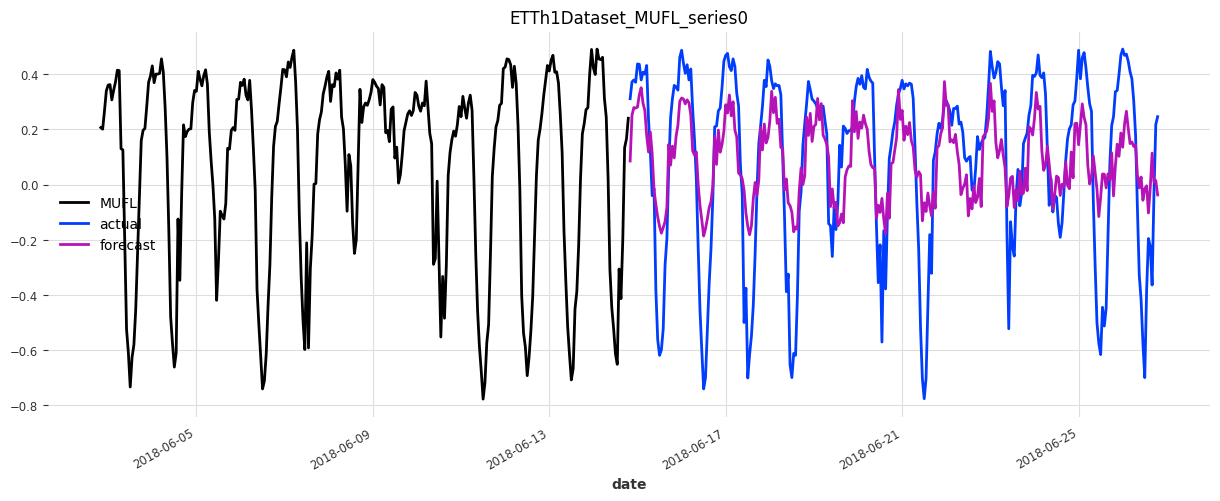

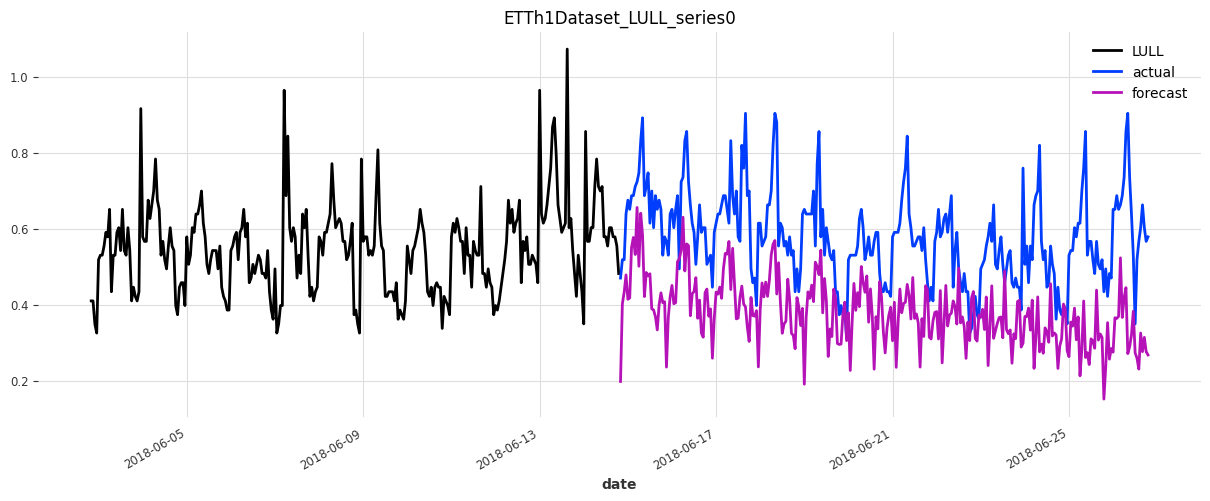

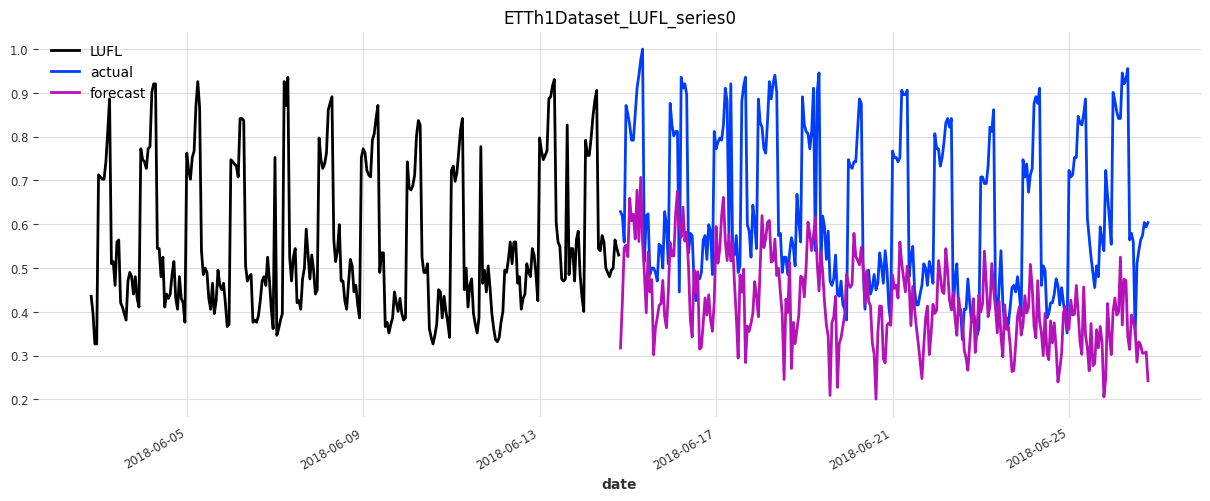

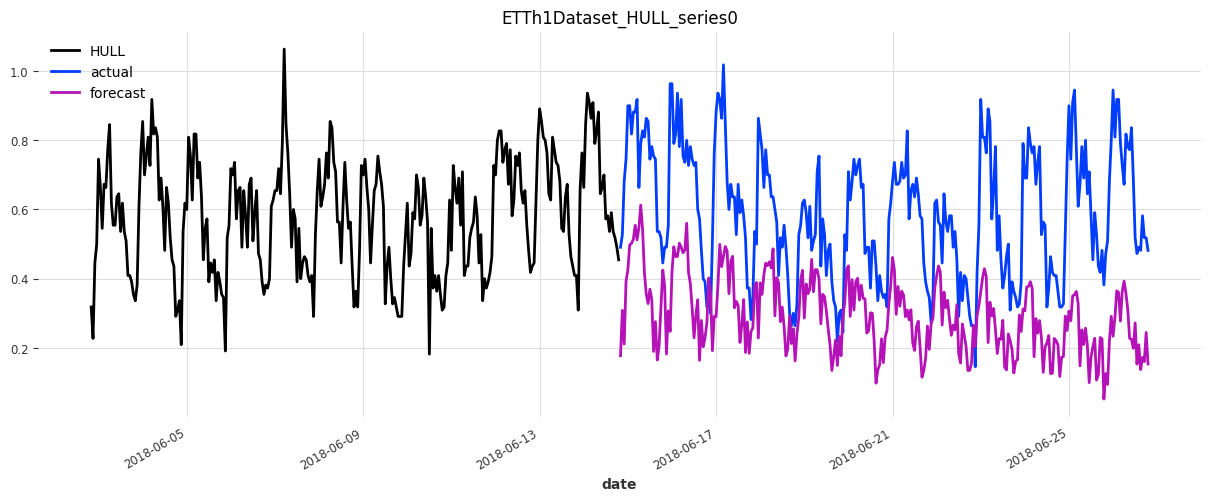

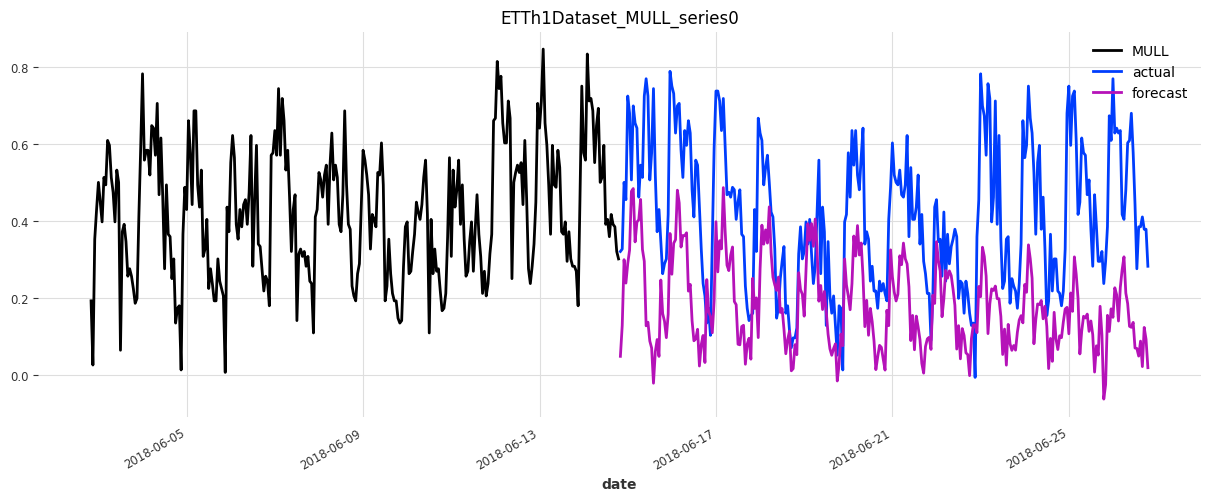

(objective_metric pid=49991) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/joblib/externals/loky/backend/resource_tracker.py:310: UserWarning: resource_tracker: There appear to be 14 leaked semlock objects to clean up at shutdown
(objective_metric pid=49991)   warnings.warn(
(objective_metric pid=49991) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/joblib/externals/loky/backend/resource_tracker.py:310: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
(objective_metric pid=49991)   warnings.warn(
(objective_metric pid=49991) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/joblib/externals/loky/backend/resource_tracker.py:326: UserWarning: resource_tracker: /var/folders/qj/_d5y3qy90_lgynwl0t4kw1hc0000gp/T/joblib_memmapping_folder_49991_af6523d526324086a8ead39d46da77a1_f5e57cad0a0b457d9dacb243da384b2c: F

In [19]:
# pick series and components at random to plot 
max_series_to_plot = 5
max_comps_to_plot = 5


if n_components < max_comps_to_plot:
    max_comps_to_plot = n_components

comps_vec = np.random.randint(0, n_components, max_series_to_plot)
comp_names = train[0].columns.to_list()

if num_series < max_series_to_plot:
    max_series_to_plot = num_series

print("all components:", comp_names)
series_vec = np.random.randint(0, num_series, max_series_to_plot)

for idx in series_vec:
    for comp_id in comps_vec:
        comp_id = comp_names[comp_id]
        plt.figure(figsize=(15, 5))
        val[idx][comp_id].plot()
        test[idx][comp_id].plot(label='actual')
        test_predictions[idx][comp_id].plot(label='forecast')
        plt.title(f"{dataset.__name__}_{comp_id}_series{idx}")
        plt.show()
        plt.close()